# 건축물 음영 평가 모델을 위한 대전시 태양광 차폐율 데이터 분석

## 동기

* 인접 건물 등으로 인한 음영 효과는 태양광 발전에 큰 영향을 끼친다. 현재 음영 효과 계산에는 건물과 지형의 3D 모델 데이터를 이용하는데, 많은 데이터로 인해 막대한 계산 비용이 소요

## 목적

* **건물 옥상에서 측정한 일사량 데이터**와 **위성에서 측정한 일사량 데이터**와 **대전시 건물 정보 데이터**를 통해 건물 옥상에 태양 발전 시스템을 설치했을 때, 효율성을 도출할 수 있는 모델을 개발하려고 한다.


## 결과

* 랜덤포레스트와 딥러닝 학습 및 추론에 각기 7분과 4분 30초가 소요되어 기존에 1개 구의 데이터를 얻는데 5~7일이 걸리던 음영영역 계산 시간을 획기적으로 단축시켰다.
* 예측 성능은 결정계수를 기준으로 랜덤포레스트 0.6, MLP 0.623의 성능을 냈다

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Map_Daejeon-gwangyeoksi.png/350px-Map_Daejeon-gwangyeoksi.png)


# 데이터 전처리

## 기본 환경 설정

In [2]:
%matplotlib inline  

import pandas as pd
import numpy as np
import math
import gmplot
import statistics
from math import *
import time 
from scipy.stats.stats import pearsonr
import seaborn as sns
import os 
import json
from sklearn.cluster import KMeans
import copy
from sklearn.neighbors import KDTree
from numpy import array
import datetime
import datetime
from pysolar.solar import *
from math import *
import calendar 

from mpl_toolkits.mplot3d import axes3d, Axes3D 
import pylab
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image


sns.set(style='whitegrid')
sns.set(font_scale=1)

pd.set_option('display.max_columns', None)





## 한글 폰트 세팅

### Nanum 글꼴 설치


1. sudo apt-get install fonts-nanum*
2. sudo fc-cache -fv
3. sudo cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/



In [18]:
import platform
system = platform.system()

%matplotlib inline
import matplotlib as mpl # 기본 설정 만지는 용도
import matplotlib.pyplot as plt # 그래프 그리는 용도
import matplotlib.font_manager as fm # 폰트 관련 용도

print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())
print ('설정 파일 위치: ', mpl.matplotlib_fname())

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

if system == 'Windows':
    datapath = os.getcwd() + '\\'
    imagepath = datapath + 'images\\'
    # ttf 폰트 전체개수
    print(len(font_list))
    font_list[:10]
    f = [f.name for f in fm.fontManager.ttflist]
    print(len(font_list))

    f[:10]
    [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
    path = 'C:\\Windows\\Fonts\\NanumBarunGothic.ttf'
    font_name = fm.FontProperties(fname=path, size=50).get_name()
    print(font_name)
    plt.rc('font', family=font_name)
elif system == 'Linux':
    datapath = os.getcwd() + '//'
    imagepath = datapath + 'images//'
    # !apt-get update -qq
    # !apt-get install fonts-nanum* -qq
    path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' #
    font_name = fm.FontProperties(fname=path, size=10).get_name()
    print("linux",font_name)
    plt.rc('font', family=font_name)
    fm._rebuild()
    mpl.rcParams['axes.unicode_minus'] = False
else:
    print('# Sorry, my code has compatibility with Windows andLinux only.')
    exit(0)
    


버전:  3.1.1
설치 위치:  /usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py
설정 위치:  /home/junho/.config/matplotlib
캐시 위치:  /home/junho/.cache/matplotlib
설정 파일 위치:  /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/matplotlibrc
linux NanumGothic


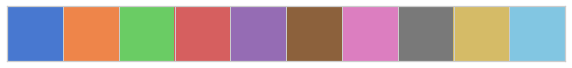

In [19]:
sns.set_style('whitegrid')
sns.palplot(sns.color_palette('muted'))
sns.set_context("talk")
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

# 1. 데이터 탐색

##  **1.1. 대전시 건물 데이터**

> gid (참조용코드) : 무시 가능 (위치랑 관계가 있어보임)
> 
> buld_se_cd (건물위치) : 0 지상 , 1 지하 , 2 공중  
> bdtyp_cd (건물유형코드) : 단독주택 , 부대시설 , 경찰서 , 교회 등
>  
> apt_yn (아파트유무) : Y = 아파트  
>  
> gro_flo_c (층수) : 건물 층 수  
>  
> sig_cd  (시군구코드) : 30110 , 30140 ...  
> sig_nn (시군구명) : 동구 , 서구 ...  
>  
> emd_cd (읍면동코드) : 30110137 , 30110110 ...  
> emd_nm (읍면동명) : 대별동 , 가오동 ...  
>  
> tm_x (직교좌표 x)  
> tm_y (직교좌표 y)  
> lon (경도)   
> lat (위도)  
>  
> buld_area (건물넓이) :   
> buld_elev (표고) : 기본 지형의 높낮이 (높은 지역의 예: 산지)  
>  
> 음영반영 일사량 (m01 ... m12 월평균 , y17 월평균들의 총합) : 건물 옥상에서 측정한 일사량 ( 건물의 그림자 , 구름 고려 )  
> 음영미반영 위성일사량 (st_m01 ... st_m12 월평균 , st_y17 월평균들의 총합): 인공위성에서 측정한 일사량 ( 구름 고려 , 건물의 그림자 고려x )  


In [4]:
build_data = pd.read_csv("./data/originDaejeonBuild/DaejeonBuildingData.csv" , dtype = { 'lat' : str , 'lon' : str ,'tm_x' : str  , 'tm_y' : str} )
# build_data = pd.("./df1.csv" , dtype = { 'lat' : str , 'lon' : str ,'tm_x' : str  , 'tm_y' : str} )

In [5]:
build_data.head()

gid  buld_se_cd buld_se_nm  bdtyp_cd apt_yn  gro_flo_co  sig_cd sig_nm  \
0  24300           0         지상      4299      N           1   30110     동구   
1  16295           0         지상      1001      N           1   30110     동구   
2  24341           0         지상      1001      N           1   30110     동구   
3  24345           0         지상      4402      N           1   30110     동구   
4  24374           0         지상     18999      N           1   30110     동구   

     emd_cd emd_nm              tm_x              tm_y               lon  \
0  30110137    대별동  241302.419829207  409864.414379324  127.459746194608   
1  30110105    가오동   240815.01297069  412384.958080419  127.454452653456   
2  30110137    대별동  241460.822383503   410090.94543095  127.461521377075   
3  30110137    대별동   241530.22297262  410067.763074595  127.462292655181   
4  30110137    대별동  241500.967910986  409605.204042476  127.461942445015   

                lat   buld_area  buld_elev        m01        m02         m03  \
0  36.2858798245272  199.109760       80.0  61.587998  76.368133  108.372414   
1  36.3086147051094   77.392318       71.0  54.658766  74.324060  109.983419   
2  36.2879144426327   91.076386       77.0  62.304043  78.038810  110.389678   
3  36.2877025481814   51.201706       78.0  48.680540  60.641904   86.469240   
4  36.2835354035404  455.844167       80.0  67.250476  84.060162  119.429691   

          m04         m05         m06        m07         m08         m09  \
0  130.399192  153.301472  138.981246  94.119230  116.160558  107.075909   
1  131.021372  148.915192  136.026763  91.462299  112.346493  109.010571   
2  130.250699  150.068158  135.022303  92.270864  114.937466  108.497604   
3  105.063324  123.864551  112.271188  75.391599   93.429884   85.668236   
4  141.218665  162.556833  146.167080  99.833438  124.410167  117.419093   

         m10        m11        m12          y17     st_m01     st_m02  \
0  76.058284  63.246135  57.791311  1183.461879  77.441429  97.564735   
1  75.964252  59.752928  48.710326  1152.176436  77.599655  96.723419   
2  77.568352  64.558410  58.305233  1182.211623  77.441429  97.564735   
3  60.352004  50.002206  45.656253   947.490926  77.441429  97.564735   
4  83.429842  69.257649  62.888074  1277.921216  77.441429  97.564735   

       st_m03      st_m04      st_m05      st_m06      st_m07      st_m08  \
0  136.456909  159.853821  181.146118  161.530762  109.311691  138.931046   
1  136.413635  159.390518  180.876144  165.518311  112.231346  137.366898   
2  136.456909  159.853821  181.146118  161.530762  109.311691  138.931046   
3  136.456909  159.853821  181.146118  161.530762  109.311691  138.931046   
4  136.456909  159.853821  181.146118  161.530762  109.311691  138.931046   

       st_m09     st_m10     st_m11     st_m12       st_y17  
0  133.254684  95.614578  80.392227  72.975700  1444.473755  
1  134.195908  96.377113  79.952248  72.717972  1449.363159  
2  133.254684  95.614578  80.392227  72.975700  1444.473755  
3  133.254684  95.614578  80.392227  72.975700  1444.473755  
4  133.254684  95.614578  80.392227  72.975700  1444.473755

### 1.1.1 column별 형식 확인

In [6]:
build_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147754 entries, 0 to 147753
Data columns (total 42 columns):
gid           147754 non-null int64
buld_se_cd    147754 non-null int64
buld_se_nm    147754 non-null object
bdtyp_cd      147754 non-null int64
apt_yn        147754 non-null object
gro_flo_co    147754 non-null int64
sig_cd        147754 non-null int64
sig_nm        147754 non-null object
emd_cd        147754 non-null int64
emd_nm        147754 non-null object
tm_x          147754 non-null object
tm_y          147754 non-null object
lon           147754 non-null object
lat           147754 non-null object
buld_area     147754 non-null float64
buld_elev     147754 non-null float64
m01           147754 non-null float64
m02           147754 non-null float64
m03           147754 non-null float64
m04           147754 non-null float64
m05           147754 non-null float64
m06           147754 non-null float64
m07           147754 non-null float64
m08           147754 non-null float

### 1.1.2 데이터 분포 훑어보기

In [7]:
build_data.describe()

gid     buld_se_cd       bdtyp_cd     gro_flo_co  \
count  147754.000000  147754.000000  147754.000000  147754.000000   
mean    73879.886230       0.000129    2743.962999       2.225192   
std     42653.850793       0.011339    3563.400798       2.640942   
min         1.000000       0.000000    1001.000000       0.000000   
25%     36940.250000       0.000000    1001.000000       1.000000   
50%     73880.500000       0.000000    1001.000000       1.000000   
75%    110818.750000       0.000000    3001.000000       3.000000   
max    147757.000000       1.000000   27999.000000      51.000000   

              sig_cd        emd_cd      buld_area      buld_elev  \
count  147754.000000  1.477540e+05  147754.000000  147754.000000   
mean    30163.558144  3.016367e+07     186.553186      64.722290   
std        41.590794  4.159049e+04     773.325543      24.032289   
min     30110.000000  3.011010e+07       0.085259       0.000000   
25%     30140.000000  3.014010e+07      72.208554      50.000000   
50%     30170.000000  3.017010e+07     105.244051      59.000000   
75%     30200.000000  3.020012e+07     153.676529      73.360001   
max     30230.000000  3.023013e+07  130409.550646     575.000000   

                 m01            m02            m03            m04  \
count  147754.000000  147754.000000  147754.000000  147754.000000   
mean       55.925631      70.677156     101.713438     119.425253   
std         9.422654      11.298384      14.653770      15.445972   
min         0.000000       0.000000       0.000000       0.000000   
25%        51.381658      65.216892      94.470049     111.487575   
50%        57.513789      72.409462     103.742219     121.099433   
75%        62.375331      78.376077     111.554599     129.584568   
max        78.468292      98.541275     138.905443     160.837215   

                 m05            m06            m07            m08  \
count  147754.000000  147754.000000  147754.000000  147754.000000   
mean      136.929229     126.142181      83.915675     103.887353   
std        16.762203      15.217830      10.392281      13.100767   
min         0.000000       0.000000       0.000000       0.000000   
25%       128.115865     118.061558      78.240616      96.991555   
50%       138.134556     127.118031      84.709294     104.999353   
75%       147.732052     135.959141      90.856187     112.477660   
max       183.110577     170.121167     111.944861     139.990626   

                 m09            m10            m11            m12  \
count  147754.000000  147754.000000  147754.000000  147754.000000   
mean      100.549598      71.632038      57.962761      52.088693   
std        14.092994      10.916987       9.712493       9.556732   
min         0.000000       0.000000       0.000000       0.000000   
25%        93.275781      66.342756      53.297663      47.628474   
50%       102.269936      73.224264      59.529122      53.857362   
75%       110.065236      78.948424      64.590607      58.648091   
max       136.316334      98.873651      81.471288      75.043336   

                 y17         st_m01         st_m02         st_m03  \
count  147754.000000  147754.000000  147754.000000  147754.000000   
mean     1080.849007      77.050468      96.618265     136.530418   
std       146.156608       0.842217       0.983732       0.831234   
min         0.000000      71.198448      94.399231     134.171249   
25%      1005.319831      76.414169      95.940933     135.864822   
50%      1097.736867      77.077156      96.510239     136.479599   
75%      1178.381805      77.652016      97.260674     137.144516   
max      1457.275539      80.799583      99.501114     139.515732   

              st_m04         st_m05         st_m06         st_m07  \
count  147754.000000  147754.000000  147754.000000  147754.000000   
mean      158.612880     180.166504     165.272703     109.550001   
std         1.089945       0.982429       1.552964       1.750496   
min       155.8373

### 1.1.3 데이터 시각화 

* 1층 건물이 전체의 절반가량을 차지하고, 10층 이상 건물은 극히 적다.
* 건물의 면적은 100m^2 미만이 전체의 45.7%를 차지하고 1000m^2 미만이 98.1%를 차지한다.

gro_flo_co: mean= 2.23, st.dev.= 2.64, min= 0.00, max= 51.00
buld_area: mean= 186.55, st.dev.= 773.33, min= 0.09, max= 130409.55
buld_elev: mean= 64.72, st.dev.= 24.03, min= 0.00, max= 575.00
y17: mean= 1080.85, st.dev.= 146.16, min= 0.00, max= 1457.28
st_y17: mean= 1445.17, st.dev.= 7.22, min= 1429.47, max= 1482.60


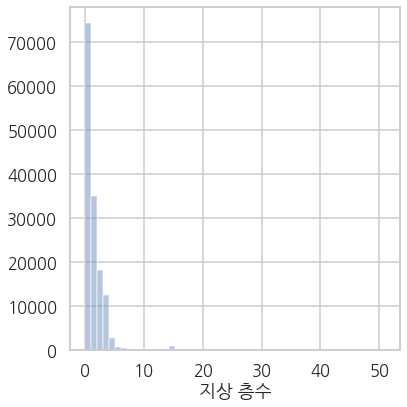

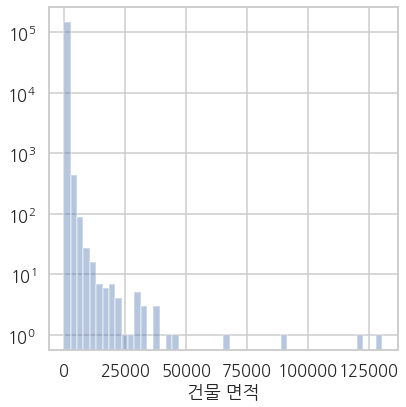

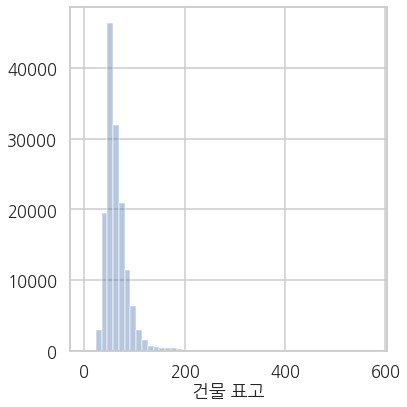

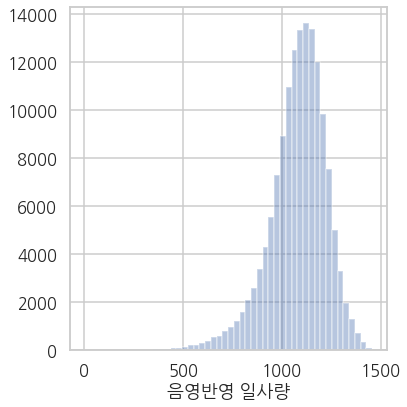

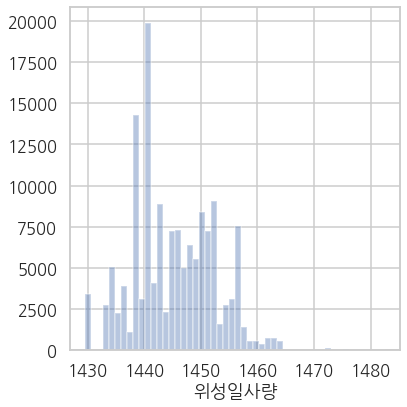

In [8]:
# plot : numerical distribution

import numpy as np
def dist_plot(df, xk, xv):

    fig, ax = plt.subplots(figsize=(6,6))
    f = sns.distplot(df[xk], kde=False, rug=False)

    if xv == '건물 면적':
        f.set(yscale='log')

    mean_val = df[xk].mean()
    std_val = df[xk].std()
    max_val = df[xk].max()
    min_val = df[xk].min()
    
    print('{}: mean= {:.2f}, st.dev.= {:.2f}, min= {:.2f}, max= {:.2f}'.format(xk, mean_val, std_val, min_val, max_val))

    heights = [h.get_height() for h in f.patches]
    index_max = np.argmax(heights)

    f.set(xlabel=xv)
    plt.tight_layout()    

xs = {
    'gro_flo_co' : '지상 층수',
    'buld_area' : '건물 면적',
    'buld_elev' : '건물 표고',
    'y17' : '음영반영 일사량',
    'st_y17': '위성일사량',
}
    
for xk, xv in xs.items():
    dist_plot(build_data, xk, xv)
    

## **1.2 중복데이터 확인 : 동일 위치 중복 데이터 check**

In [9]:
latlonCount = build_data.groupby(['lon', 'lat']).size().reset_index(name ='count')

if latlonCount.shape[0] == 147754:
  print('> 직교좌표 중복데이터 없음')

xyCount = build_data.groupby(['tm_x','tm_y']).size().reset_index(name='count')

if xyCount.shape[0] == 147754:
  print('> 위경도 중복데이터 없음')

> 직교좌표 중복데이터 없음
> 위경도 중복데이터 없음


## **1.3 gid와 빌딩의 연관성 조사**

* 플라스크와 네이버 지도 API를 이용하여 위도 경도를 이용하여 마커를 찍어 봄

> 붙어있는 건물에서 gid 연관성 없음


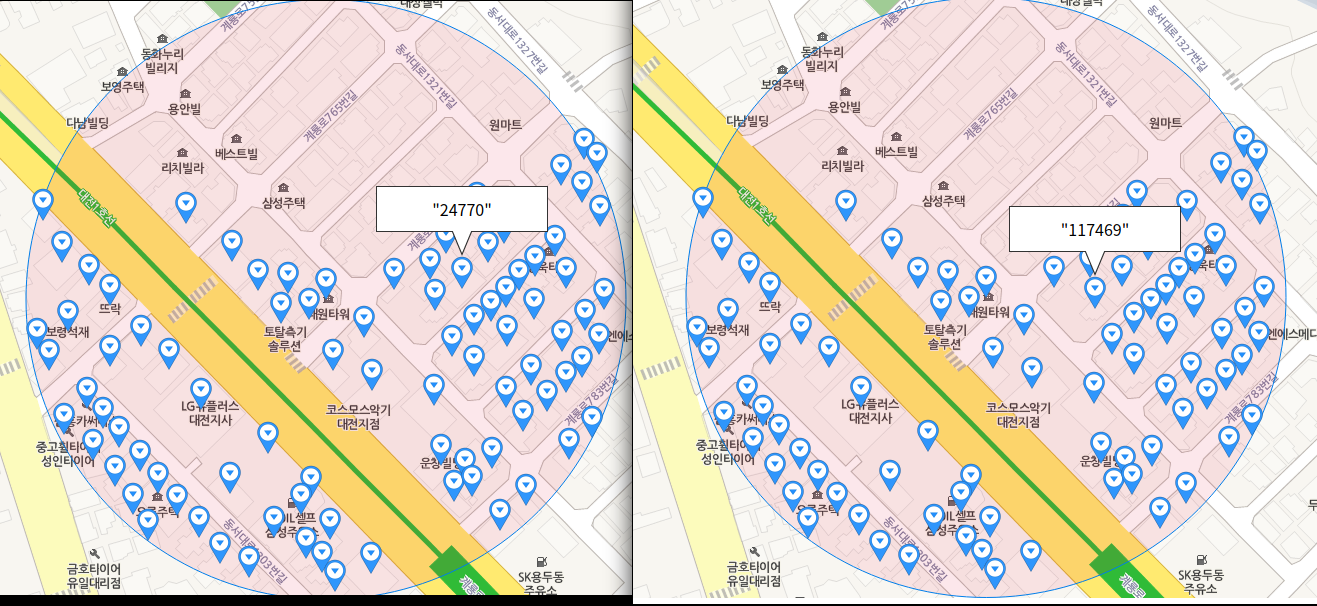

In [10]:
print("> 붙어있는 건물에서 gid 연관성 없음")
Image("./image/presentation/gid.png")

## 1.4 지하인 경우

In [11]:
BuildLocation = build_data[['lon','lat']]

print("지상 : 0")
print("지하 : 1")
print(build_data['buld_se_cd'].value_counts())

print("\n> 지하 데이터가 오류 데이터가 아님")

build_data.loc[build_data['buld_se_cd'] == 1]

지상 : 0
지하 : 1
0    147735
1        19
Name: buld_se_cd, dtype: int64

> 지하 데이터가 오류 데이터가 아님


gid  buld_se_cd buld_se_nm  bdtyp_cd apt_yn  gro_flo_co  sig_cd  \
22021    89047           1         지하      6305      N           0   30170   
30061    67891           1         지하      6305      N           0   30170   
48841    72818           1         지하      6305      N           0   30170   
51580   103073           1         지하      6305      N           0   30200   
57949    39950           1         지하      3199      N           0   30140   
63424    39258           1         지하      3199      N           0   30140   
63614     2590           1         지하      6305      N           0   30110   
67177    68850           1         지하      6305      N           0   30170   
70447   104574           1         지하      6305      N           0   30200   
72861     1473           1         지하      1001      N           0   30110   
82187     1474           1         지하      6305      N           0   30110   
90780    10791           1         지하      6305      N           0   30110   
113308   67397           1         지하      6305      N           0   30170   
125592  101610           1         지하      6305      N           0   30200   
128487  101867           1         지하      6305      N           0   30200   
131831   67890           1         지하      6305      N           0   30170   
131839   67892           1         지하      6305      N           0   30170   
136449  100596           1         지하      6305      N           0   30200   
137586   39257           1         지하      3199      N           0   30140   

       sig_nm    emd_cd emd_nm              tm_x              tm_y  \
22021      서구  30170106    탄방동   234520.00356667  416471.704088673   
30061      서구  30170111    갈마동  233467.973062164  417807.147156705   
48841      서구  30170112    둔산동  234712.482175202  417107.265063677   
51580     유성구  30200120    지족동  228526.500275495  419606.976542112   
57949      중구  30140102    선화동  237670.473981022   414164.92543329   
63424      중구  30140112    용두동  237044.008003055  413902.763799622   
63614      동구  30110110     대동  239765.428533184  414702.697100751   
67177      서구  30170105    용문동  235307.680218489  415651.775149602   
70447     유성구  30200139    반석동  228227.752705897  421596.634772285   
72861      동구  30110107    판암동  240301.538244694  413608.178431638   
82187      동구  30110107    판암동   241168.38585049  413314.819316397   
90780      동구  30110120     중동  238877.504212429  414897.141792571   
113308     서구  30170113    월평동  231786.514612539  417416.422336739   
125592    유성구  30200111    봉명동  230660.156376599  417342.394954041   
128487    유성구  30200112    구암동  228844.257876801  417945.433011805   
131831     서구  30170113    월평동  232735.833520751  417858.295927189   
131839     서구  30170112    둔산동  234224.674079454   417805.66093434   
136449    유성구  30200119    노은동  228529.858090468   418792.46017895   
137586     중구  30140113    오류동  236357.586682591  414588.600840955   

                     lon               lat    buld_area  buld_elev        m01  \
22021   127.384543667179  36.3456888830466  1770.754139  55.000000  54.097859   
30061   127.372881941172  36.3577605189151  3726.100993  43.000000  66.016004   
48841    127.38671610625  36.3514093895446  1971.922709  50.000000  53.695903   
51580   127.317893541331  36.3741390691511  2463.744534  65.000000  66.140594   
57949   127.419526773333  36.3247830566921  2354.822554  56.000000  57.490670   
63424   127.412537688857  36.3224448400471  4240.016309  54.000000  73.716364   
63614   127.442884576914  36.3295450635349  2921.925631  54.840000  66.559104   
67177    127.39328083833  36.3382714472239  2607.288564  44.000000  61.778868   
70447   127.314636628979  36.3920779323552  5670.102560  78.000000  65.686056   
72861   127.448798734459  36.3196594576009  1709.177906  60.840000  72.894204   
82187   127.458436209644  36.3169791998225  1119.721133  69.199997  47.930993   
90780   127.433005337998  36.3313335514613  3316.379611  47.000000  74.074855

# 2. 파생데이터 분석
![](https://t1.daumcdn.net/cfile/tistory/26470C4A555040791B)

해가 위 사진 같이 움직이니까, 자신의 건물보다 남쪽에 있는 건물들을 대상으로만 분석 ( 북쪽에 있는 건물들의 그림자에는 영향을 안 받을테니 )

* x축 y축의 첫째 자리 단위가 m이다. 즉, 1차이나면 1m 차이
* 일사량은 건물 옥상에서 잰 일사량이 평균(?) wat/m^2
* 건물의 넓이는 m^2 이다.
* 직각좌표 , 경도 , 위도는 건물의 중심


## 고려사항

* <u>건물간 거리 잴때 그 건물의 넓이도 고려를 해서 재야하지 않을까</u>
* <u>건물당 층의 높이가 다르지 않을까</u>
* <u>방위각 240도를 잘게 나눠서 영역당 태양의 고도와 비교하여 차폐 여부를 1, 0 으로 해서 모든 영역을 계산할 수 있지 않을까</u>


# 2.1 일사량 손실 비율 계산 ( rate of solar radiation loss )

* (위성 일사량 - 음영 반영 일사량) / 위성 일사량
     * <u>위성 일사량과 음영 일사량 모두 구름같은 요소들을 포함한 일사량이나 음영 반영 일사량에만 주변 건물의 그림자 영향이 들어가 있기 때문에 두 일사량을 연산하여 주변 건물의 차폐율을 계산 가능</u>
* 위성 일사량 , 음영 반영 일사량 삭제

In [12]:

for i in range(1,13) :
    build_data['sL'+str(i).zfill(2)] = (build_data['st_m'+str(i).zfill(2)] -  build_data["m"+str(i).zfill(2)]) / build_data['st_m'+str(i).zfill(2)]
    del build_data['st_m'+str(i).zfill(2)]
    del build_data["m"+str(i).zfill(2)]

build_data['sL_y17'] = (build_data['st_y17'] -  build_data['y17']) / build_data['st_y17']
del build_data['y17']
del build_data['st_y17']

    
build_data.head()

gid  buld_se_cd buld_se_nm  bdtyp_cd apt_yn  gro_flo_co  sig_cd sig_nm  \
0  24300           0         지상      4299      N           1   30110     동구   
1  16295           0         지상      1001      N           1   30110     동구   
2  24341           0         지상      1001      N           1   30110     동구   
3  24345           0         지상      4402      N           1   30110     동구   
4  24374           0         지상     18999      N           1   30110     동구   

     emd_cd emd_nm              tm_x              tm_y               lon  \
0  30110137    대별동  241302.419829207  409864.414379324  127.459746194608   
1  30110105    가오동   240815.01297069  412384.958080419  127.454452653456   
2  30110137    대별동  241460.822383503   410090.94543095  127.461521377075   
3  30110137    대별동   241530.22297262  410067.763074595  127.462292655181   
4  30110137    대별동  241500.967910986  409605.204042476  127.461942445015   

                lat   buld_area  buld_elev      sL01      sL02      sL03  \
0  36.2858798245272  199.109760       80.0  0.204715  0.217257  0.205812   
1  36.3086147051094   77.392318       71.0  0.295631  0.231582  0.193751   
2  36.2879144426327   91.076386       77.0  0.195469  0.200133  0.191029   
3  36.2877025481814   51.201706       78.0  0.371389  0.378444  0.366326   
4  36.2835354035404  455.844167       80.0  0.131596  0.138417  0.124781   

       sL04      sL05      sL06      sL07      sL08      sL09      sL10  \
0  0.184260  0.153714  0.139599  0.138983  0.163898  0.196457  0.204533   
1  0.177985  0.176701  0.178177  0.185056  0.182143  0.187676  0.211802   
2  0.185189  0.171563  0.164108  0.155892  0.172701  0.185788  0.188739   
3  0.342754  0.316217  0.304955  0.310306  0.327509  0.357109  0.368799   
4  0.116576  0.102620  0.095113  0.086709  0.104519  0.118837  0.127436   

       sL11      sL12    sL_y17  
0  0.213280  0.208075  0.180697  
1  0.252642  0.330147  0.205046  
2  0.196957  0.201032  0.181562  
3  0.378022  0.374364  0.344058  
4  0.138503  0.138233  0.115303

# 2.2 건물의 너비 계산

* 건물을 원이라고 가정하고 건물의 너비를 계산
    * <u>건물의 형태를 나타내는 변수가 없기 때문에 원이 모든 형태와의 오차 합이 가장 적을 것이라고 생각 </u>

In [13]:
build_data['buld_length']= build_data['buld_area'].apply(lambda x : np.sqrt(x/np.pi)*2)

build_data.head()

gid  buld_se_cd buld_se_nm  bdtyp_cd apt_yn  gro_flo_co  sig_cd sig_nm  \
0  24300           0         지상      4299      N           1   30110     동구   
1  16295           0         지상      1001      N           1   30110     동구   
2  24341           0         지상      1001      N           1   30110     동구   
3  24345           0         지상      4402      N           1   30110     동구   
4  24374           0         지상     18999      N           1   30110     동구   

     emd_cd emd_nm              tm_x              tm_y               lon  \
0  30110137    대별동  241302.419829207  409864.414379324  127.459746194608   
1  30110105    가오동   240815.01297069  412384.958080419  127.454452653456   
2  30110137    대별동  241460.822383503   410090.94543095  127.461521377075   
3  30110137    대별동   241530.22297262  410067.763074595  127.462292655181   
4  30110137    대별동  241500.967910986  409605.204042476  127.461942445015   

                lat   buld_area  buld_elev      sL01      sL02      sL03  \
0  36.2858798245272  199.109760       80.0  0.204715  0.217257  0.205812   
1  36.3086147051094   77.392318       71.0  0.295631  0.231582  0.193751   
2  36.2879144426327   91.076386       77.0  0.195469  0.200133  0.191029   
3  36.2877025481814   51.201706       78.0  0.371389  0.378444  0.366326   
4  36.2835354035404  455.844167       80.0  0.131596  0.138417  0.124781   

       sL04      sL05      sL06      sL07      sL08      sL09      sL10  \
0  0.184260  0.153714  0.139599  0.138983  0.163898  0.196457  0.204533   
1  0.177985  0.176701  0.178177  0.185056  0.182143  0.187676  0.211802   
2  0.185189  0.171563  0.164108  0.155892  0.172701  0.185788  0.188739   
3  0.342754  0.316217  0.304955  0.310306  0.327509  0.357109  0.368799   
4  0.116576  0.102620  0.095113  0.086709  0.104519  0.118837  0.127436   

       sL11      sL12    sL_y17  buld_length  
0  0.213280  0.208075  0.180697    15.922136  
1  0.252642  0.330147  0.205046     9.926679  
2  0.196957  0.201032  0.181562    10.768568  
3  0.378022  0.374364  0.344058     8.074159  
4  0.138503  0.138233  0.115303    24.091468

# 2.3 건물의 절대 높이 ( Absolute height of building )

* 전 건물의 높이를 동일한 기준에서 평가하기 위해 **표고 + 건물 높이**를 절대 높이로 계산
* <u>같은 건물이라도 표고가 다르면 그림자를 드리울 수 있기 때문에 실제 일사량에 영향을 주는 주변 건물을 찾기 위해서 절대 높이를 계산</u>

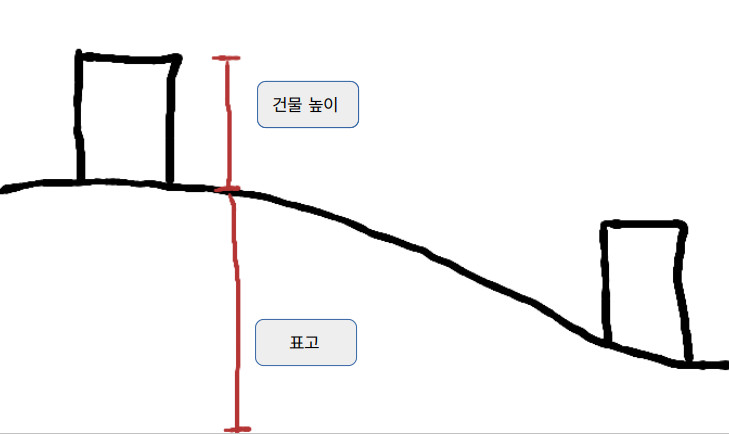

In [14]:
Image("./image/presentation/2.3.png")

## 2.3.1 건물 높이 

* 국가공간정보포털에서 건물 높이 데이터 수집 (http://data.nsdi.go.kr/dataset/12623)
* 높이나 건물 층수 데이터가 0인 데이터는 오류 데이터로 판단하여 삭제
* <u>건물 층수 , 높이 데이터로 선형 회귀식을 그린 후 기울기 값을 층 당 높이 값으로 계산</u>


In [15]:
a= pd.read_csv("./data/DaejeonBuild/F_FAC_BUILDING_30_201906.CSV" , encoding = "ISO-8859-1")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (15,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
print("원본 데이터 개수 : ",len(a))
a.head()

원본 데이터 개수 :  176050


UFID BLD_NM DONG_NM  GRND_FLR  UGRND_FLR  \
0  0000239636943130022900000000    NaN     NaN         0          0   
1  0000239636643130087800000000    NaN     NaN         0          0   
2  1977239658843130089800000000    NaN     NaN         2          0   
3  1977239623393129884100000000    NaN     NaN         2          0   
4  0000239703503129322000000000    NaN     NaN         0          0   

            PNU  ARCHAREA  TOTALAREA  PLATAREA  HEIGHT  STRCT_CD USABILITY  \
0  3.011010e+18      0.00       0.00       0.0     0.0       NaN       NaN   
1  3.011010e+18      0.00       0.00       0.0     0.0       NaN       NaN   
2  3.011010e+18     83.37     135.21     187.0     8.0      11.0     01000   
3  3.011010e+18     69.25     115.33     145.0     8.0      11.0     01000   
4  3.011010e+18      0.00       0.00       0.0     0.0       NaN       NaN   

   BC_RAT  VL_RAT  BLDRGST_PK   USEAPR_DAY  REGIST_DAY  GB_CD  VIOL_BD_YN  \
0    0.00    0.00         NaN          NaN  20111117.0    NaN         NaN   
1    0.00    0.00         NaN          NaN  20111117.0    NaN         NaN   
2   44.58   72.30      3965.0  1.97708e+07  20111117.0    0.0         0.0   
3   47.08   79.54      3942.0  1.97705e+07  20111117.0    0.0         0.0   
4    0.00    0.00         NaN          NaN  20111117.0    NaN         NaN   

              GEOIDN  BLDG_PNU BLDG_PNU_Y  BLD_UNLICE  \
0                NaN       NaN        NaN         NaN   
1  B001000000051FXLH       NaN        NaN         NaN   
2  B001000000051KAHU       NaN        NaN         NaN   
3  B001000000051JT1W       NaN        NaN         NaN   
4                NaN       NaN        NaN         NaN   

                   BD_MGT_SN  SGG_OID  COL_ADM_SE  
0                        NaN       90       30110  
1                        NaN       92       30110  
2  3011010300101650008031519       94       30110  
3  3011010300101530010031603       96       30110  
4                        NaN       97       30110

In [17]:
afh = a.loc[(a["GRND_FLR"] > 0) & (a['HEIGHT'] > 0)]

z = afh.groupby(['GRND_FLR'])['HEIGHT'].mean().reset_index(name="height")
b = afh.groupby(['GRND_FLR'])['HEIGHT'].count().reset_index(name="count")
s = pd.merge(z,b , on = 'GRND_FLR')

s = s.rename(columns = {'GRND_FLR': 'gro_flo_co'})
# fllor ,height로 그래프 그린다음에 기울기로 사용
print("높이 , 층수가 0을 넘는 데이터 개수 : " , len(afh))
s.head()

높이 , 층수가 0을 넘는 데이터 개수 :  84194


gro_flo_co     height  count
0           1   4.603371  25281
1           2   8.013415  24371
2           3  11.532237  15803
3           4  13.658547  11735
4           5  18.225957   2611

In [18]:
X = s.drop(['height', 'count'] , axis = 1)
y = s.drop(['gro_flo_co', 'count'], axis=1)


In [19]:
from sklearn import linear_model

lR_model = linear_model.LinearRegression()
lR_model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

> 기울기 : [[3.14153245]]
> 절편 : [-0.34726967]


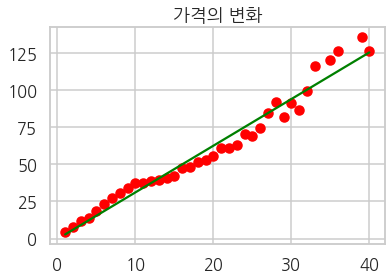

In [20]:
plt.scatter(X , y , color = 'red')
plt.title('가격의 변화')
print("> 기울기 :",lR_model.coef_)
print("> 절편 :",lR_model.intercept_)
plt.plot(X , lR_model.predict(X) , color = 'green')

In [21]:
build_data['buld_height'] = build_data['gro_flo_co']*round(lR_model.coef_[0][0],2)

build_data.head()

gid  buld_se_cd buld_se_nm  bdtyp_cd apt_yn  gro_flo_co  sig_cd sig_nm  \
0  24300           0         지상      4299      N           1   30110     동구   
1  16295           0         지상      1001      N           1   30110     동구   
2  24341           0         지상      1001      N           1   30110     동구   
3  24345           0         지상      4402      N           1   30110     동구   
4  24374           0         지상     18999      N           1   30110     동구   

     emd_cd emd_nm              tm_x              tm_y               lon  \
0  30110137    대별동  241302.419829207  409864.414379324  127.459746194608   
1  30110105    가오동   240815.01297069  412384.958080419  127.454452653456   
2  30110137    대별동  241460.822383503   410090.94543095  127.461521377075   
3  30110137    대별동   241530.22297262  410067.763074595  127.462292655181   
4  30110137    대별동  241500.967910986  409605.204042476  127.461942445015   

                lat   buld_area  buld_elev      sL01      sL02      sL03  \
0  36.2858798245272  199.109760       80.0  0.204715  0.217257  0.205812   
1  36.3086147051094   77.392318       71.0  0.295631  0.231582  0.193751   
2  36.2879144426327   91.076386       77.0  0.195469  0.200133  0.191029   
3  36.2877025481814   51.201706       78.0  0.371389  0.378444  0.366326   
4  36.2835354035404  455.844167       80.0  0.131596  0.138417  0.124781   

       sL04      sL05      sL06      sL07      sL08      sL09      sL10  \
0  0.184260  0.153714  0.139599  0.138983  0.163898  0.196457  0.204533   
1  0.177985  0.176701  0.178177  0.185056  0.182143  0.187676  0.211802   
2  0.185189  0.171563  0.164108  0.155892  0.172701  0.185788  0.188739   
3  0.342754  0.316217  0.304955  0.310306  0.327509  0.357109  0.368799   
4  0.116576  0.102620  0.095113  0.086709  0.104519  0.118837  0.127436   

       sL11      sL12    sL_y17  buld_length  buld_height  
0  0.213280  0.208075  0.180697    15.922136         3.14  
1  0.252642  0.330147  0.205046     9.926679         3.14  
2  0.196957  0.201032  0.181562    10.768568         3.14  
3  0.378022  0.374364  0.344058     8.074159         3.14  
4  0.138503  0.138233  0.115303    24.091468         3.14

## 2.3.2 절대높이 계산


In [22]:
build_data['height'] = build_data['buld_height'] + build_data['buld_elev']

In [23]:
build_data.to_csv("./data/2.3/build_data_height.csv" , index=False ,encoding='utf-8')

build_data.head()

gid  buld_se_cd buld_se_nm  bdtyp_cd apt_yn  gro_flo_co  sig_cd sig_nm  \
0  24300           0         지상      4299      N           1   30110     동구   
1  16295           0         지상      1001      N           1   30110     동구   
2  24341           0         지상      1001      N           1   30110     동구   
3  24345           0         지상      4402      N           1   30110     동구   
4  24374           0         지상     18999      N           1   30110     동구   

     emd_cd emd_nm              tm_x              tm_y               lon  \
0  30110137    대별동  241302.419829207  409864.414379324  127.459746194608   
1  30110105    가오동   240815.01297069  412384.958080419  127.454452653456   
2  30110137    대별동  241460.822383503   410090.94543095  127.461521377075   
3  30110137    대별동   241530.22297262  410067.763074595  127.462292655181   
4  30110137    대별동  241500.967910986  409605.204042476  127.461942445015   

                lat   buld_area  buld_elev      sL01      sL02      sL03  \
0  36.2858798245272  199.109760       80.0  0.204715  0.217257  0.205812   
1  36.3086147051094   77.392318       71.0  0.295631  0.231582  0.193751   
2  36.2879144426327   91.076386       77.0  0.195469  0.200133  0.191029   
3  36.2877025481814   51.201706       78.0  0.371389  0.378444  0.366326   
4  36.2835354035404  455.844167       80.0  0.131596  0.138417  0.124781   

       sL04      sL05      sL06      sL07      sL08      sL09      sL10  \
0  0.184260  0.153714  0.139599  0.138983  0.163898  0.196457  0.204533   
1  0.177985  0.176701  0.178177  0.185056  0.182143  0.187676  0.211802   
2  0.185189  0.171563  0.164108  0.155892  0.172701  0.185788  0.188739   
3  0.342754  0.316217  0.304955  0.310306  0.327509  0.357109  0.368799   
4  0.116576  0.102620  0.095113  0.086709  0.104519  0.118837  0.127436   

       sL11      sL12    sL_y17  buld_length  buld_height  height  
0  0.213280  0.208075  0.180697    15.922136         3.14   83.14  
1  0.252642  0.330147  0.205046     9.926679         3.14   74.14  
2  0.196957  0.201032  0.181562    10.768568         3.14   80.14  
3  0.378022  0.374364  0.344058     8.074159         3.14   81.14  
4  0.138503  0.138233  0.115303    24.091468         3.14   83.14

# 2.4 인접한 빌딩

* 모든 빌딩을 돌면서 그 빌딩 주변 N미터 안에 있으면서 , 남쪽에있는 빌딩과 위로 30도 까지의 빌딩들을 수집
    * <u>여름에는 방위각이 60도 일 때 일출이 발생하고 240도 일 때 일몰이 발생하기에 이 방위각 사이에 있는 모든 건물들이 영향을 줄 것이라고 판단</u>


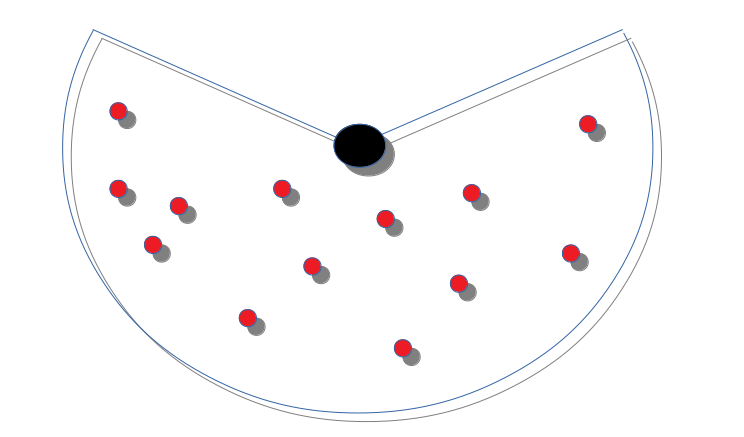

In [24]:
Image("./image/presentation/nearBuild.png")

In [25]:
build_data['tm_x'] = build_data['tm_x'].astype(float)
build_data['tm_y'] = build_data['tm_y'].astype(float)

## 2.4.1 인접 빌딩 수집

* 모든 빌딩을 돌면서 KDTree로 현재 빌딩의 최근접 빌딩 1000개를 뽑아내서 N미터 이하이고 , 방위각이 60 ~ 300 사이에 있는 빌딩들의 인덱스와 거리를 수집
* 조건에 맞는 빌딩이 없어서 list 가 비어있다면 에러가 나기 때문에 , 그런 경우네는 자기 자신의 index를 추가

In [56]:
from sklearn.neighbors import KDTree
from numpy import array


def nearestBuild(build_data , meter) :

    start = time.time()

    # gu_locat
    xylocation = pd.DataFrame()
    xylocation['tm_x'] = build_data['tm_x']
    xylocation['tm_y'] = build_data['tm_y']
    xylocation['tm_x'] = xylocation['tm_x'].astype(float)
    xylocation['tm_y'] = xylocation['tm_y'].astype(float)

    xylocation_list = xylocation.values.tolist()
    xylocation_np = array(xylocation_list)
    tree = KDTree(xylocation_np)


    realnearest_ind = []
    realnearest_dist = []

    build_count_list = []
    realnearest_ind_list = []
    realnearest_dist_list = []

    for i in range(len(xylocation_np)) :

        # 기준 빌딩의 xy좌표와 최단거리에 있는 1000개의 인접 빌딩들을 탐색
        nearest_dist , nearest_ind = tree.query([xylocation_np[i]] , k = 1000)
        for j in range(1,len(nearest_dist[0])) :
            
            # 100 미터 안이고
            if nearest_dist[0][j] <= meter : 


                # 남쪽 + 양쪽 30도 위에도 포함
#                 buildsAngle = np.arctan2(xylocation_np[i][1]-xylocation_np[nearest_ind[0][j]][1] , xylocation_np[i][0]-xylocation_np[nearest_ind[0][j]][0])  * 180 /  np.pi

#                 if not ( -150 < buildsAngle <-30 ) :    
#                     realnearest_ind.append(nearest_ind[0][j])
#                     realnearest_dist.append(nearest_dist[0][j])


    #           남쪽에있는 빌딩들 만을 위한 처리 
                if  xylocation_np[i][1]-xylocation_np[nearest_ind[0][j]][1] > 0 :
                    realnearest_ind.append(nearest_ind[0][j])
                    realnearest_dist.append(nearest_dist[0][j])

            else :
                break

        nearest_ind = np.delete(nearest_ind[0][:j] , 0)
        build_count_list.append(len(realnearest_ind))
        realnearest_ind_list.append(realnearest_ind)
        realnearest_dist_list.append(realnearest_dist)

        realnearest_ind = []
        realnearest_dist = []
    
    # 조건에 맞는 빌딩이 없는경우 자기 자신을 넣준다 ( 에러방지 , 빈 list가 있다면 에러가 남 )
    nearZero_list = []
    for i in range(len(realnearest_ind_list)) :
        if len(realnearest_ind_list[i]) == 0 :
            nearZero_list.append(i)
            realnearest_ind_list[i].append(i)
            realnearest_dist_list[i].append(0)

    print("find nearestBuild time :", time.time() - start) 

    
    return realnearest_ind_list , realnearest_dist_list , nearZero_list


build_data['tm_x'] = build_data['tm_x'].astype(float)
build_data['tm_y'] = build_data['tm_y'].astype(float)
realnearest_ind_list , realnearest_dist_list , nearZero_list = nearestBuild(build_data , 100)

find nearestBuild time : 55.8835334777832


## 2.4.2 검증

### 거리가 마이너스나 제로가 있거나 기준 m를 넘어가는 데이터가 있는지 체크

In [27]:
def minmaxCheck(realnearest_dist_list) :
    maxNum = 0 
    minNum = 100000
    maxIdx = 0
    minIdx = 0
    for i in range(len(realnearest_dist_list)) :
        for num in realnearest_dist_list[i] :
            if num > maxNum :
                maxNum = num
                maxIdx = i
            if minNum > num and num > 0 :
                minNum = num
                minIdx = i
    print("Dist min 값 : " , minNum , "max 값 : " , maxNum)
    print("Dist min idx : " , minIdx , "max idx : " , maxIdx)
    return minIdx , maxIdx

minIdx , maxIdx =  minmaxCheck(realnearest_dist_list)

Dist min 값 :  0.6699526599160539 max 값 :  99.99997302055972
Dist min idx :  145753 max idx :  59338


### 재대로 빈 list가 없는지 확인

In [28]:
def validifyDisZero(realnearest_dist_list) :
    for i in range(len(realnearest_dist_list)) :
        for num in realnearest_dist_list[i] :
            if num == 0 :
                if i != realnearest_ind_list[i][0] :
                    print(str(i) +"번째 인덱스 에러")
                    return 0
    
    print("> 빈 list 없음")

validifyDisZero(realnearest_dist_list)

> 빈 list 없음


### 방위각 계산 검증

* gmap으로 그려서 방위각 계산이 잘 되는지 확인

In [29]:
# angle_between이 방위각을 찾는 용도
def angle_between(p1, p2 ):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

def checkCalAngle(build_data , nearest_ind_list , buildIndex ) : # ex ) 53번째 건물의 nearest_ind  , realnearest_ind_list[53]

    
    nowBuild = build_data.iloc[buildIndex]
    nearBuild = build_data.iloc[realnearest_ind_list[buildIndex]]
    re_height = (nearBuild['height'] - nowBuild['height']).apply(lambda x : max(x,0))
    re_angle = np.arctan2(re_height , np.array(realnearest_dist_list[buildIndex])) * 180 /  np.pi
        
    # 주변건물들과 x,y 좌표로 각도를 계산
    nearbuilds_angle = list(np.arctan2((nowBuild['tm_y']-nearBuild['tm_y']) ,(nowBuild['tm_x'] - nearBuild['tm_x'] )) * 180 /  np.pi)

    calibX = nearBuild['tm_x'] - nowBuild['tm_x']
    calibY = nearBuild['tm_y'] - nowBuild['tm_y']
        
    result = calibX.combine(calibY , (lambda x1,x2 : (x1,x2)))
    result.apply(lambda x : angle_between((0,40) , x))
    
    result_list = list(result.apply(lambda x : angle_between((0,40) , x)))
        
    gidLocation = build_data.iloc[nearest_ind_list[buildIndex]]
    gidLocation['lat'] = gidLocation['lat'].astype(float)
    gidLocation['lon'] = gidLocation['lon'].astype(float)

    gid = list(gidLocation['gid'])
    lat = list(gidLocation['lat'])
    lon = list(gidLocation['lon'])

    gmap = gmplot.GoogleMapPlotter(statistics.median(lat), statistics.median(lon) , 14)
    for i in range(len(gid)) :
        
        title = "index : "+ str(gid[i]) + "                                                                          방위각 : " + str(result_list[i])
        gmap.marker(lat[i] , lon[i] , title = title) 

    gmap.marker(float(build_data.iloc[buildIndex]['lat']) , float(build_data.iloc[buildIndex]['lon']) , title="BASE" )

    st = "./image/validation/ind"+str(buildIndex)+"_calculateAngle"+".html"
    gmap.draw(st)

checkCalAngle(build_data , realnearest_ind_list , 1000)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


> Base를 기준으로 방위각 60도 에서 300도 사이의 값들만 수집


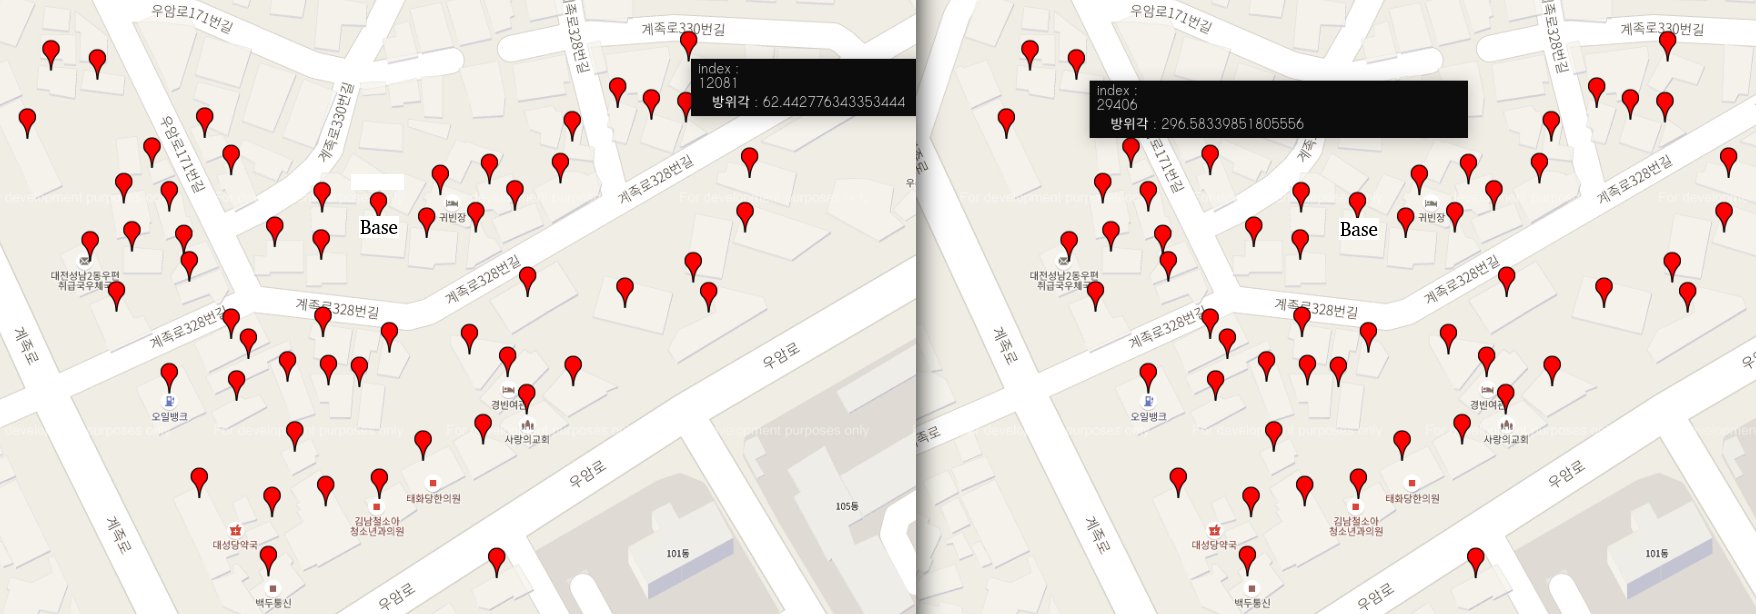

In [30]:
print("> Base를 기준으로 방위각 60도 에서 300도 사이의 값들만 수집")
Image("./image/presentation/azimuthVal.png")

# 2.5 인접 건물 최대 앙각, 건물 수, 높이

* x,y 좌표로 기준 건물과 인접 건물간의 방위각을 구함 
* 방위각을 3분할을 해서 각 영역에 해당하는 인접 건물들과의 높이 중 최대값, 앙각 중 최대값, 영역 안의 건물 수, 평균 높이, 평균 층 수 계산

> 총 240도를 80도로 3등분


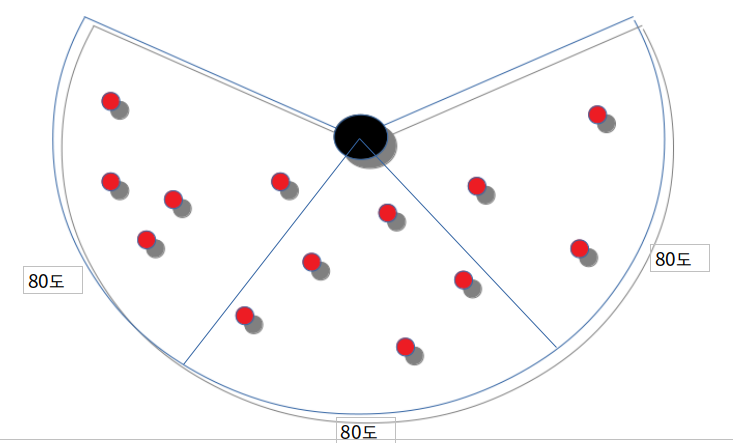

In [31]:
print("> 총 240도를 80도로 3등분")
Image("./image/presentation/nearBuild80.png")

## 2.5.1 3분할 파생 데이터 계산

* <font color='red'>반지름까지 고려해서 구하는 앙각을 추가 해야함</font>

In [32]:
def derivedData(build_data,realnearest_ind_list , realnearest_dist_list) :
    
    xylocation = pd.DataFrame()
    xylocation['tm_x'] = build_data['tm_x']
    xylocation['tm_y'] = build_data['tm_y']

    xylocation_list = xylocation.values.tolist()
    xylocation_np = array(xylocation_list)
    
    start = time.time()

    maxAngle_list = []
    relHeight_list = []
    relFloor_list = []

    angle80_angle = [] 
    angle160_angle = []  
    angle240_angle = [] 

    angle80_count = []
    angle160_count = []
    angle240_count = []

    angle80_height = []
    angle160_height = []
    angle240_height = []

    angle80_lenangle = [] 
    angle160_lenangle = []
    angle240_lenangle = []

    a = pd.DataFrame()
    nearsum = 0
    for i in range(len(xylocation_np)) :
    # for i in range(1) :

        if i%10000 == 0 :
            print(i)

        nowBuild = build_data.iloc[i]
        nearBuild = build_data.iloc[realnearest_ind_list[i]]

        # 반지름까지 고려해서 계산하는 코드 밑
#         print("-"*20)
#         print(np.array(realnearest_dist_list[i]))
#         print(nearBuild['buld_length'] + nowBuild['buld_length'])
#         print(np.array(realnearest_dist_list[i]) - nearBuild['buld_length'] - nowBuild['buld_length'] )
        
        re_height = (nearBuild['height'] - nowBuild['height']).apply(lambda x : max(x,0))
        re_angle = np.arctan2(re_height , np.array(realnearest_dist_list[i])) * 180 /  np.pi
        re_lenangle = np.arctan2(re_height , np.array(realnearest_dist_list[i])) * 180 /  np.pi

        # 주변 최대각도 , 상대 건물 수 , 상대 높이 
        relFloor_list.append((nearBuild['gro_flo_co'] - nowBuild['gro_flo_co']).apply(lambda x : max(x,0)).replace(0,np.NaN).mean())
        relHeight_list.append((nearBuild['height'] - nowBuild['height']).apply(lambda x : max(x,0)).replace(0,np.NaN).mean())
        maxAngle_list.append(max(re_angle))

        # 주변건물들과 x,y 좌표로 각도를 계산
        nearbuilds_angle = np.arctan2((nowBuild['tm_y']-nearBuild['tm_y']) ,(nowBuild['tm_x'] - nearBuild['tm_x'] )) * 180 /  np.pi

        angle80_df = nearbuilds_angle.loc[(-30<nearbuilds_angle) * (nearbuilds_angle<50)]
        angle160_df = nearbuilds_angle.loc[(50<=nearbuilds_angle) & (nearbuilds_angle<130)]
        angle240_df = nearbuilds_angle.loc[(nearbuilds_angle>=130) | (nearbuilds_angle<-150)]

        a = len(angle80_df) + len(angle160_df) + len(angle240_df) 
        if a != len(nearBuild) :
            print("오류발생")
            break

        if angle80_df.any() :

            t = re_angle.loc[angle80_df.index]

            angle80_angle.append(re_angle.loc[angle80_df.index].max())    
            angle80_count.append(len(angle80_df))
            angle80_height.append(nearBuild.loc[angle80_df.index]['height'].mean())

        else :
            angle80_angle.append(0)
            angle80_count.append(0)
            angle80_height.append(0)

        if angle160_df.any() :

            t = re_angle.loc[angle160_df.index]

            angle160_angle.append(re_angle.loc[angle160_df.index].max())
            angle160_count.append(len(angle160_df))
            angle160_height.append(nearBuild.loc[angle160_df.index]['height'].mean())

        else :
            angle160_angle.append(0)
            angle160_count.append(0)
            angle160_height.append(0)

        if angle240_df.any() :

            t = re_angle.loc[angle240_df.index]

            angle240_angle.append(re_angle.loc[angle240_df.index].max())
            angle240_count.append(len(angle240_df))
            angle240_height.append(nearBuild.loc[angle240_df.index]['height'].mean())

        else :
            angle240_angle.append(0)
            angle240_count.append(0)
            angle240_height.append(0)


    print(len(maxAngle_list))
    
    build_data['rad_angle_max'] = maxAngle_list
    build_data['rad_rel_fl'] = relFloor_list
    build_data['rad_rel_height'] = relHeight_list

    build_data['rad_rel_fl'] = build_data['rad_rel_fl'].fillna(0)
    build_data['rad_rel_height'] = build_data['rad_rel_height'].fillna(0)

    build_data['rad_angle_max_80'] = angle80_angle
    build_data['rad_angle_max_160'] = angle160_angle
    build_data['rad_angle_max_240'] = angle240_angle

    build_data['count_80'] = angle80_count
    build_data['count_160'] = angle160_count
    build_data['count_240'] = angle240_count

    build_data['height_80'] = angle80_height
    build_data['height_160'] = angle160_height
    build_data['height_240'] = angle240_height
    
    print("time :", time.time() - start) 

    return build_data
build_data = derivedData(build_data,realnearest_ind_list , realnearest_dist_list)

build_data.to_csv("./data/2.5/build_data_3group_80100.csv",  index=False,encoding='utf-8')

0


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
147754
time : 1308.471496105194


## 2.5.2 높이, 앙각 계산 검증

* 빌딩 데이터, 원하는 인접 빌딩 반경미터 리스트, 인접 빌딩 인덱스 리스트, 보고싶은 빌딩의 인덱스, 계산에 사용한 반경미터 를 입력
    * 위에서 계산한 2.4.1 인접 빌딩 수집의 결과 리스트들인 **반경미터 리스트, 인덱스 리스트**
* matplolib으로 입체적으로 그려줌



## buildNear_3d

Base Building gid :  0    45276
Name: gid, dtype: object
최대앙각 index  93412
주위 건물 수 :  31
rad_angle_max :  5.537418069968963
rad_angle_max_80 :  0.0
rad_angle_max_160 :  5.537418069968963
rad_angle_max_240 :  0.0
count_80 :  14.0
count_160 :  16.0
count_240 :  1.0


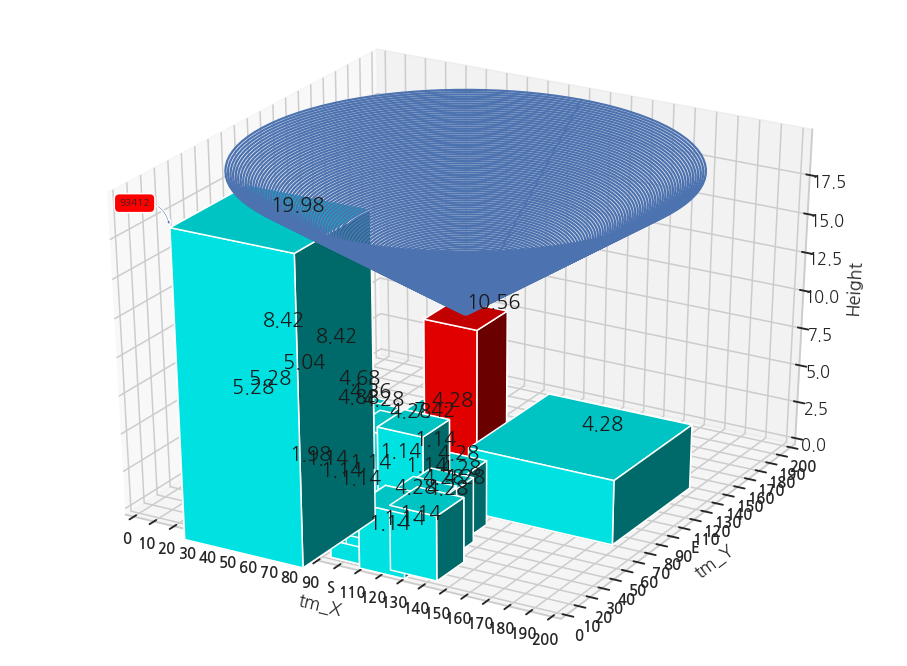

In [33]:
%matplotlib qt5
# %matplotlib inline  
def buildNear_3d (build_data , realnearest_dist_list , realnearest_ind_list ,buildIndex , meter) :  # meter에는 근처 몇미터까지 쟀는지가 나와있다.

    
    build_data['tm_x'] = build_data['tm_x'].astype(float)
    build_data['tm_y'] = build_data['tm_y'].astype(float)
    
    fig = plt.figure(figsize=(16,12))
    ax = plt.axes(projection="3d")
    
    # 축 설정 
    plt.xlim([0,meter*2])
    ticksx =list(range(0, meter*2+10, 10))
    ticksx[round(len(ticksx)/2)] = "S"  
    plt.xticks(np.arange(0, meter*2+10, 10), ticksx , weight='bold' , fontsize=15)
    
    ticksy =list(range(0, meter*2+10, 10))
    ticksy[round(len(ticksx)/2)] = "E"  
    plt.yticks(np.arange(0, meter*2+10, 10), ticksy , weight='bold' , fontsize=15)
    plt.ylim([0,meter*2])
    
    ax.set_xlabel('\ntm_X')
    ax.set_ylabel('\ntm_Y')
    ax.set_zlabel('\nHeight')
    
        
        
    baseBuild = pd.DataFrame(columns = build_data.columns)
    baseBuild.loc[0] = build_data.loc[buildIndex]
    print("Base Building gid : " , baseBuild['gid'])
    
    nearBuild = build_data.loc[realnearest_ind_list[buildIndex]][['tm_x','tm_y' , 'height','buld_length']]
    num_bars = len(nearBuild)

    
    # 건물간의 높이차로 인한 각도를 계산하는 코드
    re_height = (nearBuild['height'] - float(baseBuild['height'])).apply(lambda x : max(x,0))
    
    re_angle = np.arctan2(re_height , np.array(realnearest_dist_list[buildIndex])) * 180 /  np.pi
    
    angle_dict = dict(zip(realnearest_ind_list[buildIndex], re_angle))
    maxAngle_ind = max(angle_dict, key=angle_dict.get)
    
    
    # 원뿔의 높이 
    coneHeight = nearBuild['height'].max() - baseBuild['height']
    
    
    # x y 좌표를 건물 넓이를 포함하여 중간 지점으로 오게 하기 위해
    nearBuild['tm_x'] = nearBuild['tm_x'] - float(baseBuild['tm_x']) + meter - nearBuild['buld_length']
    nearBuild['tm_y'] = nearBuild['tm_y'] - float(baseBuild['tm_y']) + meter - nearBuild['buld_length']
    
    
    # 최소 높이 값으로 빼서 높이 스케일링
    zrange = list(baseBuild['height']) + list(nearBuild['height'])
    nearBuild['height'] = nearBuild['height'] - round(min(zrange) - 1)
    baseBuild['height'] = baseBuild['height'] - round(min(zrange) - 1)
    
    # nearBuild 들 좌표 넣기
    x_pos = list(nearBuild['tm_x'])
    y_pos = list(nearBuild['tm_y'])
    z_pos = [0] * num_bars

    x_size = list(nearBuild['buld_length']*2)
    y_size = list(nearBuild['buld_length']*2)
    z_size = list(nearBuild['height'])

    # baseBuild 좌표 넣기
    basePoint = meter - float(baseBuild['buld_length'])
    
    x_pos.append(basePoint)
    y_pos.append(basePoint)
    z_pos.append(0)
    x_size.append(float(baseBuild['buld_length'])*2)
    y_size.append(float(baseBuild['buld_length'])*2)
    z_size.append(float(baseBuild['height']))

    
    colors = ['aqua'] * num_bars
    colors.append('red')

    # text 좌표
    x_text_pos = list(nearBuild['tm_x'] + nearBuild['buld_length'])
    y_text_pos = list(nearBuild['tm_y'] + nearBuild['buld_length'])
    x_text_pos.append(meter)
    y_text_pos.append(meter)
    height_text = list(map( lambda x : round(x,2) , z_size))  # 높이가 길어서 소수점밑 2까지만
    
    ax.bar3d(x_pos, y_pos, z_pos, x_size, y_size, z_size, color = colors)
 
    nearBuild.loc[maxAngle_ind]['height']
    
    # 높이 text annotation
    for i in range(len(x_pos)) :  
        ax.text(x_text_pos[i],y_text_pos[i],z_size[i]+0.5,  height_text[i], size=20, zorder=2,  color='k') 
    
    
    # 최대각도의 index를 annotaiton
    maxRadBuild = nearBuild.loc[maxAngle_ind]
        
    x2, y2, _ = proj3d.proj_transform(maxRadBuild['tm_x'],maxRadBuild['tm_y'],maxRadBuild['height'], ax.get_proj())

    label = pylab.annotate(
        str(maxAngle_ind), 
        xy = (x2, y2), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 1),
        arrowprops = dict(arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.5"))

    def update_position(e):
        x2, y2, _ = proj3d.proj_transform(maxRadBuild['tm_x'],maxRadBuild['tm_y'],maxRadBuild['height'], ax.get_proj())
        label.xy = x2,y2
        label.update_positions(fig.canvas.renderer)
        fig.canvas.draw()
    fig.canvas.mpl_connect('button_release_event', update_position)
    pylab.show()
    
    

    # 최대각도 부분을 원뿔로 그림
    # tan 값이 기울기가 나오게하는 높이값을 찾고 그대로 그림
    z = np.arange(0, ceil(coneHeight)*10, 1)  # 두번째 인자가 반지름값 , 세번째 인자는  많아지면 선이 많아지는거  , ceil(coneHeight) 저거는 바꿔야 할 수도 
    theta = np.arange(0, 2 * pi + pi / 50, pi / 50)  # 이 나누는 수가 적으면 원같지 않음
    
    for zval in z:
        # 원뿔의 총 높이가 최고 높이보다는 크면 멈추게
        if zval * tan(angle_dict[maxAngle_ind] * pi / 180) + float(baseBuild['height']) > nearBuild['height'].max() :
            break
        
        x = zval * np.array([sin(q) for q in theta])
        y = zval * np.array([cos(q) for q in theta])
        ax.plot(x + meter, y + meter, zval * tan(angle_dict[maxAngle_ind] * pi / 180) + baseBuild['height'], 'b-')  # 이거하나가 줄 하나

            

    plt.show()
    
    print("최대앙각 index " , maxAngle_ind)
    print("주위 건물 수 : " , num_bars)
    print("rad_angle_max : " , float(baseBuild['rad_angle_max']))
    print("rad_angle_max_80 : " , float(baseBuild['rad_angle_max_80']))
    print("rad_angle_max_160 : " , float(baseBuild['rad_angle_max_160']))
    print("rad_angle_max_240 : " , float(baseBuild['rad_angle_max_240']))
    print("count_80 : " , float(baseBuild['count_80']))
    print("count_160 : " , float(baseBuild['count_160']))
    print("count_240 : " , float(baseBuild['count_240']))
    
buildNear_3d(build_data ,realnearest_dist_list , realnearest_ind_list , 920 , 100)


> 위 코드 실행 화면


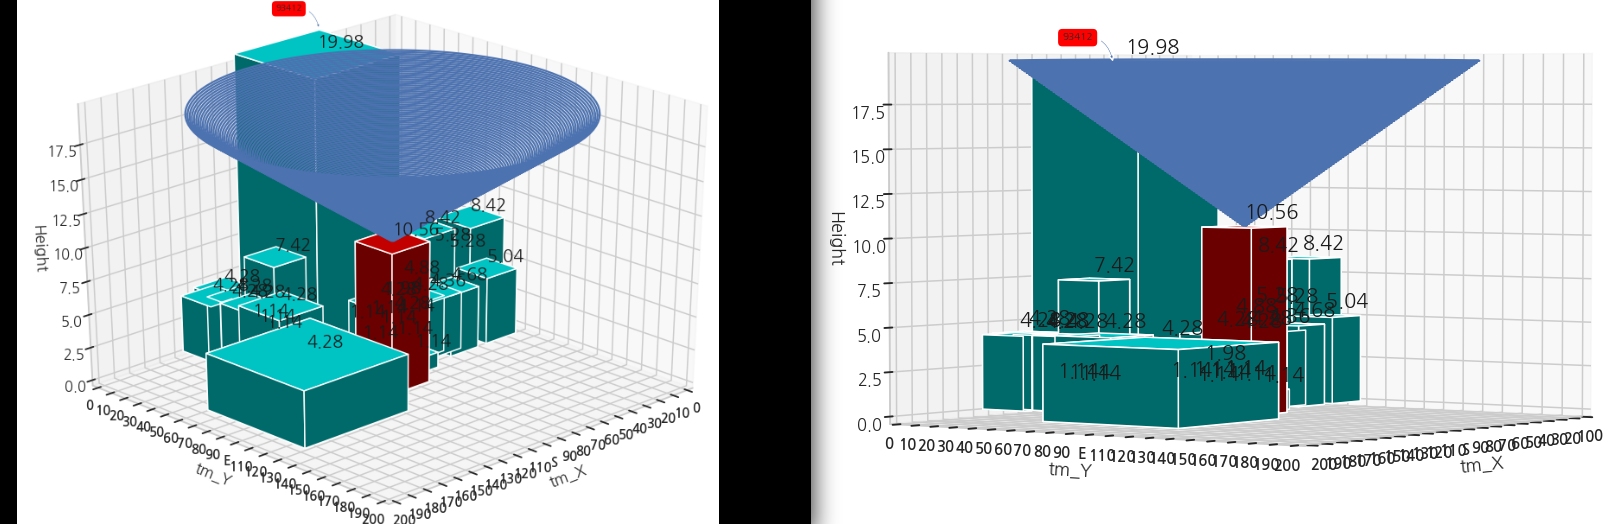

In [34]:
print("> 위 코드 실행 화면")
Image("./image/presentation/buildNear.png")

In [35]:
build_data = pd.read_csv("./data/2.5/build_data_3group_80100.csv" )

# 모든 태양 위치에 기준점은 충남대학교

* 충남대학교에서의 시간당 고도 , 방위각 , 일출 일몰 시간 등등..

# 2.6 근처 건물들의 그림자 길이

* 인접 건물들의 그림자 영향에 따른 차폐율을 찾고 싶은거니까, 주변 건물의 그림자 길이를 계산하여 변수로 사용
* 해당 달의 태양의 최고 고도와 건물의 높이로 이 건물의 그림자 길이를 계산 ( 여기선 6월로 고정 )
    * <font color='red'>모든 위치의 건물에 태양의 최고 고도로 그림자의 길이를 계산하기 때문에 오차가 발생한 듯, 개선 필요</font>



* 밑의 그림과 같이 태양의 고도와 건물의 높이를 안다면 그림자의 길이를 계산할 수 있다.
    
![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQlefEPNlpg4HnKRP02AUszLMtBk8ECa_GpkFa2c0YMkQNj2KCAtQ)

## 2.6.1 2019년 모든날 태양이 떠있는 시간 , 이동 방위각 계산

* 모든 날의 일출 일몰 시간 크롤링 (https://astro.kasi.re.kr/life/pageView/9?lat=36.362530384433434&lng=127.34486028545953&date=2019-06-22&address=%EB%8C%80%EC%A0%84%EA%B4%91%EC%97%AD%EC%8B%9C+%EC%9C%A0%EC%84%B1%EA%B5%AC+%EB%8C%80%ED%95%99%EB%A1%9C+99)
* pysolar를 이용하여 모든날의 태양 떠있는 시간 , 일몰 방위각 , 일출 방위각 , 이동 방위각 계산
* 월 별로 평균


### 참고 

* timezone : https://spoqa.github.io/2019/02/15/python-timezone.html

In [7]:
sunTime_data = pd.read_csv('./data/solar/sunTime_data.csv')

print("> DF 길이:",len(sunTime_data))
sunTime_data.head(10)

> DF 길이: 365


year  month  day  sunrise   sunset
0  2019      1    1  07시 42분  17시 25분
1  2019      1    2  07시 42분  17시 26분
2  2019      1    3  07시 42분  17시 27분
3  2019      1    4  07시 42분  17시 27분
4  2019      1    5  07시 42분  17시 28분
5  2019      1    6  07시 42분  17시 29분
6  2019      1    7  07시 42분  17시 30분
7  2019      1    8  07시 42분  17시 31분
8  2019      1    9  07시 42분  17시 32분
9  2019      1   10  07시 42분  17시 33분

In [6]:
KST = datetime.timezone(datetime.timedelta(hours=9))

ssAzi_list = []
srAzi_list = []
dayAzi_list = []
date_list = []
dayHour_list =[]

for i in range(len(sunTime_data)) :
    baseDate = sunTime_data.iloc[i]

    year = baseDate.year 
    month = baseDate.month 
    day = baseDate.day 


    ssHour , ssMin = list(map(lambda x : int(x[:-1]) ,baseDate.sunset.split()))

    srHour , srMin = list(map(lambda x : int(x[:-1]) ,baseDate.sunrise.split()))


    ssDate = datetime.datetime(baseDate.year , baseDate.month , baseDate.day , ssHour , ssMin , 0, 0, tzinfo=KST)
    srDate = datetime.datetime(baseDate.year , baseDate.month , baseDate.day , srHour , srMin , 0, 0, tzinfo=KST)
    
    date_list.append(datetime.datetime(baseDate.year , baseDate.month , baseDate.day))
    ssAzi_list.append(get_azimuth(36.3679381,127.3442986, srDate))
    srAzi_list.append(get_azimuth(36.3679381,127.3442986, ssDate))
    dayAzi_list.append(get_azimuth(36.3679381,127.3442986, ssDate) - get_azimuth(36.3679381,127.3442986, srDate))
    dayHour_list.append((ssDate - srDate))

azi_df = pd.DataFrame({'time' : date_list ,'dayHour' : dayHour_list,  'ssAzimuth' : ssAzi_list , 'srAzimuth' : srAzi_list , 'dayAzimuth' : dayAzi_list})

print("> DF 길이 :",len(azi_df))
azi_df.head(10)

/usr/local/lib/python3.6/dist-packages/pysolar/solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


> DF 길이 : 365


time  dayHour   ssAzimuth   srAzimuth  dayAzimuth
0 2019-01-01 09:43:00  118.381596  241.542061  123.160465
1 2019-01-02 09:44:00  118.249296  241.685158  123.435862
2 2019-01-03 09:45:00  118.111590  241.834941  123.723351
3 2019-01-04 09:45:00  117.968853  241.844409  123.875556
4 2019-01-05 09:46:00  117.821196  242.007785  124.186589
5 2019-01-06 09:47:00  117.668732  242.178016  124.509285
6 2019-01-07 09:48:00  117.511573  242.355152  124.843578
7 2019-01-08 09:49:00  117.349834  242.539234  125.189399
8 2019-01-09 09:50:00  117.183628  242.730299  125.546671
9 2019-01-10 09:51:00  117.013067  242.928377  125.915311

In [38]:
azi_df['month'] = azi_df['time'].apply(lambda x : "sun"+str(x)[5:7])
azi_df['daySecond'] = azi_df['dayHour'].apply(lambda x : x.total_seconds() / 60)
azi_df
monthlySun_df = azi_df.groupby(['month']).mean()
monthlySun_df

ssAzimuth   srAzimuth  dayAzimuth   daySecond
month                                                
sun01  115.389027  244.528968  129.139941  599.419355
sun02  105.435214  254.574452  149.139238  650.714286
sun03   91.743389  268.296445  176.553056  716.935484
sun04   77.288749  282.727924  205.439175  786.300000
sun05   65.720600  294.246265  228.525665  845.258065
sun06   60.149417  299.728561  239.579144  875.500000
sun07   62.538505  297.253417  234.714912  862.161290
sun08   72.070118  287.663508  215.593390  812.032258
sun09   85.545584  274.173296  188.627712  746.100000
sun10  100.011629  259.736581  159.724953  676.935484
sun11  112.204407  247.597756  135.393349  616.033333
sun12  118.223981  241.597457  123.373476  584.000000

## 2.6.2 그 월의 평균 최대 고도

* 매일 방위각 10도당 시간과 태양의 고도를 구한뒤 매일 최대 고도의 평균값을 월 평균 최대 고도로 
    * <font color='red'>너무 느림 ,개선 필요 (하루 태양 고도 , 방위각 을 알려주는 사이트가 있으니까 그냥 긁어와도 괜찮을 듯)</font>

In [39]:
# 충남대학교에서의 해당 월의 방위각과 고도 
def getAziAlt(month , day) :
    
    # 영국 기준이라서 한국은 9를 더해줘야함 , timezone 설정 안하면 pysolar 못씀
    KST = datetime.timezone(datetime.timedelta(hours=9))
    date = datetime.datetime(2019, month, day, 0, 0, 0, 0, tzinfo=KST)
    enddate = date + datetime.timedelta(days=1)

    time_list = []
    alt_list = []
    azi_list = []
    stand = int(get_azimuth(36.3679381,127.3442986, date)/10)
    
    # 1분단위로 체크하면서 방위각이 10도단위로 바뀔때마다의 방위각과 고도를 체크
    while date < enddate  :
        now = int(get_azimuth(36.3679381,127.3442986, date)/10)
        
        if stand != now :
            
                stand =  int(get_azimuth(36.3679381,127.3442986, date)/10)
                time_list.append(date.strftime("%Y-%m-%d-%H-%M"))
                alt_list.append(get_altitude(36.3679381,127.3442986 , date))
                azi_list.append(get_azimuth(36.3679381,127.3442986, date))
        
        date = date+datetime.timedelta(minutes=1)
    
    return pd.DataFrame({'time' : time_list , 'azimuth' : azi_list , 'altitude' : alt_list})
    

        
azialt_df = pd.DataFrame(columns = ['time','azimuth' , 'altitude'])

for month in range(1,13) :
#     print(month)
    for day in range(1, calendar.monthrange(2019, month)[1] + 1) :
        azialt_df = pd.concat([ azialt_df,getAziAlt(month,day)])

azialt_df.loc[azialt_df['altitude'] == azialt_df['altitude'].max()]

/usr/local/lib/python3.6/dist-packages/pysolar/solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


time     azimuth   altitude
18  2019-06-22-12-33  180.555388  77.069423

In [40]:
azialt_df['month'] = azialt_df['time'].apply(lambda x : "sun"+x[5:7])
azialt_df['date'] = azialt_df['time'].apply(lambda x : x[5:10])

# 그날의 최대 고도들을 뽑아내고
daily_df = azialt_df[azialt_df.groupby(['date'])['altitude'].transform(max) == azialt_df['altitude']].sort_values(['date'])

# daily 최대 고도들을 month로 묶어서 평균
monthlyAlt_df = daily_df.groupby(['month']).mean()


monthlyAll_df = pd.concat([monthlyAlt_df['altitude'],monthlySun_df] , axis=1)

monthlyAll_df.to_csv("./data/solar/montlySolar.csv" )

monthlyAll_df

altitude   ssAzimuth   srAzimuth  dayAzimuth   daySecond
month                                                           
sun01  32.922185  115.389027  244.528968  129.139941  599.419355
sun02  40.796738  105.435214  254.574452  149.139238  650.714286
sun03  51.771304   91.743389  268.296445  176.553056  716.935484
sun04  63.352836   77.288749  282.727924  205.439175  786.300000
sun05  72.436378   65.720600  294.246265  228.525665  845.258065
sun06  76.690152   60.149417  299.728561  239.579144  875.500000
sun07  74.809500   62.538505  297.253417  234.714912  862.161290
sun08  67.337235   72.070118  287.663508  215.593390  812.032258
sun09  56.582371   85.545584  274.173296  188.627712  746.100000
sun10  44.987479  100.011629  259.736581  159.724953  676.935484
sun11  35.348526  112.204407  247.597756  135.393349  616.033333
sun12  30.672813  118.223981  241.597457  123.373476  584.000000

In [41]:
monthlyAll_df = pd.read_csv("./data/solar/montlySolar.csv")
monthlyAll_df = monthlyAll_df.set_index("month")
monthlyAll_df

altitude   ssAzimuth   srAzimuth  dayAzimuth   daySecond
month                                                           
sun01  32.922185  115.389027  244.528968  129.139941  599.419355
sun02  40.796738  105.435214  254.574452  149.139238  650.714286
sun03  51.771304   91.743389  268.296445  176.553056  716.935484
sun04  63.352836   77.288749  282.727924  205.439175  786.300000
sun05  72.436378   65.720600  294.246265  228.525665  845.258065
sun06  76.690152   60.149417  299.728561  239.579144  875.500000
sun07  74.809500   62.538505  297.253417  234.714912  862.161290
sun08  67.337235   72.070118  287.663508  215.593390  812.032258
sun09  56.582371   85.545584  274.173296  188.627712  746.100000
sun10  44.987479  100.011629  259.736581  159.724953  676.935484
sun11  35.348526  112.204407  247.597756  135.393349  616.033333
sun12  30.672813  118.223981  241.597457  123.373476  584.000000

## 2.6.3 빌딩의 그림자 길이 계산


In [42]:
build_data['shadowLength'] = build_data['height'] / np.tan(np.deg2rad(monthlyAll_df.loc['sun06']['altitude']))
build_data.head()

gid  buld_se_cd buld_se_nm  bdtyp_cd apt_yn  gro_flo_co  sig_cd sig_nm  \
0  24300           0         지상      4299      N           1   30110     동구   
1  16295           0         지상      1001      N           1   30110     동구   
2  24341           0         지상      1001      N           1   30110     동구   
3  24345           0         지상      4402      N           1   30110     동구   
4  24374           0         지상     18999      N           1   30110     동구   

     emd_cd emd_nm           tm_x           tm_y         lon        lat  \
0  30110137    대별동  241302.419829  409864.414379  127.459746  36.285880   
1  30110105    가오동  240815.012971  412384.958080  127.454453  36.308615   
2  30110137    대별동  241460.822384  410090.945431  127.461521  36.287914   
3  30110137    대별동  241530.222973  410067.763075  127.462293  36.287703   
4  30110137    대별동  241500.967911  409605.204042  127.461942  36.283535   

    buld_area  buld_elev      sL01      sL02      sL03      sL04      sL05  \
0  199.109760       80.0  0.204715  0.217257  0.205812  0.184260  0.153714   
1   77.392318       71.0  0.295631  0.231582  0.193751  0.177985  0.176701   
2   91.076386       77.0  0.195469  0.200133  0.191029  0.185189  0.171563   
3   51.201706       78.0  0.371389  0.378444  0.366326  0.342754  0.316217   
4  455.844167       80.0  0.131596  0.138417  0.124781  0.116576  0.102620   

       sL06      sL07      sL08      sL09      sL10      sL11      sL12  \
0  0.139599  0.138983  0.163898  0.196457  0.204533  0.213280  0.208075   
1  0.178177  0.185056  0.182143  0.187676  0.211802  0.252642  0.330147   
2  0.164108  0.155892  0.172701  0.185788  0.188739  0.196957  0.201032   
3  0.304955  0.310306  0.327509  0.357109  0.368799  0.378022  0.374364   
4  0.095113  0.086709  0.104519  0.118837  0.127436  0.138503  0.138233   

     sL_y17  buld_length  buld_height  height  rad_angle_max  rad_rel_fl  \
0  0.180697    15.922136         3.14   83.14       5.011625    1.000000   
1  0.205046     9.926679         3.14   74.14      35.570123    2.473684   
2  0.181562    10.768568         3.14   80.14       5.080622    1.333333   
3  0.344058     8.074159         3.14   81.14       1.555146    0.000000   
4  0.115303    24.091468         3.14   83.14       7.164204    1.000000   

   rad_rel_height  rad_angle_max_80  rad_angle_max_160  rad_angle_max_240  \
0        1.587692          0.902407           5.011625           0.000000   
1        6.327369          1.182603          35.570123          15.608649   
2        2.356000          5.080622           4.332678           3.259005   
3        1.000000          0.000000           1.555146           0.000000   
4        2.859999          1.343876           3.126923           7.164204   

   count_80  count_160  count_240  height_80  height_160  height_240  \
0        11          9          6  83.874546   84.186667   82.306667   
1        14         20          5  73.260000   77.880000   80.340001   
2         1          4          6  84.280000   82.710000   81.663333   
3         3          4          0  81.140000   81.640000    0.000000   
4         1          1          2  84.140000   85.099999   87.379998   

   shadowLength  
0     19.668552  
1     17.539409  
2     18.958838  
3     19.195409  
4     19.668552

## 2.6.4 주변 빌딩의 그림자 길이 계산

* scaledShadow : 근처 n미터 안에 있는 건물들의 그림자 길이인데, n미터가 넘어가는것은 n미터로 보정해준 그림자 길이
* nearShadow : 근방에 있는 건물들의 그림자 길이의 총합
* rel_nearShadow : 그림자길이 / 건물간의 길이. 즉, 1보다 크면 영향을 끼치는 건물들


* <font color='red'> 개선 필요 (주변 빌딩의 그림자 길이를 모두 합하는게 아니라 기준 빌딩의 높이보다 높은 건물들만 더해야 할거 같음 )</font>

In [43]:
def derivedNearShadow(build_data,realnearest_ind_list , realnearest_dist_list , meter) :
    
    xylocation = pd.DataFrame()
    xylocation['tm_x'] = build_data['tm_x']
    xylocation['tm_y'] = build_data['tm_y']

    xylocation_list = xylocation.values.tolist()
    xylocation_np = array(xylocation_list)
    
    nearShadow = []
    nearScaledShadow = []
    rel_nearShadow = []
    rel_nearScaledShadow = []
    
    
    build_data['scaledshadowLength'] = build_data['shadowLength'].apply(lambda x : min(x,meter))
    
    start = time.time()

    a = pd.DataFrame()
    nearsum = 0
    for i in range(len(xylocation_np)) :

#         if i%10000 == 0 :
#             print(i)

        nowBuild = build_data.iloc[i]
        nearBuild = build_data.iloc[realnearest_ind_list[i]]
        
        if [i] == realnearest_ind_list[i] :
            nearShadow.append(0)
            nearScaledShadow.append(0)
            rel_nearShadow.append(0)
            rel_nearScaledShadow.append(0)
        
        else :
            
            
            nearShadow.append(nearBuild['shadowLength'].sum())
            nearScaledShadow.append(nearBuild['scaledshadowLength'].sum())
            
        
            rel_nearShadow.append((nearBuild['shadowLength'].values/realnearest_dist_list[i]).sum())
            rel_nearScaledShadow.append((nearBuild['scaledshadowLength'].values/realnearest_dist_list[i]).sum())
            # 주변에 아무 빌딩도 없으면 자기 자신을 넣게 해놨기 떄문에 자기자신은 빼줘야 함
        
    build_data['nearShadow'] = nearShadow
    build_data['nearScaledShadow'] = nearScaledShadow
    build_data['rel_nearShadow'] = rel_nearShadow
    build_data['rel_nearScaledShadow'] = rel_nearScaledShadow
    
    print("time :", time.time() - start) 

    return build_data

build_data = derivedNearShadow(build_data,realnearest_ind_list , realnearest_dist_list , 100)

time : 121.92092823982239


In [44]:
del build_data['shadowLength']
del build_data['scaledshadowLength']

build_data.head()

gid  buld_se_cd buld_se_nm  bdtyp_cd apt_yn  gro_flo_co  sig_cd sig_nm  \
0  24300           0         지상      4299      N           1   30110     동구   
1  16295           0         지상      1001      N           1   30110     동구   
2  24341           0         지상      1001      N           1   30110     동구   
3  24345           0         지상      4402      N           1   30110     동구   
4  24374           0         지상     18999      N           1   30110     동구   

     emd_cd emd_nm           tm_x           tm_y         lon        lat  \
0  30110137    대별동  241302.419829  409864.414379  127.459746  36.285880   
1  30110105    가오동  240815.012971  412384.958080  127.454453  36.308615   
2  30110137    대별동  241460.822384  410090.945431  127.461521  36.287914   
3  30110137    대별동  241530.222973  410067.763075  127.462293  36.287703   
4  30110137    대별동  241500.967911  409605.204042  127.461942  36.283535   

    buld_area  buld_elev      sL01      sL02      sL03      sL04      sL05  \
0  199.109760       80.0  0.204715  0.217257  0.205812  0.184260  0.153714   
1   77.392318       71.0  0.295631  0.231582  0.193751  0.177985  0.176701   
2   91.076386       77.0  0.195469  0.200133  0.191029  0.185189  0.171563   
3   51.201706       78.0  0.371389  0.378444  0.366326  0.342754  0.316217   
4  455.844167       80.0  0.131596  0.138417  0.124781  0.116576  0.102620   

       sL06      sL07      sL08      sL09      sL10      sL11      sL12  \
0  0.139599  0.138983  0.163898  0.196457  0.204533  0.213280  0.208075   
1  0.178177  0.185056  0.182143  0.187676  0.211802  0.252642  0.330147   
2  0.164108  0.155892  0.172701  0.185788  0.188739  0.196957  0.201032   
3  0.304955  0.310306  0.327509  0.357109  0.368799  0.378022  0.374364   
4  0.095113  0.086709  0.104519  0.118837  0.127436  0.138503  0.138233   

     sL_y17  buld_length  buld_height  height  rad_angle_max  rad_rel_fl  \
0  0.180697    15.922136         3.14   83.14       5.011625    1.000000   
1  0.205046     9.926679         3.14   74.14      35.570123    2.473684   
2  0.181562    10.768568         3.14   80.14       5.080622    1.333333   
3  0.344058     8.074159         3.14   81.14       1.555146    0.000000   
4  0.115303    24.091468         3.14   83.14       7.164204    1.000000   

   rad_rel_height  rad_angle_max_80  rad_angle_max_160  rad_angle_max_240  \
0        1.587692          0.902407           5.011625           0.000000   
1        6.327369          1.182603          35.570123          15.608649   
2        2.356000          5.080622           4.332678           3.259005   
3        1.000000          0.000000           1.555146           0.000000   
4        2.859999          1.343876           3.126923           7.164204   

   count_80  count_160  count_240  height_80  height_160  height_240  \
0        11          9          6  83.874546   84.186667   82.306667   
1        14         20          5  73.260000   77.880000   80.340001   
2         1          4          6  84.280000   82.710000   81.663333   
3         3          4          0  81.140000   81.640000    0.000000   
4         1          1          2  84.140000   85.099999   87.379998   

   nearShadow  nearScaledShadow  rel_nearShadow  rel_nearScaledShadow  
0  514.339502        514.339502       10.375585             10.375585  
1  706.151655        706.151655       16.730038             16.730038  
2  214.120840        214.120840        3.661072              3.661072  
3  134.841008        134.841008        4.020769              4.020769  
4   81.380586         81.380586        1.843745              1.843745

## 2.7 태양의 고도 보다 높은 건물들 개수

* 방위각 10도 당 영역을 나누고 그 영역의 태양의 고도 보다 높은 건물의 수 카운트
    * <u>방위각 10도 당 영향을 주는 건물의 개수를 변수로 두면 각 방위각에서의 태양의 세기가 다르니 일사량에도 다르게 영향을 줄 텐데, 이 값까지 학습 할 수 있지 않을까</u>

### 2.7.1 방위각 , 고도 

* 6월 한달 동안 모든 날짜에서 방위각 10도 마다의 고도 데이터 계산 
* 6월의 방위각 당 평균 고도를 14일 날의 고도로 사용
* pysolar를 사용


* #### 방위각과 고도의 계산을 밑의 사이트에서 방위각과 고도로 검증 

https://astro.kasi.re.kr/life/pageView/10?useElevation=1&lat=36.362530384433434&lng=127.34486028545953&elevation=-117.25547986247638&output_range=1&date=2018-06-22&hour=&minute=&second=&address=%EB%8C%80%EC%A0%84%EA%B4%91%EC%97%AD%EC%8B%9C+%EC%9C%A0%EC%84%B1%EA%B5%AC+%EB%8C%80%ED%95%99%EB%A1%9C+99 

In [45]:
# 해당 월의 방위각과 고도 계산
def getAziAlt(month , day) :
    
    # 영국 기준이라서 한국은 9를 더해줘야함 , timezone 설정 안하면 pysolar 못씀
    KST = datetime.timezone(datetime.timedelta(hours=9))
    date = datetime.datetime(2019, month, day, 0, 0, 0, 0, tzinfo=KST)
    enddate = date + datetime.timedelta(days=1)

    time_list = []
    alt_list = []
    azi_list = []
    stand = int(get_azimuth(36.3679381,127.3442986, date)/10)
    
    # 1분단위로 체크하면서 방위각이 10도단위로 바뀔때마다의 방위각과 고도를 체크
    while date < enddate  :
        now = int(get_azimuth(36.3679381,127.3442986, date)/10)
        
        if stand != now :
            
                stand =  int(get_azimuth(36.3679381,127.3442986, date)/10)
                time_list.append(date.strftime("%Y-%m-%d-%H-%M"))
                alt_list.append(get_altitude(36.3679381,127.3442986 , date))
                azi_list.append(get_azimuth(36.3679381,127.3442986, date))
                
        date = date+datetime.timedelta(minutes=1)
    
    return pd.DataFrame({'time' : time_list , 'azimuth' : azi_list , 'altitude' : alt_list})
    


In [46]:
azialt_df = pd.DataFrame(columns = ['time','azimuth' , 'altitude'])
for day in range(1,31) :
    azialt_df = pd.concat([ azialt_df,getAziAlt(6,day)])

azialt_df.to_csv("./data/solar/azialt_azi10.csv",  index=False)

In [47]:
# 시간 분 의 평균값까지 내고 싶었는데 , 그냥 15일꺼로 해도 괜찮을거같음.

azialt_df = pd.read_csv("./data/solar/azialt_azi10.csv")
azialt_df['group'] = azialt_df.azimuth.apply(lambda x : int(x))
azialt_df['day'] = azialt_df['time'].apply(lambda x : x[8:10])

azialtMean_df = azialt_df.loc[azialt_df['day'] == '14']
del azialtMean_df['day']

azialtMean_df.to_csv("./data/solar/azialtMean_csv", index=False ,encoding='utf-8')

azialtMean_df

time     azimuth   altitude  group
468  2019-06-14-00-31    0.096818 -30.418961      0
469  2019-06-14-01-09   10.154639 -29.732957     10
470  2019-06-14-01-48   20.099002 -27.679635     20
471  2019-06-14-02-30   30.055536 -24.089785     30
472  2019-06-14-03-17   40.071417 -18.646906     40
473  2019-06-14-04-11   50.128435 -10.940098     50
474  2019-06-14-05-13   60.082429  -0.113958     60
475  2019-06-14-06-24   70.046794  12.326709     70
476  2019-06-14-07-41   80.088138  27.244326     80
477  2019-06-14-08-54   90.096904  41.850899     90
478  2019-06-14-09-53  100.026882  53.664434    100
479  2019-06-14-10-37  110.257004  62.211808    110
480  2019-06-14-11-07  120.217209  67.678559    120
481  2019-06-14-11-29  130.317076  71.300012    130
482  2019-06-14-11-46  140.576532  73.706049    140
483  2019-06-14-11-59  150.249322  75.194889    150
484  2019-06-14-12-11  160.652396  76.201456    160
485  2019-06-14-12-21  170.226311  76.708990    170
486  2019-06-14-12-31  180.262042  76.876660    180
487  2019-06-14-12-41  190.285361  76.691538    190
488  2019-06-14-12-52  200.738541  76.098149    200
489  2019-06-14-13-03  210.172605  75.144873    210
490  2019-06-14-13-17  220.451361  73.512626    220
491  2019-06-14-13-34  230.492554  71.069003    230
492  2019-06-14-13-56  240.388542  67.417708    240
493  2019-06-14-14-26  250.179895  61.929482    250
494  2019-06-14-15-09  260.090888  53.567469    260
495  2019-06-14-16-09  270.146294  41.553024    270
496  2019-06-14-17-22  280.129884  26.954337    280
497  2019-06-14-18-38  290.044437  12.244122    290
498  2019-06-14-19-49  300.018850  -0.172032    300
499  2019-06-14-20-52  310.159418 -11.147499    310
500  2019-06-14-21-45  320.055920 -18.681114    320
501  2019-06-14-22-32  330.082253 -24.103154    330
502  2019-06-14-23-14  340.044706 -27.671365    340
503  2019-06-14-23-54  350.250699 -29.737401    350

위에서 구한 것은 방위각 10도 마다의 고도이고, 구하려는 것은 방위각 10도 영역 마다의 평균 고도이기 때문에 이 영역 안에서의 고도를 구하기 위해 양 끝값의 평균
> 70 ~ 80의 평균 고도 계산 = 70도의 고도 + 80도의 고도 / 2

In [48]:
# 10 ~ 20 , 30 ~ 40 을  15 , 35 로 바꾼다음 내림을 한다면 
# 10 에는 10~20의 평균값 , 30에는 30~40의 평균값이 들어감

azialtDay_df = azialtMean_df.iloc[6:31]

aziMean_list = []
altMean_list = []

prevAzi = azialtDay_df.iloc[0]['azimuth']
prevAlt = azialtDay_df.iloc[0]['altitude']

for i in range(1,len(azialtDay_df)) : 
    
    aziMean_list.append((azialtDay_df.iloc[i]['azimuth'] + prevAzi)/2)
    altMean_list.append((azialtDay_df.iloc[i]['altitude'] + prevAlt)/2)
    
    prevAzi = azialtDay_df.iloc[i]['azimuth']
    prevAlt = azialtDay_df.iloc[i]['altitude']

aziperalt_df = pd.DataFrame({'aziMean' : aziMean_list,'altMean' : altMean_list })
aziperalt_df['aziMean'] = aziperalt_df['aziMean'].apply(lambda x : int(x)//10*10)

aziperalt_df.to_csv("/home/junho/kier/data/solar/aziperalt.csv",  index=False)

In [49]:
aziperalt_df

aziMean    altMean
0        60   6.106375
1        70  19.785518
2        80  34.547612
3        90  47.757666
4       100  57.938121
5       110  64.945184
6       120  69.489285
7       130  72.503030
8       140  74.450469
9       150  75.698172
10      160  76.455223
11      170  76.792825
12      180  76.784099
13      190  76.394843
14      200  75.621511
15      210  74.328750
16      220  72.290815
17      230  69.243356
18      240  64.673595
19      250  57.748476
20      260  47.560246
21      270  34.253680
22      280  19.599229
23      290   6.036045

> 방위각 당 길이가 태양의 고도 의미


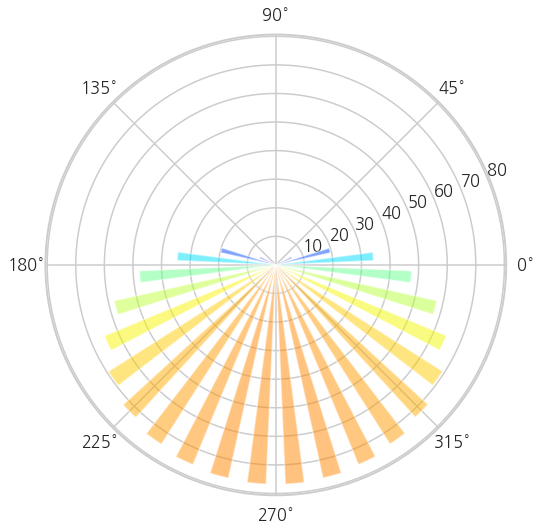

In [50]:
import numpy as np
import matplotlib.cm as cm
from matplotlib.pyplot import figure, show, rc

allAngle = pd.DataFrame({"aziMean" :list(range(0,360,10))})

allAngle_df = pd.merge(allAngle, aziperalt_df , on ="aziMean" , how='left')
allAngle_df = allAngle_df.fillna(0)

print("> 방위각 당 길이가 태양의 고도 의미")


fig = figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

N = 36
theta = np.arange(0.0, 2*np.pi, 2*np.pi/N) + 0.087 + 1.5708

radii = list(allAngle_df['altMean']) 
width = 2*np.pi/72
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r,bar in zip(radii, bars):
    bar.set_facecolor( cm.jet(r/100))
    bar.set_alpha(0.5)

plt.xticks() 
show()


### 2.7.2 higherThanAlt

* 위의 aziperalt_df을 이용하여 기준 건물과 인접 건물 사이의 앙각이 그 방위각에서의 태양의 고도 보다 높은 건물들을 찾아냄 
    * dictionary로 반환 후 dataframe으로 합침

In [51]:
# %%timeit

def angle_between(p1, p2 ):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))
    
def higherThanAlt(build_data, realnearest_ind_list, aziperalt_df , realnearest_dist_list) :
    
    xylocation = pd.DataFrame()
    xylocation['tm_x'] = build_data['tm_x']
    xylocation['tm_y'] = build_data['tm_y']

    xylocation_list = xylocation.values.tolist()
    xylocation_np = array(xylocation_list)
    
    start = time.time()
    
    at = {}
    for i in range(len(xylocation_np)) :

        if i%10000 == 0 :
            print(i)

        nowBuild = build_data.iloc[i]
        nearBuild = build_data.iloc[realnearest_ind_list[i]][['height','tm_x','tm_y']]
        
        re_height = (nearBuild['height'] - nowBuild['height']).apply(lambda x : max(x,0))
        re_angle = np.arctan2(re_height , np.array(realnearest_dist_list[i])) * 180 /  np.pi
#         print(re_angle.name)
        re_angle.name ='re_angle'
        
        
        nearx = nearBuild['tm_x'] - nowBuild['tm_x']
        neary = nearBuild['tm_y'] - nowBuild['tm_y']
        dist = pd.DataFrame(realnearest_dist_list[i] ,index =realnearest_ind_list[i], columns=['dist'])
        
        point = nearx.combine(neary , (lambda x1,x2 : (x1,x2)))
        
        azimuth = point.apply(lambda x : angle_between((0,150) , x)//10 * 10)
        azimuth.name = 'azimuth'
        
        nearBuild = pd.concat([nearx,neary,re_angle,dist,azimuth],axis=1)
        
        nearBuild = nearBuild.loc[nearBuild['re_angle'] > 0]
        
        nearBuild = pd.merge(nearBuild , aziperalt_df , left_on = 'azimuth' , right_on = 'aziMean')
        nearBuild['baseIndex'] = i

        rightBuild = nearBuild.loc[nearBuild['re_angle'] > nearBuild['altMean']]
                
        if not rightBuild.empty :
            at[i] = rightBuild

    
    print("time :", time.time() - start) 
    
    return at

x =higherThanAlt(build_data,realnearest_ind_list,aziperalt_df,realnearest_dist_list)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
time : 1336.7084593772888


In [52]:
upperAlt_list = []
for idx , near in x.items() :
    upperAlt_list.append(near)
    
af = pd.concat(upperAlt_list)

af.to_csv("./data/farthest/affectBuild/affectBuild_100.csv" , index=False ,encoding='utf-8')

af.head(20)

tm_x       tm_y   re_angle       dist  azimuth  aziMean    altMean  \
7  -59.984307  -2.680293  53.666457  60.044160    260.0      260  47.560246   
0  -10.802731  -0.306482  51.445782  10.807077    260.0      260  47.560246   
4   27.658782  -0.902879  48.609559  27.673515     90.0       90  47.757666   
11  69.242183  -9.959576  60.856556  69.954793     90.0       90  47.757666   
0  -14.451455  -0.200170  47.729667  14.452842    260.0      260  47.560246   
1  -27.258084 -10.620008  67.629780  29.253850    240.0      240  64.673595   
0  -18.992460  -1.027153  49.128992  19.020215    260.0      260  47.560246   
1   40.250427  -3.055818  61.543437  40.366259     90.0       90  47.757666   
1   53.940274  -5.815637  51.717818  54.252878     90.0       90  47.757666   
35 -64.050833  -7.904454  52.720670  64.536731    260.0      260  47.560246   
0   12.903015  -0.931051  77.107943  12.936562     90.0       90  47.757666   
0    5.905838  -4.298924  82.697130   7.304770    120.0      120  69.489285   
1   13.731631  -9.359755  73.746147  16.618144    120.0      120  69.489285   
0  -32.501092  -2.638344  54.120418  32.608003    260.0      260  47.560246   
1   45.427929  -2.587526  53.126136  45.501561     90.0       90  47.757666   
3   32.455152  -5.560714  62.947908  32.928080     90.0       90  47.757666   
0  -35.793549  -0.548006  62.701059  35.797743    260.0      260  47.560246   
22 -98.320056  -1.489735  53.850196  98.331342    260.0      260  47.560246   
29  80.790866 -25.255720  58.014711  84.646414    100.0      100  57.938121   
0  -11.831627  -2.023612  52.600285  12.003433    260.0      260  47.560246   

    baseIndex  
7           5  
0        1693  
4        1710  
11       5033  
0        5282  
1        5425  
0        6355  
1        7666  
1        7801  
35       8099  
0        8457  
0        9949  
1        9949  
0       11136  
1       11160  
3       11228  
0       11701  
22      15263  
29      15268  
0       16093

In [53]:
af =  pd.read_csv("./data/farthest/affectBuild/affectBuild_100.csv")
af.head()

tm_x      tm_y   re_angle       dist  azimuth  aziMean    altMean  \
0 -59.984307 -2.680293  53.666457  60.044160    260.0      260  47.560246   
1 -10.802731 -0.306482  51.445782  10.807077    260.0      260  47.560246   
2  27.658782 -0.902879  48.609559  27.673515     90.0       90  47.757666   
3  69.242183 -9.959576  60.856556  69.954793     90.0       90  47.757666   
4 -14.451455 -0.200170  47.729667  14.452842    260.0      260  47.560246   

   baseIndex  
0          5  
1       1693  
2       1710  
3       5033  
4       5282

## 2.7.3 방위각 10 당 빌딩 개수 데이터프레임화

* 모든 건물 인덱스에 각 방위각 영역에서 영향을 주는 건물의 개수를 계산

In [54]:
count_df = af.groupby(['baseIndex','azimuth']).count()['tm_x'].rename("counts").reset_index()
count_df.azimuth = count_df.azimuth.astype(int)

cols = list(map( lambda x : "altCount"+str(x) , list(range(60,300,10)) ))
cols.append('altCount')
base_df = pd.DataFrame(0, index=np.arange(len(build_data)),columns = cols)

for i in range(len(count_df)) :
    tmp = count_df.iloc[i]
    base_df.iloc[int(tmp.baseIndex)]["altCount"+str(tmp.azimuth)] = tmp.counts

base_df['altCount'] = base_df.sum(axis=1)    
base_df.to_csv("./data/farthest/altCount/altCount_100.csv" , index=False ,encoding='utf-8')

base_df.head(20)

altCount60  altCount70  altCount80  altCount90  altCount100  altCount110  \
0            0           0           0           0            0            0   
1            0           0           0           0            0            0   
2            0           0           0           0            0            0   
3            0           0           0           0            0            0   
4            0           0           0           0            0            0   
5            0           0           0           0            0            0   
6            0           0           0           0            0            0   
7            0           0           0           0            0            0   
8            0           0           0           0            0            0   
9            0           0           0           0            0            0   
10           0           0           0           0            0            0   
11           0           0           0           0            0            0   
12           0           0           0           0            0            0   
13           0           0           0           0            0            0   
14           0           0           0           0            0            0   
15           0           0           0           0            0            0   
16           0           0           0           0            0            0   
17           0           0           0           0            0            0   
18           0           0           0           0            0            0   
19           0           0           0           0            0            0   

    altCount120  altCount130  altCount140  altCount150  altCount160  \
0             0            0            0            0            0   
1             0            0            0            0            0   
2             0            0            0            0            0   
3             0            0            0            0            0   
4             0            0            0            0            0   
5             0            0            0            0            0   
6             0            0            0            0            0   
7             0            0            0            0            0   
8             0            0            0            0            0   
9             0            0            0            0            0   
10            0            0            0            0            0   
11            0            0            0            0            0   
12            0            0            0            0            0   
13            0            0            0            0            0   
14            0            0            0            0            0   
15            0            0            0            0            0   
16            0            0            0            0            0   
17            0            0            0            0            0   
18            0            0            0            0            0   
19            0            0            0            0            0   

    altCount170  altCount180  altCount190  altCount200  altCount210  \
0             0            0            0            0            0   
1             0            0            0            0            0   
2             0            0            0            0            0   
3             0            0            0            0            0   
4             0            0            0            0            0   
5             0            0            0            0            0   
6             0            0            0            0            0   
7             0            0            0            0            0   
8             0            0            0            0            0   
9             0            0            0            0            0   
10            0            0            0         

In [55]:
base_df = pd.read_csv("./data/farthest/altCount/altCount_100.csv")
build_data = pd.concat([build_data,base_df] , axis=1)

build_data.head(15)

gid  buld_se_cd buld_se_nm  bdtyp_cd apt_yn  gro_flo_co  sig_cd sig_nm  \
0   24300           0         지상      4299      N           1   30110     동구   
1   16295           0         지상      1001      N           1   30110     동구   
2   24341           0         지상      1001      N           1   30110     동구   
3   24345           0         지상      4402      N           1   30110     동구   
4   24374           0         지상     18999      N           1   30110     동구   
5   24388           0         지상      1001      N           1   30110     동구   
6   24389           0         지상      1001      N           1   30110     동구   
7   24390           0         지상      1001      N           1   30110     동구   
8   16000           0         지상      8300      N           1   30110     동구   
9   41029           0         지상      1001      N           2   30140     중구   
10  24431           0         지상      1001      N           1   30110     동구   
11  18212           0         지상      1001      N           1   30110     동구   
12  17960           0         지상      1001      N           1   30110     동구   
13  24446           0         지상      1001      N           1   30110     동구   
14  24449           0         지상     13100      N           1   30110     동구   

      emd_cd emd_nm           tm_x           tm_y         lon        lat  \
0   30110137    대별동  241302.419829  409864.414379  127.459746  36.285880   
1   30110105    가오동  240815.012971  412384.958080  127.454453  36.308615   
2   30110137    대별동  241460.822384  410090.945431  127.461521  36.287914   
3   30110137    대별동  241530.222973  410067.763075  127.462293  36.287703   
4   30110137    대별동  241500.967911  409605.204042  127.461942  36.283535   
5   30110110     대동  240159.906540  414421.117212  127.447263  36.326991   
6   30110109    용운동  240194.089360  414404.414184  127.447643  36.326839   
7   30110109    용운동  240211.926874  414384.035681  127.447841  36.326655   
8   30110139    대성동  241427.753874  411065.669655  127.461205  36.296700   
9   30140104    중촌동  236967.617274  416166.130328  127.411794  36.342844   
10  30110118    삼성동  238717.498156  415562.889447  127.431256  36.337339   
11  30110110     대동  240080.438916  415029.676385  127.446410  36.332479   
12  30110110     대동  239974.834905  414908.953735  127.445227  36.331395   
13  30110118    삼성동  238698.420239  415640.326535  127.431048  36.338038   
14  30110118    삼성동  238680.851292  415517.817895  127.430846  36.336935   

     buld_area  buld_elev      sL01      sL02      sL03      sL04      sL05  \
0   199.109760  80.000000  0.204715  0.217257  0.205812  0.184260  0.153714   
1    77.392318  71.000000  0.295631  0.231582  0.193751  0.177985  0.176701   
2    91.076386  77.000000  0.195469  0.200133  0.191029  0.185189  0.171563   
3    51.201706  78.000000  0.371389  0.378444  0.366326  0.342754  0.316217   
4   455.844167  80.000000  0.131596  0.138417  0.124781  0.116576  0.102620   
5    77.409333  60.000000  0.342013  0.264208  0.265782  0.300238  0.345351   
6    51.337342  60.000000  0.295785  0.271745  0.264553  0.268319  0.274780   
7    75.987029  60.000000  0.420510  0.392274  0.366863  0.342073  0.327701   
8   172.360837  82.360001  0.164547  0.164071  0.141630  0.121494  0.104828   
9   117.383692  44.000000  0.375975  0.338155  0.306407  0.287346  0.275248   
10   29.256159  51.799999  0.392870  0.402961  0.390841  0.379955  0.370022   
11   64.672200  61.000000  0.239652  0.238992  0.230112  0.224417  0.219639   
12  148.262691  57.160000  0.187741  0.178004  0.166223  0.157832  0.154972   
13    6.647636  51.000000  0.292454  0.285909  0.284889  0.311123  0.333483   
14   27.016232  50.000000  0.477458  0.431736  0.431827  0.437249  0.454863   

        sL06      sL07      sL08      sL09      sL10      sL11      sL12  \
0   0.139599  0.138983  0.163898  0.196457  0.204533  0.213280  0.208075   
1   0.178177  0.185056  0.182143  0.187676  0.211802  0.252642  0.330147   
2   0.164108  0

In [56]:
build_data.to_csv('./data/2.7/build_data_3group_80100.csv',index=False ,encoding='utf-8')

In [14]:
build_data = pd.read_csv("./data/2.7/build_data_3group_80100.csv")

# 3. 파생데이터 시각화

In [58]:
%matplotlib inline

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

In [59]:
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())
print ('설정 파일 위치: ', mpl.matplotlib_fname())

버전:  3.1.1
설치 위치:  /usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py
설정 위치:  /home/junho/.config/matplotlib
캐시 위치:  /home/junho/.cache/matplotlib
설정 파일 위치:  /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/matplotlibrc


In [60]:
# 특정 데이터의 지도상 분포 시각화 함수
def vis_map(df: pd.DataFrame, df2 : pd.DataFrame,
            col: str,
            pal: sns.color_palette, 
            title: str, 
            bintup=None,   # bintup = (binmin: int, binmax: int, binnum: int)
            log=False
           ):
  
  datatype = str(df[col].dtype)
  print('Data type={}'.format(datatype))
  
  if datatype == 'object':
    colbin = df[col].unique()
    colbin_len = len(df[col].unique())
    colbin_name = col
  
  else:
    binmin, binmax, binnum = bintup
    
    if log==True:
      log_binmin = np.log10(binmin)
      log_binmax = np.log10(binmax)
      colbin = np.logspace(log_binmin, log_binmax, num=binnum)
    else:
      colbin = np.arange(binmin, binmax, binnum)
      
    colbin_len = len(colbin) - 1 
   
    colbin_name = col + '_bin'
    df[colbin_name] = pd.cut(df[col], colbin)

  fig , ax =  plt.subplots(figsize=(16,12))
  sns.relplot(kind='scatter', x='lon', y='lat', data=df, 
                  s=3, linewidth=0, hue=colbin_name, 
                  palette=sns.color_palette(pal, n_colors=colbin_len), 
                  legend='brief', ax = ax,
                  height=10)
  
  sns.relplot(kind='scatter', x='lon', y='lat' , data = df2 , ax = ax , color='black' ,
                     s=3, linewidth=0 ,palette=sns.color_palette(pal, n_colors=colbin_len))
#   plt.show()
  plt.close()
  plt.close()



## 3.1 대전 구 경계 데이터

* 대전시의 구를 경계지어줄 선이 필요
* https://github.com/vuski/admdongkor 에서 행정동 경계 데이터( HangJeongDong_ver20190403.geojson ) 수집
* 대전의 행정동 경계 데이터만 추려내고, 각 구 안에 중복되는 동 경계는 삭제 -> 구 경계 만 남음


* <font color='red'> 동 데이터가 빠진게 존재하는 듯 , 사이의 간격을 메꿀 수 있는 방법 필요 , 개선 필요</font>

In [61]:
geojsonPath= './data/basemap/HangJeongDong_ver20171016.geojson'
with open(geojsonPath) as f :
    data = json.load(f)
print(data)    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [62]:
# json 데이터를 보니까 대전은 앞자리가 25이다.
geodata_daejeon = []
for feature in data['features'] :
    if feature['properties']['adm_cd'][:2]  == '25' :
        geodata_daejeon.append(feature)



In [63]:
geodata_daejeon
latlon_daejeon = {}
all_location = []
all_latlon =[ ]
for geo in geodata_daejeon :
    all_latlon.extend(geo['geometry']['coordinates'][0])

latlon_daejeon['all'] = all_latlon
latlon_daejeon['동구'] = []
latlon_daejeon['중구'] = []
latlon_daejeon['유성구'] = []
latlon_daejeon['서구'] = []
latlon_daejeon['대덕구'] = []



In [64]:
num = 0
for geo in geodata_daejeon :
    latlon_daejeon[geo['properties']['adm_nm'].split()[1]].extend(geo['geometry']['coordinates'][0])
    num = num+1
    
print(num)

79


In [65]:
def extractBoundaries(latlon_daejeon , gu_name):
    
    gu_latlon = []
    
    ll_series = pd.Series(latlon_daejeon[gu_name])
    ll_series = ll_series.apply(lambda x : tuple(x))
    a = ll_series.value_counts()
    a = dict(a)

    for idx , val in a.items() :
        if val == 1 :
            gu_latlon.append(idx)
    
    return gu_latlon
            
a = extractBoundaries(latlon_daejeon,"서구")            
all_edge = []
for gu in ['서구','동구','유성구','대덕구','중구'] :
    all_edge.extend(extractBoundaries(latlon_daejeon,gu))
    
all_edge[:10]

[(127.32705645993794, 36.20377609757011),
 (127.31969956039778, 36.21544906099954),
 (127.35965600423556, 36.262669934995024),
 (127.3012214336801, 36.22118769101955),
 (127.2880589283616, 36.26170857859202),
 (127.28108305352245, 36.246253082333595),
 (127.38579483566049, 36.320286981024),
 (127.3360097133193, 36.33017738963814),
 (127.32141312406488, 36.213830151815074),
 (127.33510072343262, 36.18361894770331)]

## 3.1.1 구 경계 데이터 시각화

          lon        lat
0  127.327056  36.203776
1  127.319700  36.215449
2  127.359656  36.262670
3  127.301221  36.221188
4  127.288059  36.261709
> 대전 구 경계 데이터


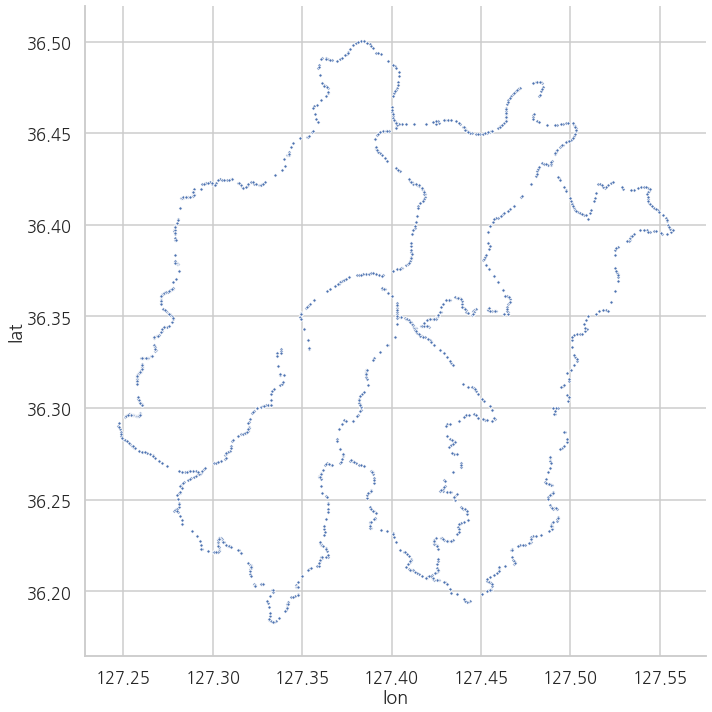

In [66]:
boundaries_data = pd.DataFrame(all_edge , columns=['lon','lat'])

print(boundaries_data.head())

print("> 대전 구 경계 데이터")
sns.relplot(x="lon", y="lat", data = boundaries_data , s=10 , height = 10)

In [67]:
build_data['buld_se_cd'] = build_data['buld_se_cd'].astype(object)
build_data['bdtyp_cd'] = build_data['bdtyp_cd'].astype(object)
build_data['sig_cd'] = build_data['sig_cd'].astype(object)
build_data['emd_cd'] = build_data['emd_cd'].astype(object)

data_vis = copy.deepcopy(build_data)
data_vis['lat'] = data_vis['lat'].astype(float)
data_vis['lon'] = data_vis['lon'].astype(float)

data_vis.head()

gid buld_se_cd buld_se_nm bdtyp_cd apt_yn  gro_flo_co sig_cd sig_nm  \
0  24300          0         지상     4299      N           1  30110     동구   
1  16295          0         지상     1001      N           1  30110     동구   
2  24341          0         지상     1001      N           1  30110     동구   
3  24345          0         지상     4402      N           1  30110     동구   
4  24374          0         지상    18999      N           1  30110     동구   

     emd_cd emd_nm           tm_x           tm_y         lon        lat  \
0  30110137    대별동  241302.419829  409864.414379  127.459746  36.285880   
1  30110105    가오동  240815.012971  412384.958080  127.454453  36.308615   
2  30110137    대별동  241460.822384  410090.945431  127.461521  36.287914   
3  30110137    대별동  241530.222973  410067.763075  127.462293  36.287703   
4  30110137    대별동  241500.967911  409605.204042  127.461942  36.283535   

    buld_area  buld_elev      sL01      sL02      sL03      sL04      sL05  \
0  199.109760       80.0  0.204715  0.217257  0.205812  0.184260  0.153714   
1   77.392318       71.0  0.295631  0.231582  0.193751  0.177985  0.176701   
2   91.076386       77.0  0.195469  0.200133  0.191029  0.185189  0.171563   
3   51.201706       78.0  0.371389  0.378444  0.366326  0.342754  0.316217   
4  455.844167       80.0  0.131596  0.138417  0.124781  0.116576  0.102620   

       sL06      sL07      sL08      sL09      sL10      sL11      sL12  \
0  0.139599  0.138983  0.163898  0.196457  0.204533  0.213280  0.208075   
1  0.178177  0.185056  0.182143  0.187676  0.211802  0.252642  0.330147   
2  0.164108  0.155892  0.172701  0.185788  0.188739  0.196957  0.201032   
3  0.304955  0.310306  0.327509  0.357109  0.368799  0.378022  0.374364   
4  0.095113  0.086709  0.104519  0.118837  0.127436  0.138503  0.138233   

     sL_y17  buld_length  buld_height  height  rad_angle_max  rad_rel_fl  \
0  0.180697    15.922136         3.14   83.14       5.011625    1.000000   
1  0.205046     9.926679         3.14   74.14      35.570123    2.473684   
2  0.181562    10.768568         3.14   80.14       5.080622    1.333333   
3  0.344058     8.074159         3.14   81.14       1.555146    0.000000   
4  0.115303    24.091468         3.14   83.14       7.164204    1.000000   

   rad_rel_height  rad_angle_max_80  rad_angle_max_160  rad_angle_max_240  \
0        1.587692          0.902407           5.011625           0.000000   
1        6.327369          1.182603          35.570123          15.608649   
2        2.356000          5.080622           4.332678           3.259005   
3        1.000000          0.000000           1.555146           0.000000   
4        2.859999          1.343876           3.126923           7.164204   

   count_80  count_160  count_240  height_80  height_160  height_240  \
0        11          9          6  83.874546   84.186667   82.306667   
1        14         20          5  73.260000   77.880000   80.340001   
2         1          4          6  84.280000   82.710000   81.663333   
3         3          4          0  81.140000   81.640000    0.000000   
4         1          1          2  84.140000   85.099999   87.379998   

   nearShadow  nearScaledShadow  rel_nearShadow  rel_nearScaledShadow  \
0  514.339502        514.339502       10.375585             10.375585   
1  706.151655        706.151655       16.730038             16.730038   
2  214.120840        214.120840        3.661072              3.661072   
3  134.841008        134.841008        4.020769              4.020769   
4   81.380586         81.380586        1.843745              1.843745   

   altCount60  altCount70  altCount80  altCount90  altCount100  altCount110  \
0           0           0           0           0            0            0   
1           0           0           0           0            0            0   
2           0           0           0           0            0            0   
3           0           0           0           0            0       

## 3.2 파생 데이터(2.5에서 구한) 시각화

Data type=float64


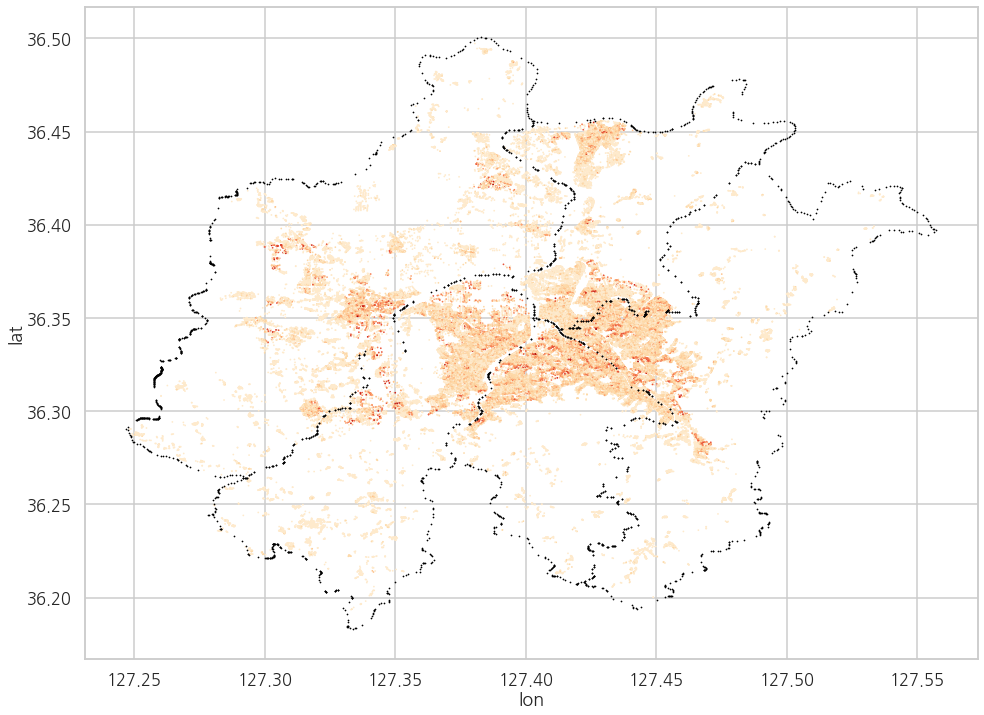

In [68]:
vis_map(df=data_vis, df2=boundaries_data, col='rad_angle_max', pal='OrRd', title='최대 앙각',  bintup=(0, 90, 10))

Data type=float64


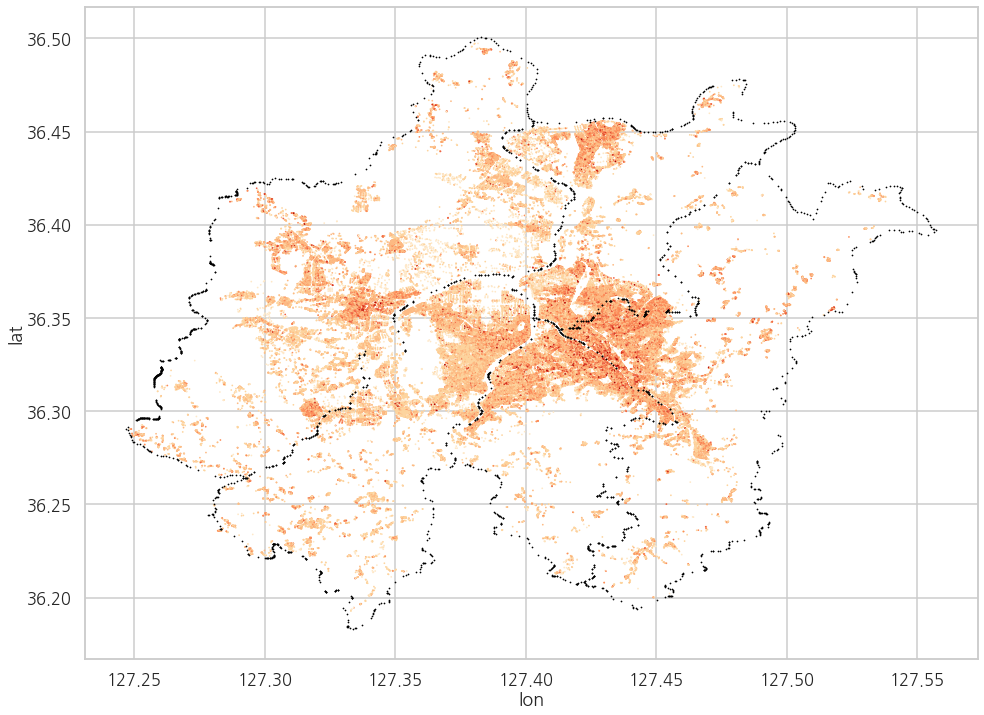

In [69]:
vis_map(df=data_vis, df2=boundaries_data, col='sL_y17', pal='OrRd', title='일사량 손실률',  bintup=(0, 0.8, 0.1))

## 3.3 인접 건물의 최대 최소 앙각 (2.7에서 구한)

* x축을 최대, 최소 앙각으로 하고, y축은 개수인 히스토그램을 그림

빨강 : max
파강 : min


/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


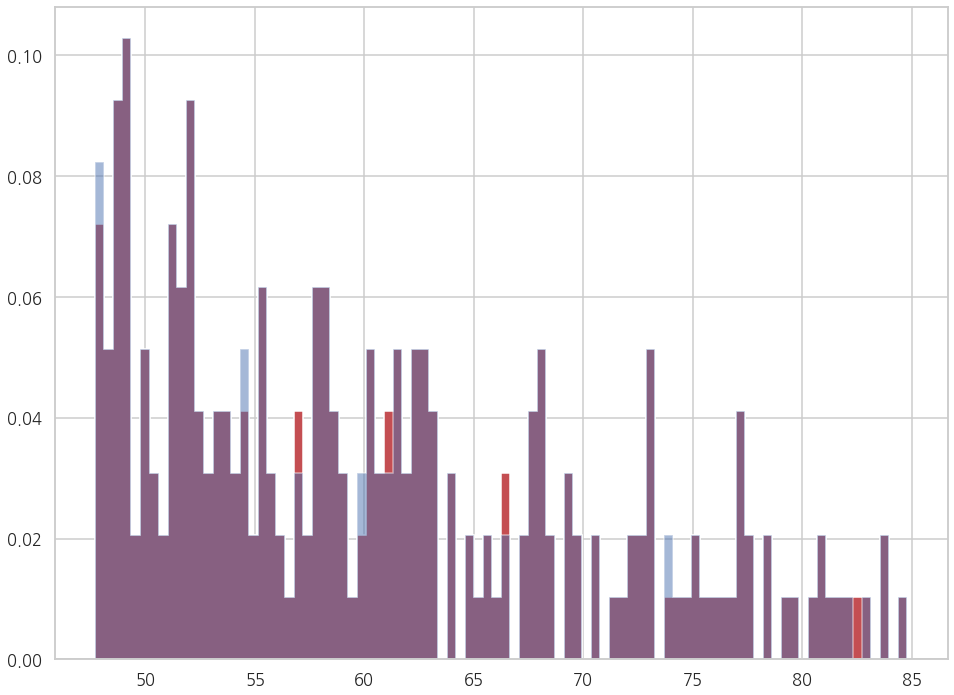

baseIndex  re_angle_x  re_angle_y
0          5   53.666457   53.666457
1       1693   51.445782   51.445782
2       1710   48.609559   48.609559
3       5033   60.856556   60.856556
4       5282   47.729667   47.729667

In [70]:
min_df = af.groupby(['baseIndex'])['re_angle'].min().reset_index()
max_df = af.groupby(['baseIndex'])['re_angle'].max().reset_index()

minmaxAngle_df = pd.merge(min_df, max_df , on ="baseIndex")


print("빨강 : max")
print("파강 : min")
fig = plt.figure(figsize=(16,12))
plt.hist(minmaxAngle_df['re_angle_y'], bins=90, histtype='stepfilled', normed=True, color='r', label='max')
plt.hist(minmaxAngle_df['re_angle_x'], bins=90, histtype='stepfilled', normed=True, color='b',alpha=0.5, label='min')
plt.show()

minmaxAngle_df.head()

* x축을 최대 앙각 - 최소 앙각로 하고 히스토그램을 그림

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


> 최대앙각-최소앙각 평균  0.1323911709073209


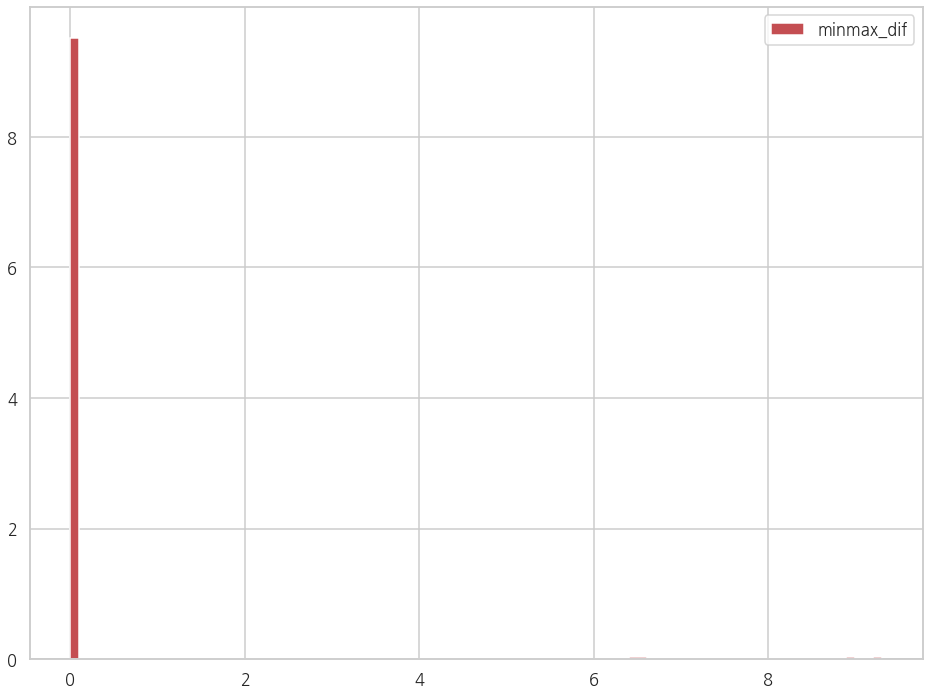

In [71]:
fig = plt.figure(figsize=(16,12))
plt.hist(minmaxAngle_df['re_angle_y']-minmaxAngle_df['re_angle_x'], bins=90, histtype='stepfilled', normed=True, color='r', label='minmax_dif')

plt.legend()

print( "> 최대앙각-최소앙각 평균 " , (minmaxAngle_df['re_angle_y']-minmaxAngle_df['re_angle_x']).mean() )
plt.show()

## 3.4 방위각 10도 당 최대 거리 시각화

In [72]:
af[af.groupby(['azimuth'])['re_angle'].transform(max) == af['re_angle']].sort_values(['azimuth'])
maxDist_df = af[af.groupby(['azimuth'])['dist'].transform(max) == af['dist']].sort_values('azimuth') 

maxDist_df

tm_x       tm_y   re_angle       dist  azimuth  aziMean    altMean  \
215  99.553138  -6.747024  55.936663  99.781509     90.0       90  47.757666   
18   80.790866 -25.255720  58.014711  84.646414    100.0      100  57.938121   
96   54.874277 -21.050800  66.392625  58.773485    110.0      110  64.945184   
32   42.835780 -26.043324  69.936310  50.131415    120.0      120  69.489285   
65   20.659438 -22.124340  77.332807  30.270428    130.0      130  72.503030   
239  14.921971 -20.115395  79.155245  25.045845    140.0      140  74.450469   
70   11.918051 -31.669896  77.086040  33.838177    150.0      150  75.698172   
109   5.920734 -21.483763  80.880153  22.284685    160.0      160  76.455223   
154   2.130708 -21.404407  81.707374  21.510196    170.0      170  76.792825   
88   -0.554402 -20.958854  81.006997  20.966185    180.0      180  76.784099   
161  -2.230632 -11.574372  78.219705  11.787358    190.0      190  76.394843   
52  -23.221498 -28.294103  75.253177  36.603200    210.0      210  74.328750   
184 -24.955054 -28.734741  75.539456  38.058377    220.0      220  72.290815   
193 -32.436194 -22.532877  72.124885  39.494774    230.0      230  69.243356   
58  -54.632969 -23.569905  65.575659  59.500435    240.0      240  64.673595   
196 -89.336366 -28.796046  58.086927  93.862658    250.0      250  57.748476   
141 -98.593090  -6.665856  57.813069  98.818171    260.0      260  47.560246   

     baseIndex  
215     137556  
18       15268  
96       61862  
32       22941  
65       40347  
239     147378  
70       43459  
109      71188  
154      98994  
88       54923  
161     101378  
52       34000  
184     121150  
193     126092  
58       37071  
196     126740  
141      89851

> 방위각당 가장 멀리있는 건물과의 거리 시각화


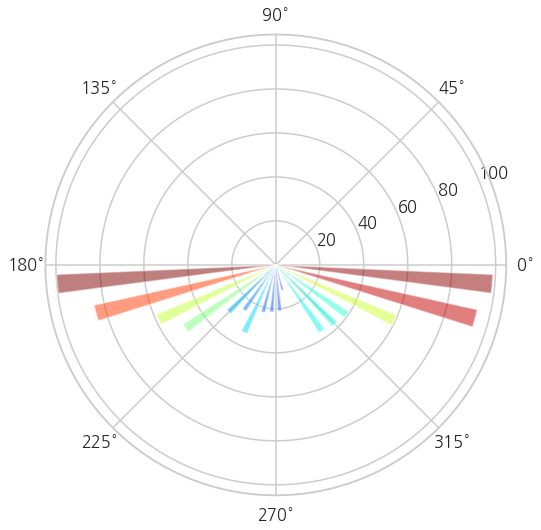

tm_x       tm_y   re_angle       dist  azimuth  aziMean    altMean  \
215  99.553138  -6.747024  55.936663  99.781509     90.0       90  47.757666   
18   80.790866 -25.255720  58.014711  84.646414    100.0      100  57.938121   
96   54.874277 -21.050800  66.392625  58.773485    110.0      110  64.945184   
32   42.835780 -26.043324  69.936310  50.131415    120.0      120  69.489285   
65   20.659438 -22.124340  77.332807  30.270428    130.0      130  72.503030   
239  14.921971 -20.115395  79.155245  25.045845    140.0      140  74.450469   
70   11.918051 -31.669896  77.086040  33.838177    150.0      150  75.698172   
109   5.920734 -21.483763  80.880153  22.284685    160.0      160  76.455223   
154   2.130708 -21.404407  81.707374  21.510196    170.0      170  76.792825   
88   -0.554402 -20.958854  81.006997  20.966185    180.0      180  76.784099   
161  -2.230632 -11.574372  78.219705  11.787358    190.0      190  76.394843   
52  -23.221498 -28.294103  75.253177  36.603200    210.0      210  74.328750   
184 -24.955054 -28.734741  75.539456  38.058377    220.0      220  72.290815   
193 -32.436194 -22.532877  72.124885  39.494774    230.0      230  69.243356   
58  -54.632969 -23.569905  65.575659  59.500435    240.0      240  64.673595   
196 -89.336366 -28.796046  58.086927  93.862658    250.0      250  57.748476   
141 -98.593090  -6.665856  57.813069  98.818171    260.0      260  47.560246   

     baseIndex  
215     137556  
18       15268  
96       61862  
32       22941  
65       40347  
239     147378  
70       43459  
109      71188  
154      98994  
88       54923  
161     101378  
52       34000  
184     121150  
193     126092  
58       37071  
196     126740  
141      89851

In [73]:
import numpy as np
import matplotlib.cm as cm
from matplotlib.pyplot import figure, show, rc

print("> 방위각당 가장 멀리있는 건물과의 거리 시각화")

allAngle = pd.DataFrame({"azimuth" :list(range(0,360,10))})

allAngle_df = pd.merge(allAngle, maxDist_df , on ="azimuth" , how='left')
allAngle_df = allAngle_df.fillna(0)


fig = figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

N = 36
theta = np.arange(0.0, 2*np.pi, 2*np.pi/N) + 0.087 + 1.5708
# print(theta)
# print(len(theta))
radii = list(allAngle_df['dist'])
width = 2*np.pi/72
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r,bar in zip(radii, bars):
    bar.set_facecolor( cm.jet(r/100))
    bar.set_alpha(0.5)

plt.xticks() 
show()

maxDist_df

# 4. 상관관계 분석

## 4.1 파생 변수 상관관계

In [74]:
def calCorrs(build_data) :
    corr_angle = pd.DataFrame()

    corr_angle['rad_angle_max'] = build_data['rad_angle_max']
    corr_angle['rad_rel_fl'] = build_data['rad_rel_fl'] 
    corr_angle['rad_rel_height'] = build_data['rad_rel_height'] 

    corr_angle['rad_angle_max_80'] = build_data['rad_angle_max_80']
    corr_angle['rad_angle_max_160'] = build_data['rad_angle_max_160']
    corr_angle['rad_angle_max_240'] = build_data['rad_angle_max_240']

    corr_angle['count_80'] = build_data['count_80']
    corr_angle['count_160'] = build_data['count_160']
    corr_angle['count_240'] = build_data['count_240']
    
    
    corr_angle['nearShadow'] = build_data['nearShadow']
    corr_angle['nearScaledShadow'] = build_data['nearScaledShadow']
    corr_angle['rel_nearScaledShadow'] = build_data['rel_nearScaledShadow']
    corr_angle['rel_nearShadow'] = build_data['rel_nearShadow']
    corr_angle['altCount'] = build_data['altCount']


#     corr_angle['sL_y17'] = build_data['sL_y17']
    corr_angle['sL06'] = build_data['sL06']

    corrs = corr_angle.corr(method='pearson')
    
    return corrs

In [75]:
# Ycorrs = corrs.sort_values('sL_y17', ascending = False)

# print("> 년간 차폐율과의 상관계수 내림차순")
# print(Ycorrs['sL_y17'])

corrs = calCorrs(build_data)
Ycorrs = corrs.sort_values('sL06', ascending = False)
df_cor = pd.DataFrame(Ycorrs, columns=Ycorrs.index)

print("> 6월 차폐율과의 상관계수 내림차순")
df_cor

> 6월 차폐율과의 상관계수 내림차순


sL06  rad_angle_max  rad_angle_max_80  \
sL06                  1.000000       0.366158          0.308102   
rad_angle_max         0.366158       1.000000          0.662456   
rad_angle_max_80      0.308102       0.662456          1.000000   
rad_angle_max_160     0.288340       0.794225          0.412314   
rad_angle_max_240     0.271490       0.674012          0.278090   
count_160             0.258846       0.144169          0.163869   
rel_nearScaledShadow  0.257333       0.160116          0.160717   
rel_nearShadow        0.257333       0.160116          0.160717   
count_80              0.239372       0.153180          0.142644   
nearShadow            0.232197       0.157077          0.163173   
nearScaledShadow      0.232197       0.157077          0.163173   
count_240             0.232028       0.152442          0.166932   
rad_rel_fl            0.167943       0.625624          0.362588   
rad_rel_height        0.142433       0.611245          0.356955   
altCount              0.070645       0.185233          0.142668   

                      rad_angle_max_160  rad_angle_max_240  count_160  \
sL06                           0.288340           0.271490   0.258846   
rad_angle_max                  0.794225           0.674012   0.144169   
rad_angle_max_80               0.412314           0.278090   0.163869   
rad_angle_max_160              1.000000           0.430403   0.144355   
rad_angle_max_240              0.430403           1.000000   0.164675   
count_160                      0.144355           0.164675   1.000000   
rel_nearScaledShadow           0.161547           0.179068   0.821101   
rel_nearShadow                 0.161547           0.179068   0.821101   
count_80                       0.162101           0.176956   0.673663   
nearShadow                     0.160839           0.178507   0.868867   
nearScaledShadow               0.160839           0.178507   0.868867   
count_240                      0.157635           0.155770   0.657048   
rad_rel_fl                     0.483420           0.380784  -0.034564   
rad_rel_height                 0.488677           0.397957  -0.078510   
altCount                       0.066574           0.129475  -0.006810   

                      rel_nearScaledShadow  rel_nearShadow  count_80  \
sL06                              0.257333        0.257333  0.239372   
rad_angle_max                     0.160116        0.160116  0.153180   
rad_angle_max_80                  0.160717        0.160717  0.142644   
rad_angle_max_160                 0.161547        0.161547  0.162101   
rad_angle_max_240                 0.179068        0.179068  0.176956   
count_160                         0.821101        0.821101  0.673663   
rel_nearScaledShadow              1.000000        1.000000  0.714172   
rel_nearShadow                    1.000000        1.000000  0.714172   
count_80                          0.714172        0.714172  1.000000   
nearShadow                        0.962552        0.962552  0.752627   
nearScaledShadow                  0.962552        0.962552  0.752627   
count_240                         0.696224        0.696224  0.455619   
rad_rel_fl                       -0.040143       -0.040143 -0.010109   
rad_rel_height                   -0.063302       -0.063302 -0.048689   
altCount                         -0.006814       -0.006814 -0.011687   

                      nearShadow  nearScaledShadow  count_240  rad_rel_fl  \
sL06                    0.232197          0.232197   0.232028    0.167943   
rad_angle_max           0.157077          0.157077   0.152442    0.625624   
rad_angle_max_80        0.163173          0.163173   0.166932    0.362588   
rad_angle_max_160       0.160839          0.160839   0.157635    0.483420   
rad_angle_max_240       0.178507          0.178507   0.155770    0.380784   
count_160               0.868867          0.868867   0.657048   -0.034564   
rel_nearScaledShadow    0.962552          0.962552   0.696224   -0.040143   
rel_nearShadow 

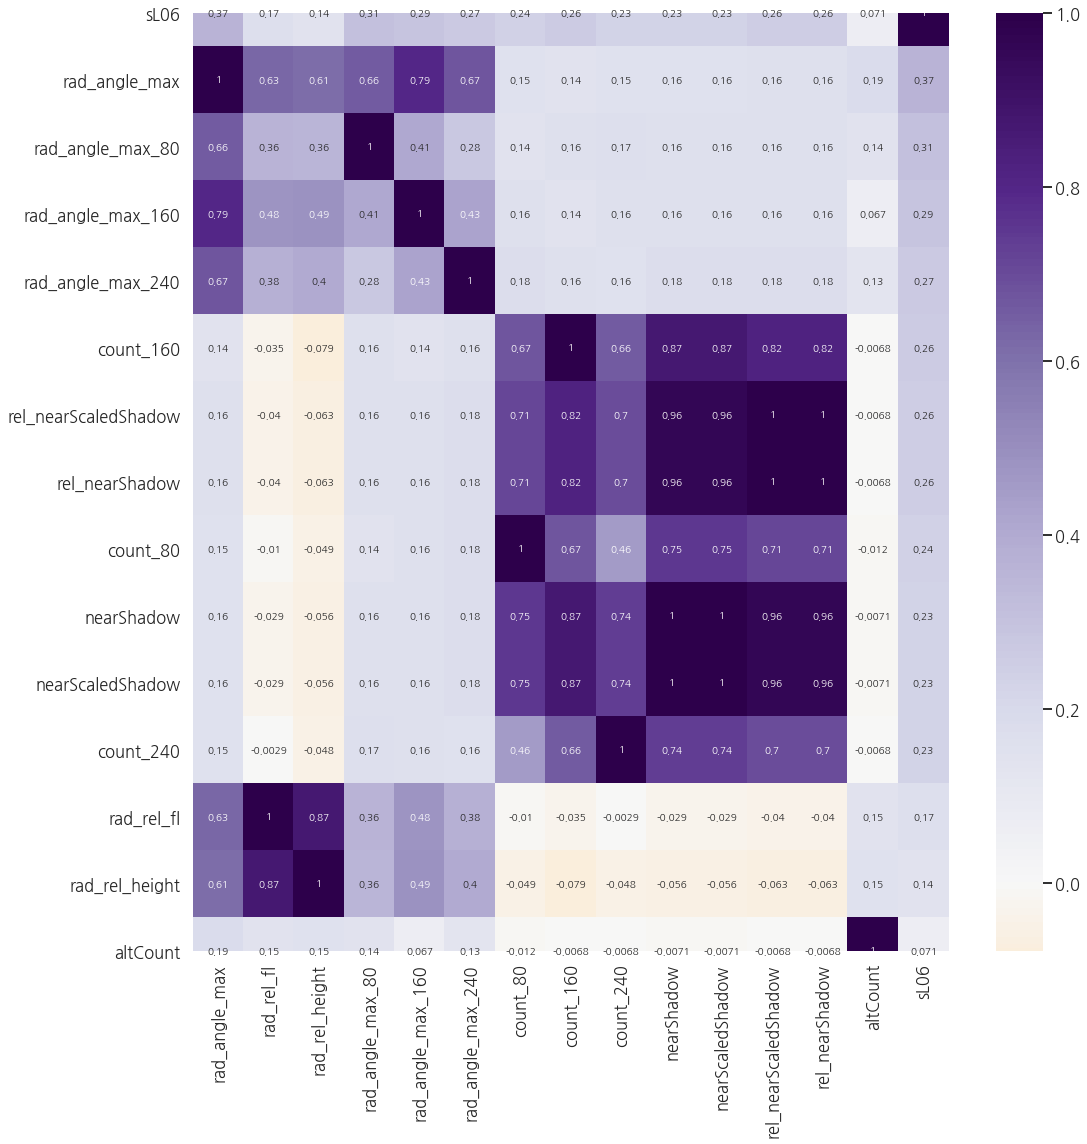

In [76]:
plt.figure(figsize=(16, 16))

sns.heatmap(Ycorrs, annot=True, cmap="PuOr", center=0)

plt.tight_layout()

# 5. Feature Extraction

## 5.1 Feature Extraction 전에 scaling

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fe_data = copy.deepcopy(build_data)
fe_y  = fe_data['sL06']
for i in range(1,13) :
    del fe_data['sL'+str(i).zfill(2)]
del fe_data['sL_y17']
del fe_data['gid']
del fe_data['buld_se_nm']
del fe_data['sig_nm']
del fe_data['emd_nm']
del fe_data['apt_yn']
del fe_data['sig_cd']
del fe_data['emd_cd']

del fe_data['buld_se_cd']
del fe_data['gro_flo_co']
del fe_data['bdtyp_cd']


fe_columns = list(fe_data.columns)
fe_data = StandardScaler().fit_transform(fe_data)

fe_data = pd.DataFrame(fe_data , columns = fe_columns )

fe_data.head()

tm_x      tm_y       lon       lat  buld_area  buld_elev  buld_length  \
0  1.331414 -1.276131  1.323589 -1.281236   0.016237   0.635718     0.347283   
1  1.208297 -0.745838  1.203591 -0.750308  -0.141158   0.261221    -0.392032   
2  1.371425 -1.228471  1.363830 -1.233721  -0.123463   0.510886    -0.288216   
3  1.388956 -1.233349  1.381314 -1.238670  -0.175026   0.552496    -0.620470   
4  1.381566 -1.330666  1.373376 -1.335985   0.348226   0.635718     1.354664   

   buld_height    height  rad_angle_max  rad_rel_fl  rad_rel_height  \
0    -0.463924  0.462260      -0.608248   -0.280010       -0.492724   
1    -0.463924  0.098295       2.270057    0.435548        0.370345   
2    -0.463924  0.340939      -0.601749   -0.118157       -0.352820   
3    -0.463924  0.381379      -0.933814   -0.765567       -0.599740   
4    -0.463924  0.462260      -0.405497   -0.280010       -0.261044   

   rad_angle_max_80  rad_angle_max_160  rad_angle_max_240  count_80  \
0         -0.663145          -0.318478          -0.775022  0.214167   
1         -0.628188           3.067303           1.167581  0.617112   
2         -0.141875          -0.393703          -0.369416 -1.128981   
3         -0.775728          -0.701444          -0.775022 -0.860352   
4         -0.608068          -0.527296           0.116612 -1.128981   

   count_160  count_240  height_80  height_160  height_240  nearShadow  \
0  -0.546654  -0.450627   0.688398    0.621307    0.633795   -0.068656   
1   0.430688  -0.585148   0.334767    0.394271    0.568111    0.454400   
2  -0.990900  -0.450627   0.701906    0.568148    0.612308   -0.887327   
3  -0.990900  -1.257752   0.597295    0.529629   -2.115144   -1.103517   
4  -1.257447  -0.988710   0.697242    0.654187    0.803238   -1.249299   

   nearScaledShadow  rel_nearShadow  rel_nearScaledShadow  altCount60  \
0         -0.068656       -0.074229             -0.074229         0.0   
1          0.454400        0.793548              0.793548         0.0   
2         -0.887327       -0.991177             -0.991177         0.0   
3         -1.103517       -0.942056             -0.942056         0.0   
4         -1.249299       -1.239355             -1.239355         0.0   

   altCount70  altCount80  altCount90  altCount100  altCount110  altCount120  \
0         0.0         0.0   -0.021615    -0.011341    -0.006373     -0.00607   
1         0.0         0.0   -0.021615    -0.011341    -0.006373     -0.00607   
2         0.0         0.0   -0.021615    -0.011341    -0.006373     -0.00607   
3         0.0         0.0   -0.021615    -0.011341    -0.006373     -0.00607   
4         0.0         0.0   -0.021615    -0.011341    -0.006373     -0.00607   

   altCount130  altCount140  altCount150  altCount160  altCount170  \
0    -0.003679    -0.004506    -0.004506    -0.003679    -0.002602   
1    -0.003679    -0.004506    -0.004506    -0.003679    -0.002602   
2    -0.003679    -0.004506    -0.004506    -0.003679    -0.002602   
3    -0.003679    -0.004506    -0.004506    -0.003679    -0.002602   
4    -0.003679    -0.004506    -0.004506    -0.003679    -0.002602   

   altCount180  altCount190  altCount200  altCount210  altCount220  \
0    -0.002602    -0.002602          0.0    -0.005817    -0.002602   
1    -0.002602    -0.002602          0.0    -0.005817    -0.002602   
2    -0.002602    -0.002602          0.0    -0.005817    -0.002602   
3    -0.002602    -0.002602          0.0    -0.005817    -0.002602   
4    -0.002602    -0.002602          0.0    -0.005817    -0.002602   

   altCount230  altCount240  altCount250  altCount260  altCount270  \
0    -0.005203    -0.007805    -0.012203    -0.023714          0.0   
1    -0.005203    -0.007805    -0.012203    -0.023714          0.0   
2    -0.005203    -0.007805    -0.012203    -0.023714          0.0   
3    -0.005203    -0.007805    -0.012203    -0.023714          0.0   
4    -0.005203    -0.007805    -0.012203    -0.023714          0.0   

   altCount280  altCount290  altCount  
0   

## 5.2 Principle Component Analysis (PCA)

![](http://i.imgur.com/Uv2dlsH.gif)

* 데이터의 분산을 최대한 보존하면서 서로 직교하는 새 기저(축)을 찾아 , 고차원 공간의 표본들을 선형 연관성이 없는 저차원 공간으로 변환하는 기법 ( 그러니까 서로 직교인 e1,e2,e3를 순서대로 찾았다면 가장 적은 공분산성이 적으면서 선형 연관성이 없는 e3를 정사영 하는듯)

* 즉 첫번째 주성분으로 전체 변동을 가장 많이 설명할 수 있도록 하고, 두번째 주성분으로는 첫번째 주성분과는 상관성이 없어서(낮아서) 첫번째 주성분이 설명하지 못하는 나머지 변동을 정보의 손실없이 가장 많이 설명할 수 있도록 변수들의 선형조합을 만드는 과정

* 즉 PCA 알고리즘은 variability가 큰 방향의 벡터에 데이터를 정사영하려고 한다. 이렇게 하면 데이터 구조는 크게 바뀌지 않으면서 차원은 감소됨


**기본 변수들을 활용하여 PCA1, PCA2, PCA3을 만들어 냈다.
pca_result 는 14만개의 데이터에 대한 PCA1, PCA2, PCA3 값들과 그 데이터에 일사량 차폐율 값이다.**



## 5.2.1 계산

In [16]:
def pca (data , n_components) :
    
    pcaFunc = PCA(n_components = n_components)
    
    columnsName = []
    for i in range(1,n_components+1) :
        columnsName.append('PC'+str(i))
        
    principalComponents = pcaFunc.fit_transform(data)
    
    print(pcaFunc.explained_variance_ratio_ )
    
    pca_importances = pd.DataFrame(pcaFunc.components_, columns=list(data.columns))
    

    principalDf = pd.DataFrame(data = principalComponents
                 , columns = columnsName)
    return principalDf , pca_importances

pca_result , pca_importances = pca(fe_data , 3)
pca_result = pd.concat([pca_result , fe_y] , axis =1 )
pca_result.head()

[0.16187195 0.09163354 0.08049829]


PC1       PC2       PC3      sL06
0 -0.272457 -1.970118  0.814092  0.139599
1 -2.680074  1.390762  1.910762  0.178177
2  1.262639 -1.329675  1.506268  0.164108
3  2.108377 -1.713507  0.408870  0.304955
4  2.164670 -1.398946  1.914871  0.095113

## 5.2.2 PCA들과 차폐율 correlation 시각화

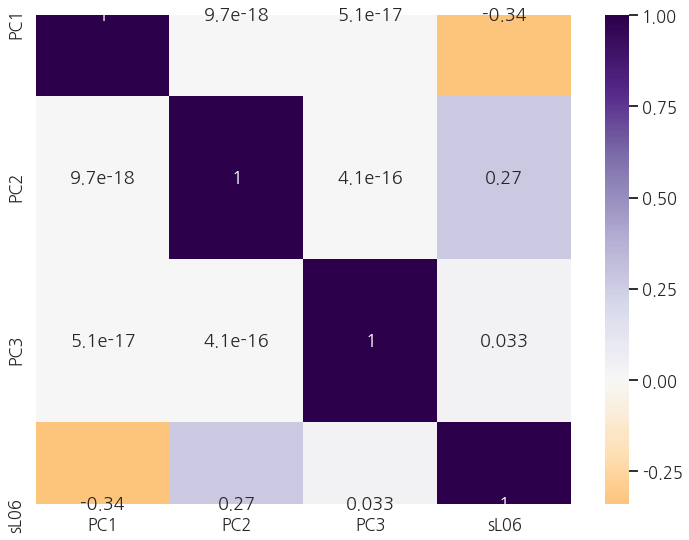

In [20]:
plt.figure(figsize=(12,9))
sns.heatmap(pca_result.corr(method='pearson'), annot=True, cmap="PuOr", center = 0)
del pca_result['sL06']

## 5.2.3 PCA1 구성요소 시각화

> higher the value in absolute value, the higher the influence on the principal component.



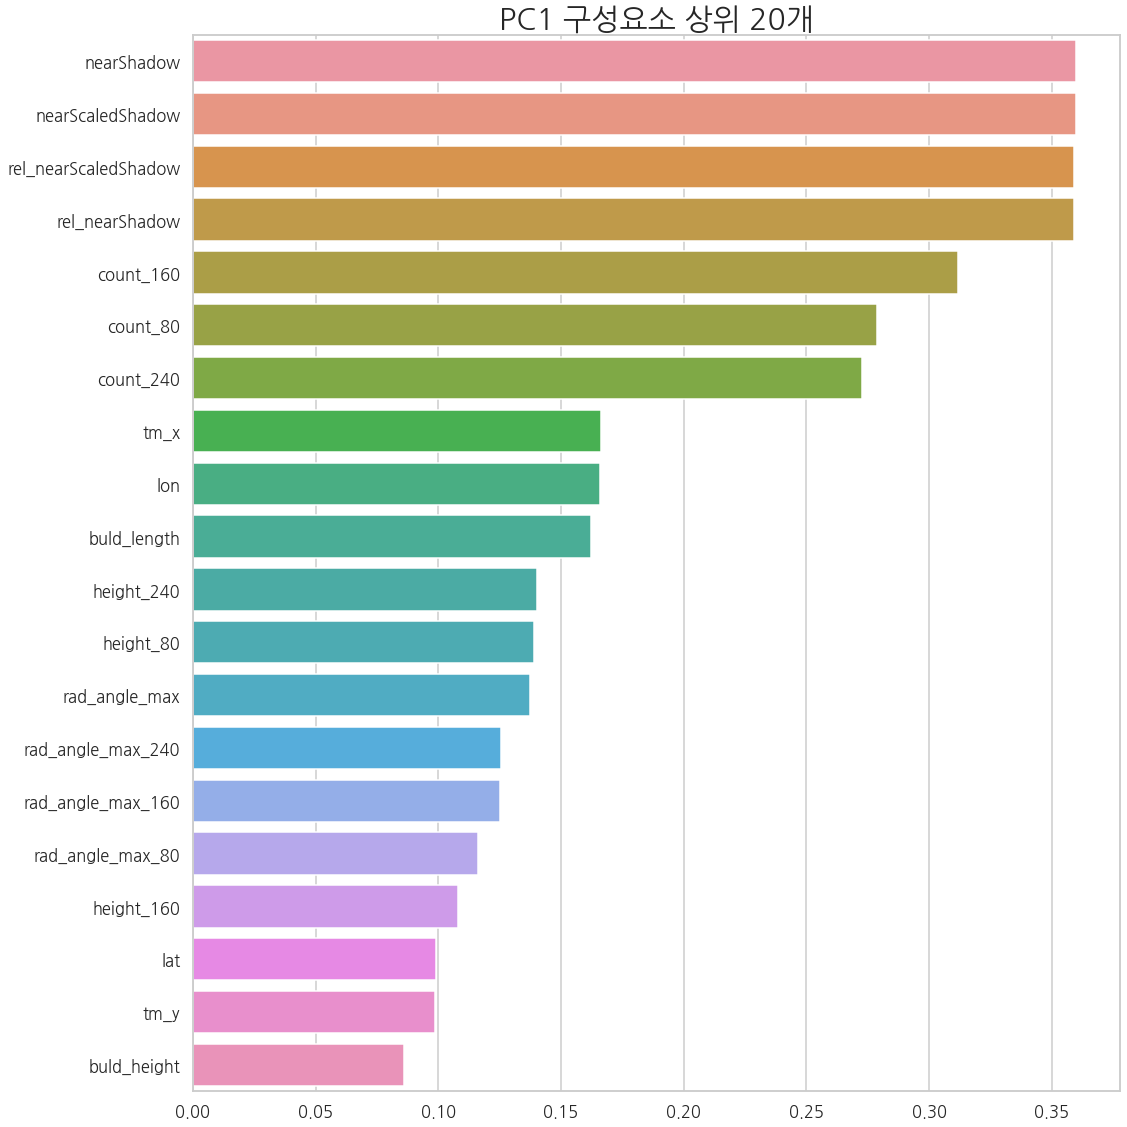

In [21]:
print("> higher the value in absolute value, the higher the influence on the principal component.")
# https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components 를보고 
print("")
PCA1 = pca_importances.loc[0].sort_values(ascending=False)
PCA1_abs = pca_importances.loc[0].abs().sort_values(ascending=False)
PCA1_abs = PCA1_abs[:20]
PC1_idx = PCA1_abs.index
PC1_val = PCA1_abs.values
fig, ax = plt.subplots(figsize=(16, 16))
ax = sns.barplot(x=PC1_val, y = PC1_idx)
plt.title("PC1 구성요소 상위 20개" , fontsize = 30) 
plt.tight_layout()


## 5.3 Factor analysis (FA)

데이터가 주어지면 변수들을 비슷한 성격들로 묶어서 새로운 **잠재변수**들을 만들어 낸다

Factor Analysis (FA) is an exploratory data analysis method used to search influential underlying factors or latent variables from a set of observed variables.

It is used to explain the variance among the observed variable and condense a set of the observed variable into the unobserved variable called factors.
Factor or latent variable is associated with multiple observed variables, who have common patterns of responses
Each factor explains a particular amount of variance in the observed variables


![](https://res.cloudinary.com/dchysltjf/image/upload/f_auto,q_auto:best/v1554830233/1.png)


## 5.3.1 계산

In [22]:
from sklearn.decomposition import FactorAnalysis

def factor (data , n_components) :
    
    factFunc = FactorAnalysis(n_components = n_components)
    
    columnsName = []
    for i in range(1,n_components+1) :
        columnsName.append('FACTOR'+str(i))
        
    factors = factFunc.fit_transform(data)
    
    factors_importances = pd.DataFrame(factFunc.components_, columns=list(data.columns))

    factors_df = pd.DataFrame(data = factors
                 , columns = columnsName)
    return factors_df , factors_importances

factors_result , factors_importances = factor(fe_data , 3)
factors_result = pd.concat([factors_result , fe_y] , axis =1 )
factors_result.head()

FACTOR1   FACTOR2   FACTOR3      sL06
0 -0.068656  0.751213 -0.033711  0.139599
1  0.454400 -1.156412  1.892590  0.178177
2 -0.887327  0.571631  0.026121  0.164108
3 -1.103517  0.783682 -0.249232  0.304955
4 -1.249299  0.533220  0.304595  0.095113

## 5.3.2 FACTOR들과 차폐율 correlation 시각화

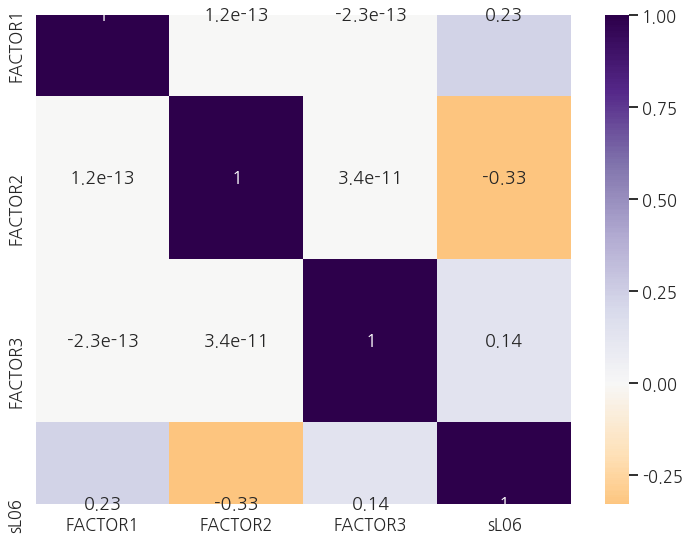

In [23]:
plt.figure(figsize=(12, 9))
sns.heatmap(factors_result.corr(method='pearson'), annot=True, cmap="PuOr", center=0)
del factors_result['sL06']

## 5.3.3 FACTOR2 구성요소 시각화

> higher the value in absolute value, the higher the influence on the principal component.



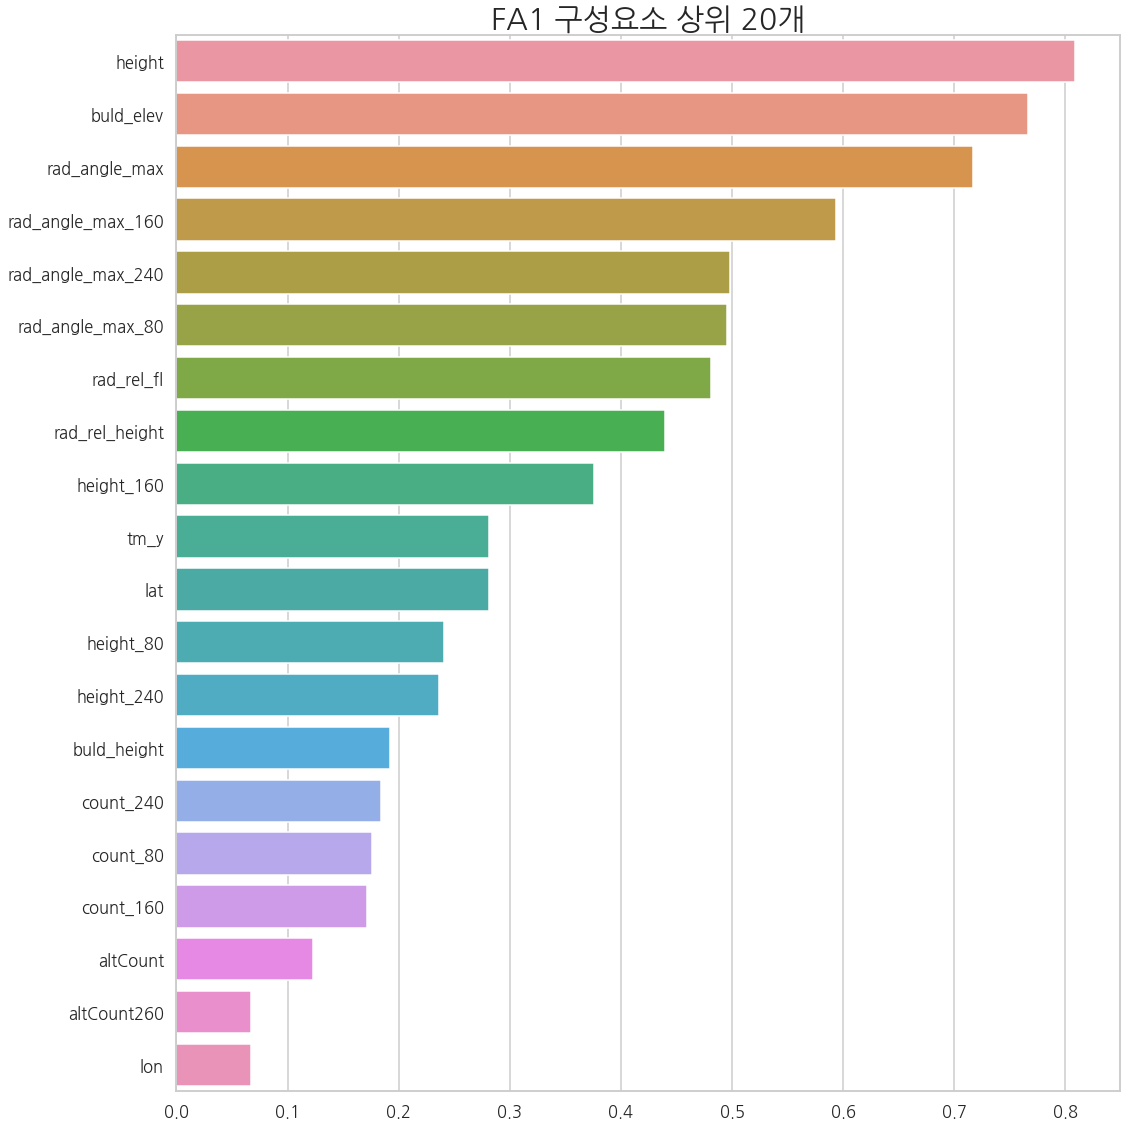

In [24]:
print("> higher the value in absolute value, the higher the influence on the principal component.")
# https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components 를보고 
print("")
FA1 = factors_importances.loc[1].sort_values(ascending=False)
FA1_abs = factors_importances.loc[1].abs().sort_values(ascending=False)
FA1_abs = FA1_abs[:20]
FA1_idx = FA1_abs.index
FA1_val = FA1_abs.values
fig, ax = plt.subplots(figsize=(16, 16))
ax = sns.barplot(x=FA1_val, y = FA1_idx)
plt.title("FA1 구성요소 상위 20개" , fontsize = 30) 
plt.tight_layout()

# 6. 모델링

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn import linear_model


## 6.1 데이터셋 준비

* 태양광 차폐율과 상관계수가 낮은 변수 삭제
* PCA1, PCA2, FACTOR1, FACTOR2 추가
* PCA만 사용하거나 FACTOR 사용하면 낮은 성능이 나와서 기본 변수에 추가하였다.

In [26]:
from sklearn.model_selection import train_test_split

build_data = pd.read_csv("./data/2.7/build_data_3group_80100.csv")

model_data = copy.deepcopy(build_data)
y  = model_data['sL_y17']

y_df = pd.DataFrame()
y_df['sL_y17'] = model_data['sL_y17']
for i in range(1,13) :
    y_df['sL'+str(i).zfill(2)] = model_data['sL'+str(i).zfill(2)]
    del model_data['sL'+str(i).zfill(2)]
del model_data['sL_y17']
del model_data['gid']
del model_data['buld_se_nm']
del model_data['sig_nm']
del model_data['emd_nm']

del model_data['apt_yn']
del model_data['sig_cd']
del model_data['emd_cd']

del model_data['buld_se_cd']
del model_data['gro_flo_co']
del model_data['bdtyp_cd']

del model_data['tm_x']
del model_data['tm_y']
del model_data['lon']
del model_data['lat']

model_data['PC1'] = pca_result['PC1']
model_data['PC2'] = pca_result['PC2']
model_data['FACTOR1'] = factors_result['FACTOR1']
model_data['FACTOR2'] = factors_result['FACTOR2']

print("> X data")
model_data.head()

> X data


buld_area  buld_elev  buld_length  buld_height  height  rad_angle_max  \
0  199.109760       80.0    15.922136         3.14   83.14       5.011625   
1   77.392318       71.0     9.926679         3.14   74.14      35.570123   
2   91.076386       77.0    10.768568         3.14   80.14       5.080622   
3   51.201706       78.0     8.074159         3.14   81.14       1.555146   
4  455.844167       80.0    24.091468         3.14   83.14       7.164204   

   rad_rel_fl  rad_rel_height  rad_angle_max_80  rad_angle_max_160  \
0    1.000000        1.587692          0.902407           5.011625   
1    2.473684        6.327369          1.182603          35.570123   
2    1.333333        2.356000          5.080622           4.332678   
3    0.000000        1.000000          0.000000           1.555146   
4    1.000000        2.859999          1.343876           3.126923   

   rad_angle_max_240  count_80  count_160  count_240  height_80  height_160  \
0           0.000000        11          9          6  83.874546   84.186667   
1          15.608649        14         20          5  73.260000   77.880000   
2           3.259005         1          4          6  84.280000   82.710000   
3           0.000000         3          4          0  81.140000   81.640000   
4           7.164204         1          1          2  84.140000   85.099999   

   height_240  nearShadow  nearScaledShadow  rel_nearShadow  \
0   82.306667  514.339502        514.339502       10.375585   
1   80.340001  706.151655        706.151655       16.730038   
2   81.663333  214.120840        214.120840        3.661072   
3    0.000000  134.841008        134.841008        4.020769   
4   87.379998   81.380586         81.380586        1.843745   

   rel_nearScaledShadow  altCount60  altCount70  altCount80  altCount90  \
0             10.375585           0           0           0           0   
1             16.730038           0           0           0           0   
2              3.661072           0           0           0           0   
3              4.020769           0           0           0           0   
4              1.843745           0           0           0           0   

   altCount100  altCount110  altCount120  altCount130  altCount140  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   altCount150  altCount160  altCount170  altCount180  altCount190  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   altCount200  altCount210  altCount220  altCount230  altCount240  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   altCount250  altCount260  altCount270  altCount280  altCount290  altCount  \
0            0            0            0            0            0         0   
1            0            0            0            0            0         0   
2            0            0            0            0            0         0   
3            0            0            0            0            0         0   
4            0            0            0            0            0         0   

        PC1       PC2   FACTOR1   FACTOR2  
0 -0.272457 -1.970118 -0.06

In [27]:
print("> Y data")
y_df.head()

> Y data


sL_y17      sL01      sL02      sL03      sL04      sL05      sL06  \
0  0.180697  0.204715  0.217257  0.205812  0.184260  0.153714  0.139599   
1  0.205046  0.295631  0.231582  0.193751  0.177985  0.176701  0.178177   
2  0.181562  0.195469  0.200133  0.191029  0.185189  0.171563  0.164108   
3  0.344058  0.371389  0.378444  0.366326  0.342754  0.316217  0.304955   
4  0.115303  0.131596  0.138417  0.124781  0.116576  0.102620  0.095113   

       sL07      sL08      sL09      sL10      sL11      sL12  
0  0.138983  0.163898  0.196457  0.204533  0.213280  0.208075  
1  0.185056  0.182143  0.187676  0.211802  0.252642  0.330147  
2  0.155892  0.172701  0.185788  0.188739  0.196957  0.201032  
3  0.310306  0.327509  0.357109  0.368799  0.378022  0.374364  
4  0.086709  0.104519  0.118837  0.127436  0.138503  0.138233

## 5.2 모델 튜닝

* GridSearch를 이용해 최적의 파라미터를 탐색

### 5.2.1 RandomForest

In [ ]:
dataset = { 'Basic Data' : model_data}

param = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
    'n_estimators': [100]#, 200, 300, 1000]
}

model_data.columns
for name , data in dataset.items() :
    print(name)
    for col in y_df.columns :          # 모든 월 학습
        if col == 'sL06' :
            print(col)
            trnx, tstx, trny, tsty = train_test_split(data , y_df[col], test_size=0.3, random_state=510)
            CV_rfc = GridSearchCV(estimator=RandomForestRegressor(random_state = 42), param_grid=param, cv= 5)
            CV_rfc.fit(trnx,trny)
            print(col)
            print(CV_rfc.best_params_ , CV_rfc.best_score_)

## 5.3 모델 학습

* 기본 build dataset , pca dataset , factors datset을 가지고 LassoRegressor , RandomForestRegressor 를 만들고 평가

### 5.3.1 RandomForest

In [28]:
feature_importances_list = {}

dataset = { 'data' : model_data}

for name , data in dataset.items() : 
    
    print('datset : ' , name)
    
    for col in y_df.columns :          # 모든 월 학습
        if col == 'sL06' :
            print(col)
            trnx, tstx, trny, tsty = train_test_split(data , y_df[col], test_size=0.3, random_state=510)
            forest = RandomForestRegressor(n_estimators = 400, random_state = 42 , max_depth=8, max_features='auto')
            forest.fit(trnx,trny)

            y_pred = forest.predict(tstx)
            y_true = tsty

            rmse = mean_squared_error(y_true, y_pred)**0.5
            print('RMSE: {}'.format(rmse))

            r2 = r2_score(y_true, y_pred)
            print('r2_score: {}'.format(r2))


            feature_importances = pd.DataFrame(forest.feature_importances_,
                                       index = trnx.columns,
                                        columns=['importance']).sort_values('importance',ascending=False)

            feature_importances_list[name] = feature_importances
        
    
     

datset :  data
sL06
RMSE: 0.056636214515295664
r2_score: 0.6209726995282109


In [43]:
print("> 랜덤포레스트 특성 중요도")

bestFeature = feature_importances_list['data'].head(8).index

feature_importances_list['data'].head(10)

> 랜덤포레스트 특성 중요도


importance
buld_length          0.268292
buld_area            0.264366
buld_height          0.198619
rad_angle_max        0.112996
FACTOR2              0.081588
rad_angle_max_80     0.019950
rad_rel_fl           0.017510
PC2                  0.010683
rad_angle_max_240    0.003843
PC1                  0.002958

### 5.2.3 MLP

* 랜덤포레스트의 특성중요도에서 0.1을 넘는 것들로만 피쳐로 MLP에 넣는다.

In [47]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [48]:
MLP_data = model_data[bestFeature]
MLP_data.head()

buld_length   buld_area  buld_height  rad_angle_max   FACTOR2  \
0    15.922136  199.109760         3.14       5.011625  0.751213   
1     9.926679   77.392318         3.14      35.570123 -1.156412   
2    10.768568   91.076386         3.14       5.080622  0.571631   
3     8.074159   51.201706         3.14       1.555146  0.783682   
4    24.091468  455.844167         3.14       7.164204  0.533220   

   rad_angle_max_80  rad_rel_fl       PC2  
0          0.902407    1.000000 -1.970118  
1          1.182603    2.473684  1.390762  
2          5.080622    1.333333 -1.329675  
3          0.000000    0.000000 -1.713507  
4          1.343876    1.000000 -1.398946

data
(103427, 50)
Train on 103427 samples, validate on 44327 samples
Epoch 1/30
103427/103427 [==============================] - 6s 61us/step - loss: 196.8192 - mean_squared_error: 196.8192 - val_loss: 1.2393 - val_mean_squared_error: 1.2393
Epoch 2/30
103427/103427 [==============================] - 6s 60us/step - loss: 2.8421 - mean_squared_error: 2.8421 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 3/30
103427/103427 [==============================] - 6s 59us/step - loss: 0.4339 - mean_squared_error: 0.4339 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 4/30
103427/103427 [==============================] - 6s 59us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 5/30
103427/103427 [==============================] - 6s 59us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 6/30
103427/103427 [==============================] - 6s 58us/step - loss: 0

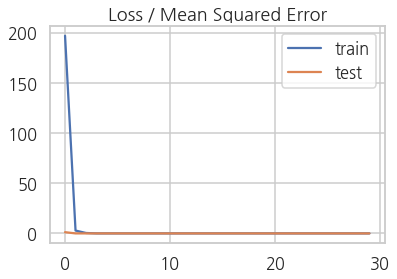

loss:  0.0033299288463328313
mse:  0.0033299288463328313
mae:  0.0033299288463328313
r2_score: 0.6034505480918515


In [51]:
meter_list = [100]


inputScaler = StandardScaler()
outputScaler = StandardScaler()

dataset = { 'data' : MLP_data}

for name , data in dataset.items() : 
    print(name)
    
    for col in y_df.columns :          # 모든 월 학습
        if col == 'sL06' :
            
            values = model_data.values
            yvalues = y_df[col].values

            trnx, tstx, trny, tsty = train_test_split(values, yvalues, test_size = 0.3, random_state = 7) 


            print(trnx.shape)

            model = Sequential()
            model.add(Dense(256, input_shape = (trnx.shape[1],), activation = 'relu'))
            model.add(Dense(256, input_shape = (trnx.shape[1],), activation = 'relu'))
            model.add(Dense(128, input_shape = (trnx.shape[1],), activation = 'relu'))
            model.add(Dense(1, activation='linear'))
            model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

            history = model.fit(trnx, trny, validation_data=(tstx, tsty), batch_size = 50, epochs = 30, verbose = 1)

            yhat = model.predict(tstx)

            results = model.evaluate(tstx, tsty)

            print(model.metrics_names)     # 모델의 평가 지표 이름
            print(results)                 # 모델 평가 지표의 결과값


            pyplot.title('Loss / Mean Squared Error')
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='test')
            pyplot.legend()
            pyplot.show()


            print('loss: ', results[0])
            print('mse: ', results[1])
            print('mae: ', results[1])
            print('r2_score: {}'.format( r2_score(tsty,yhat) ))

# 7. 오류 데이터 탐색

## 7.1 기본 데이터 통계량으로 

In [38]:
print("> build_elev 가 0인 지역이 있다. ")
print("> build_area 가 0.085?? ")
build_data.describe()

> build_elev 가 0인 지역이 있다. 
> build_area 가 0.085?? 


gid     buld_se_cd       bdtyp_cd     gro_flo_co  \
count  147754.000000  147754.000000  147754.000000  147754.000000   
mean    73879.886230       0.000129    2743.962999       2.225192   
std     42653.850793       0.011339    3563.400798       2.640942   
min         1.000000       0.000000    1001.000000       0.000000   
25%     36940.250000       0.000000    1001.000000       1.000000   
50%     73880.500000       0.000000    1001.000000       1.000000   
75%    110818.750000       0.000000    3001.000000       3.000000   
max    147757.000000       1.000000   27999.000000      51.000000   

              sig_cd        emd_cd           tm_x           tm_y  \
count  147754.000000  1.477540e+05  147754.000000  147754.000000   
mean    30163.558144  3.016367e+07  236031.476313  415930.007843   
std        41.590794  4.159049e+04    3958.920583    4753.128154   
min     30110.000000  3.011010e+07  222297.650879  399497.269602   
25%     30140.000000  3.014010e+07  233752.454974  413250.281785   
50%     30170.000000  3.017010e+07  236796.589572  415336.547005   
75%     30200.000000  3.020012e+07  239036.101693  417658.383435   
max     30230.000000  3.023013e+07  248248.670094  433289.760746   

                 lon            lat      buld_area      buld_elev  \
count  147754.000000  147754.000000  147754.000000  147754.000000   
mean      127.401358      36.340744     186.553186      64.722290   
std         0.044114       0.042821     773.325543      24.032289   
min       127.248215      36.192872       0.085259       0.000000   
25%       127.375950      36.316569      72.208554      50.000000   
50%       127.409934      36.335367     105.244051      59.000000   
75%       127.434913      36.356298     153.676529      73.360001   
max       127.537952      36.497256  130409.550646     575.000000   

                sL01          sL02          sL03           sL04          sL05  \
count  147754.000000  1.477540e+05  1.477540e+05  147754.000000  1.477540e+05   
mean        0.274277  2.685908e-01  2.550624e-01       0.247065  2.400351e-01   
std         0.121401  1.161354e-01  1.068918e-01       0.097255  9.254429e-02   
min         0.000000 -8.037372e-08 -1.126334e-07       0.000000 -8.496465e-08   
25%         0.191926  1.906091e-01  1.839556e-01       0.183548  1.800585e-01   
50%         0.253134  2.501446e-01  2.399787e-01       0.236630  2.331349e-01   
75%         0.331815  3.237634e-01  3.072338e-01       0.296675  2.888749e-01   
max         1.000000  1.000000e+00  1.000000e+00       1.000000  1.000000e+00   

               sL06          sL07           sL08          sL09          sL10  \
count  1.477540e+05  1.477540e+05  147754.000000  1.477540e+05  1.477540e+05   
mean   2.367617e-01  2.339712e-01       0.242184  2.510784e-01  2.617524e-01   
std    9.183400e-02  9.425481e-02       0.094981  1.027978e-01  1.116784e-01   
min   -9.394481e-08 -1.367877e-07      -0.001216 -1.128162e-07 -7.829614e-08   
25%    1.773150e-01  1.720979e-01       0.180206  1.830862e-01  1.869779e-01   
50%    2.311752e-01  2.267862e-01       0.233463  2.377713e-01  2.447668e-01   
75%    2.855046e-01  2.838453e-01       0.291708  3.023004e-01  3.154933e-01   
max    1.000000e+00  1.000000e+00       1.000000  1.000000e+00  1.000000e+00   

               sL11          sL12        sL_y17    buld_length    buld_height  \
count  1.477540e+05  1.477540e+05  1.477540e+05  147754.000000  147754.000000   
mean   2.758601e-01  2.868252e-01  2.521642e-01      13.105849       6.987102   
std    1.207685e-01  1.303093e-01  1.006024e-01       8.109504       8.292557   
min   -9.711478e-08 -1.040759e-07 -8.473776e-08       0.329477       0.000000   
25%    1.941835e-01  1.977643e-01  1.854689e-01       9.588472       3.140000   
50%    2.558799e-01  2.620942e-01  2.402841e-01      11.575875       3.140000   
75%    3.331805e-01  3.471215e-01  3.035972e-01      13.988103       9.420000   
max    1.000000e+00  1.000000e+00  1.000000e+00     407.48324

## 7.2 기준 빌딩과 인접 빌딩간의 앙각이 최대인 지역들 조사 ( 층수 데이터 오류 )

* 두 빌딩 간의 앙각이 70~80도 정도가 될 수 있다.
* 오류 데이터 판별을 위해 앙각이 높은 몇개의 데이터를 시각화 해보았다.


* <u>데이터 검증을 위해 앙각이 높은 데이터 시각화 도중 최대 앙강이 84도인 index 145129에 buildNear_3d와 네이버API를 사용하여 시각화 해본 결과 오류 데이터로 판별</u> 
    * 데이터 상에는 층수가 51로 되어 있었지만 사실상 1층 건물이었다.
* 이와 비슷한 데이터들 다수 발견

In [52]:
af =  pd.read_csv("./data/farthest/affectBuild/affectBuild_100.csv")
af[af.groupby(['azimuth'])['re_angle'].transform(max) == af['re_angle']].sort_values(['azimuth'])

tm_x       tm_y   re_angle       dist  azimuth  aziMean    altMean  \
10   12.903015  -0.931051  77.107943  12.936562     90.0       90  47.757666   
82   33.029490  -7.280506  75.019627  33.822374    100.0      100  57.938121   
166  25.430100 -14.333201  79.467174  29.191277    110.0      110  64.945184   
11    5.905838  -4.298924  82.697130   7.304770    120.0      120  69.489285   
133  10.824333 -10.454849  83.578919  15.048922    130.0      130  72.503030   
180  10.714849 -13.099283  83.847732  16.923333    140.0      140  74.450469   
37    6.652448 -15.540192  82.140633  16.904219    150.0      150  75.698172   
109   5.920734 -21.483763  80.880153  22.284685    160.0      160  76.455223   
154   2.130708 -21.404407  81.707374  21.510196    170.0      170  76.792825   
88   -0.554402 -20.958854  81.006997  20.966185    180.0      180  76.784099   
161  -2.230632 -11.574372  78.219705  11.787358    190.0      190  76.394843   
232  -8.456400 -10.110318  84.786007  13.180639    210.0      210  74.328750   
184 -24.955054 -28.734741  75.539456  38.058377    220.0      220  72.290815   
77   -6.472057  -4.930616  81.378149   8.136246    230.0      230  69.243356   
189 -12.228075  -7.036181  78.335863  14.107929    240.0      240  64.673595   
203 -42.617635 -15.271414  73.915009  45.271171    250.0      250  57.748476   
195 -33.479817  -3.351510  75.986898  33.647151    260.0      260  47.560246   

     baseIndex  
10        8457  
82       49413  
166     109718  
11        9949  
133      86610  
180     118992  
37       25041  
109      71188  
154      98994  
88       54923  
161     101378  
232     145129  
184     121150  
77       47499  
189     122314  
203     130472  
195     126677

        gro_flo_co          tm_x           tm_y        lat         lon  \
112000          51  236230.05229  414770.350103  36.330294  127.403514   
145129           5  236238.50869  414780.460421  36.330385  127.403608   

        buld_elev   buld_area    sL_y17  
112000       46.0   76.715696  0.357289  
145129       46.0  134.380898  0.434428  
Base Building gid :  0    46347
Name: gid, dtype: object


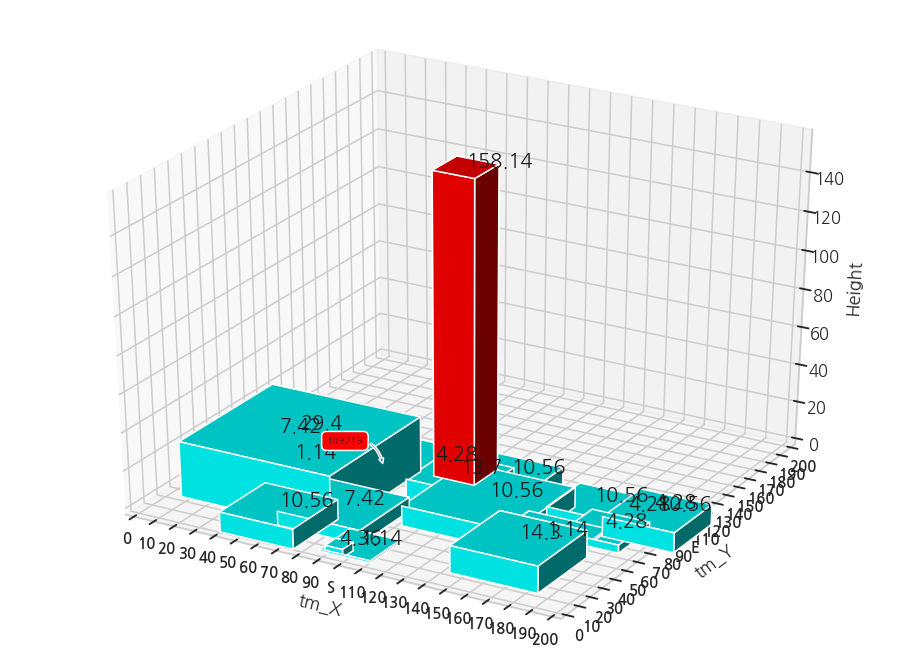

최대앙각 index  109719
주위 건물 수 :  18
rad_angle_max :  0.0
rad_angle_max_80 :  0.0
rad_angle_max_160 :  0.0
rad_angle_max_240 :  0.0
count_80 :  4.0
count_160 :  5.0
count_240 :  9.0


In [57]:
%matplotlib inline

print(build_data.iloc[[112000 , 145129]][['gro_flo_co','tm_x','tm_y','lat','lon','buld_elev','buld_area','sL_y17']])
buildNear_3d(build_data ,realnearest_dist_list , realnearest_ind_list , 112000 ,100)

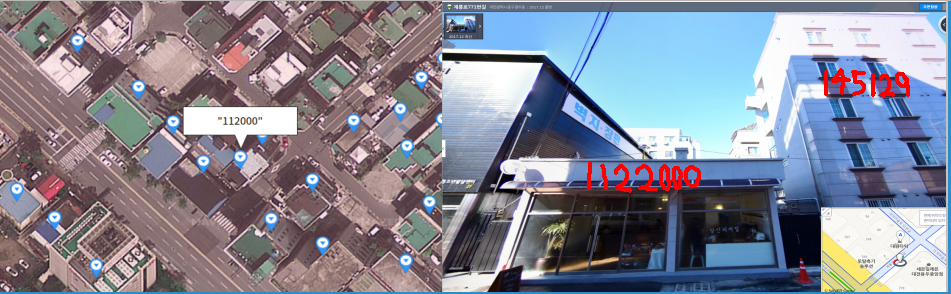

In [58]:
Image("./image/presentation/errordata_angle.png")

## 7.3 RandomForest 모델로 True-Predict Scatter Plot 시각화 ( 차폐율 오류 )

* <u>학습시킨 RF모델로 True-Predict scatterplot을 그려봤더니 예측을 거의 못하는 몇몇 튀는 값들이 발견되어 가장 오차율이 큰 데이터를 조사해보았더니 차폐율 값이 1이 나왔다. 에러 데이터라고 판단</u>
* 차폐율 값이 1인 데이터 근처를 조사해본 결과 매노동에 근처에있는 데이터가 모두 차폐율이 1이 나왔다

In [61]:
from sklearn.model_selection import train_test_split

build_data = pd.read_csv("./data/2.7/build_data_3group_80100.csv")

model_data = copy.deepcopy(build_data)
y  = model_data['sL_y17']

y_df = pd.DataFrame()
y_df['sL_y17'] = model_data['sL_y17']
for i in range(1,13) :
    y_df['sL'+str(i).zfill(2)] = model_data['sL'+str(i).zfill(2)]
    del model_data['sL'+str(i).zfill(2)]
del model_data['sL_y17']
del model_data['gid']
del model_data['buld_se_nm']
del model_data['sig_nm']
del model_data['emd_nm']

del model_data['apt_yn']
del model_data['sig_cd']
del model_data['emd_cd']

del model_data['buld_se_cd']
del model_data['gro_flo_co']
del model_data['bdtyp_cd']

del model_data['tm_x']
del model_data['tm_y']
del model_data['lon']
del model_data['lat']

model_data['PC1'] = pca_result['PC1']
model_data['PC2'] = pca_result['PC2']
model_data['FACTOR1'] = factors_result['FACTOR1']
model_data['FACTOR2'] = factors_result['FACTOR2']

print("> X data")
model_data.head()

> X data


buld_area  buld_elev  buld_length  buld_height  height  rad_angle_max  \
0  199.109760       80.0    15.922136         3.14   83.14       5.011625   
1   77.392318       71.0     9.926679         3.14   74.14      35.570123   
2   91.076386       77.0    10.768568         3.14   80.14       5.080622   
3   51.201706       78.0     8.074159         3.14   81.14       1.555146   
4  455.844167       80.0    24.091468         3.14   83.14       7.164204   

   rad_rel_fl  rad_rel_height  rad_angle_max_80  rad_angle_max_160  \
0    1.000000        1.587692          0.902407           5.011625   
1    2.473684        6.327369          1.182603          35.570123   
2    1.333333        2.356000          5.080622           4.332678   
3    0.000000        1.000000          0.000000           1.555146   
4    1.000000        2.859999          1.343876           3.126923   

   rad_angle_max_240  count_80  count_160  count_240  height_80  height_160  \
0           0.000000        11          9          6  83.874546   84.186667   
1          15.608649        14         20          5  73.260000   77.880000   
2           3.259005         1          4          6  84.280000   82.710000   
3           0.000000         3          4          0  81.140000   81.640000   
4           7.164204         1          1          2  84.140000   85.099999   

   height_240  nearShadow  nearScaledShadow  rel_nearShadow  \
0   82.306667  514.339502        514.339502       10.375585   
1   80.340001  706.151655        706.151655       16.730038   
2   81.663333  214.120840        214.120840        3.661072   
3    0.000000  134.841008        134.841008        4.020769   
4   87.379998   81.380586         81.380586        1.843745   

   rel_nearScaledShadow  altCount60  altCount70  altCount80  altCount90  \
0             10.375585           0           0           0           0   
1             16.730038           0           0           0           0   
2              3.661072           0           0           0           0   
3              4.020769           0           0           0           0   
4              1.843745           0           0           0           0   

   altCount100  altCount110  altCount120  altCount130  altCount140  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   altCount150  altCount160  altCount170  altCount180  altCount190  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   altCount200  altCount210  altCount220  altCount230  altCount240  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   altCount250  altCount260  altCount270  altCount280  altCount290  altCount  \
0            0            0            0            0            0         0   
1            0            0            0            0            0         0   
2            0            0            0            0            0         0   
3            0            0            0            0            0         0   
4            0            0            0            0            0         0   

        PC1       PC2   FACTOR1   FACTOR2  
0 -0.272457 -1.970118 -0.06

In [62]:
y_pred = forest.predict(model_data)
# y_true = y_df['sL06']
y_true = y_df['sL_y17']

distance_list = []
distanceTup_list = []
p1=np.array([0,0])
p2=np.array([1,1])

for i in range(len(y_true)) :
    p3 = np.array([y_true[i] , y_pred[i]])
    d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
    distance_list.append(d)
    distanceTup_list.append((i,d))
    

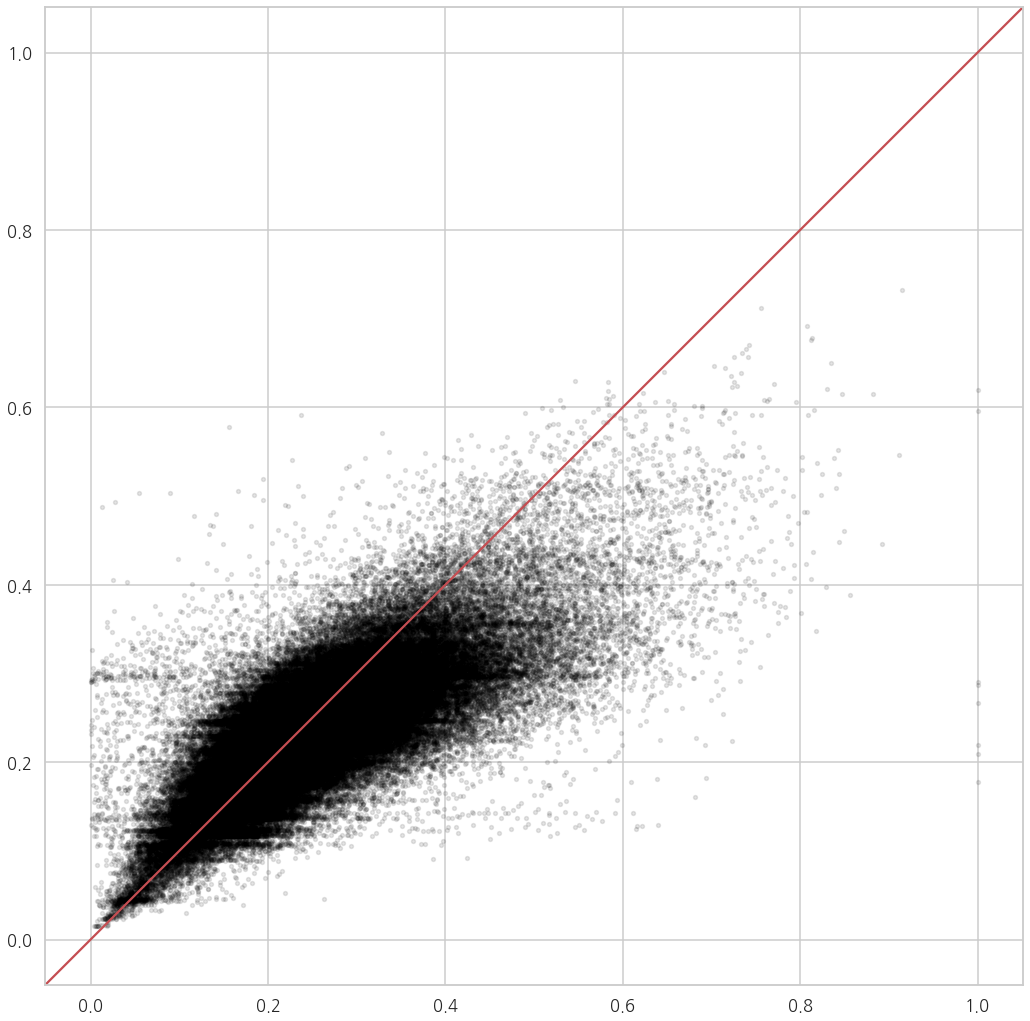

[(59184, 0.5812335422910362),
 (40666, 0.5592861796219591),
 (41186, 0.5523463437885499),
 (36710, 0.5183428196073864),
 (88812, 0.5039713587508319),
 (133930, 0.5018188052372357),
 (11516, 0.36809624345267244),
 (30176, 0.362130218784808),
 (144204, 0.3614100859126105),
 (14327, 0.35362251400220124),
 (9910, 0.34901318190912006),
 (130329, 0.346191856940049),
 (33057, 0.3449434688427555),
 (116314, 0.33548440712127364),
 (129617, 0.3349600562442802)]

In [63]:
fig, ax = plt.subplots(figsize=(24,18))

ax.scatter(y_true, y_pred, s=15,color='black', alpha = 0.1 , edgecolors=None)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, color='r')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.show()

distanceTup_list.sort(key = lambda tup : tup[1] , reverse=True)
distanceTup_list[:15]

In [64]:
build_data.iloc[59184]

gid                        81156
buld_se_cd                     0
buld_se_nm                    지상
bdtyp_cd                    3999
apt_yn                         N
gro_flo_co                     1
sig_cd                     30170
sig_nm                        서구
emd_cd                  30170118
emd_nm                       매노동
tm_x                      230535
tm_y                      405956
lon                       127.34
lat                      36.2511
buld_area                76.1277
buld_elev                     75
sL01                           1
sL02                           1
sL03                           1
sL04                           1
sL05                           1
sL06                           1
sL07                           1
sL08                           1
sL09                           1
sL10                           1
sL11                           1
sL12                           1
sL_y17                         1
buld_length              9.84524
          

In [65]:
build_data.loc[build_data['emd_cd']==30170118].sort_values(by='sL_y17' , ascending=False).head(5)

gid  buld_se_cd buld_se_nm  bdtyp_cd apt_yn  gro_flo_co  sig_cd  \
41186   81155           0         지상      3999      N           1   30170   
59184   81156           0         지상      3999      N           1   30170   
133930  92486           0         지상      1001      N           1   30170   
40666   81154           0         지상      3999      N           1   30170   
142943  98933           0         지상      1001      N           1   30170   

       sig_nm    emd_cd emd_nm           tm_x           tm_y         lon  \
41186      서구  30170118    매노동  230539.261080  405944.429110  127.339788   
59184      서구  30170118    매노동  230534.677414  405955.944930  127.339738   
133930     서구  30170118    매노동  230183.099040  406093.572006  127.335831   
40666      서구  30170118    매노동  230540.791208  405955.255613  127.339806   
142943     서구  30170118    매노동  229397.985726  404700.126739  127.327044   

              lat  buld_area  buld_elev     sL01      sL02      sL03  \
41186   36.250954  55.188591       75.0  1.00000  1.000000  1.000000   
59184   36.251058  76.127734       75.0  1.00000  1.000000  1.000000   
133930  36.252310  37.892886       80.0  1.00000  1.000000  1.000000   
40666   36.251052  57.362825       75.0  1.00000  1.000000  1.000000   
142943  36.239776   9.044060       99.0  0.66024  0.675806  0.599597   

            sL04      sL05      sL06     sL07      sL08      sL09      sL10  \
41186   1.000000  1.000000  1.000000  1.00000  1.000000  1.000000  1.000000   
59184   1.000000  1.000000  1.000000  1.00000  1.000000  1.000000  1.000000   
133930  1.000000  1.000000  1.000000  1.00000  1.000000  1.000000  1.000000   
40666   1.000000  1.000000  1.000000  1.00000  1.000000  1.000000  1.000000   
142943  0.538187  0.475415  0.446677  0.43862  0.497302  0.572834  0.640493   

            sL11      sL12    sL_y17  buld_length  buld_height  height  \
41186   1.000000  1.000000  1.000000     8.382619         3.14   78.14   
59184   1.000000  1.000000  1.000000     9.845245         3.14   78.14   
133930  1.000000  1.000000  1.000000     6.945986         3.14   83.14   
40666   1.000000  1.000000  1.000000     8.546146         3.14   78.14   
142943  0.688269  0.683104  0.556258     3.393413         3.14  102.14   

        rad_angle_max  rad_rel_fl  rad_rel_height  rad_angle_max_80  \
41186        0.876662         0.0        0.759998          0.000000   
59184        0.731985         0.0        0.759998          0.000000   
133930       5.264244         0.0        3.416470          5.264244   
40666        0.731012         0.0        0.759998          0.000000   
142943       3.357151         0.0        1.781538          0.000000   

        rad_angle_max_160  rad_angle_max_240  count_80  count_160  count_240  \
41186            0.876662                0.0         1          6          1   
59184            0.731985                0.0         1          8          2   
133930           3.997460                0.0         7         12          0   
40666            0.731012                0.0         2          8          0   
142943           3.357151                0.0         0         24          9   

        height_80  height_160  height_240  nearShadow  nearScaledShadow  \
41186   78.140000   78.393333   78.140000  148.245147        148.245147   
59184   78.140000   78.330000   78.140000  203.702231        203.702231   
133930  87.837142   85.156666    0.000000  387.205989        387.205989   
40666   78.140000   78.330000    0.000000  185.216536        185.216536   
142943   0.000000  103.021666  101.028889  800.032672        800.032672   

        rel_nearShadow  rel_nearScaledShadow  altCount60  altCount70  \
41186         5.034109              5.034109           0           0   
59184        14.625546             14.625546           0           0   
133930       10.893207             10.893207           0           0   
40666         9.489584              9.489584           0           0   
142943       21.95

# 8. 추후 개선할 일

* 빨간색 글씨로 써져있는 내용들 다 개선
* 빌딩 데이터를 사용해 GNN으로 학습
* predict-true 그래프를 그려서 예측을 못하는 점들 모아서 분석하거나 새로운 모델 만들기